# New CVID data

### Analysis based on GEX and SoupX-denoised protein

DE analysis with `limma`

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
# need to do 'pip3 install bbknn==1.3.8' to avoid incompatibility errors
#import bbknn
# requires 'pip install scrublet'
#import scrublet as scr
import os
#import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
%%bash

pip freeze

aiohttp==3.7.3
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1611176215154/work
aniso8601==9.0.1
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1610315727443/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1610991770283/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1611678357911

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.4
chardet             3.0.4
cloudpickle         1.6.0
colorama            0.4.4
constants           NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.2
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.17.2
jinja2              2.11.2
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.2
jupyterlab_server   2.1.3
kiwisolver          1.3.1
le

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

## Reading the fully analysed object


In [6]:
# reading the fully analysed object, final annotation in 'cell_type_final', normalised, log tr and scaled in .X (HVG-subsetted)
# norm, log tr in .raw.X, all genes
adata_hvg = sc.read(save_path+'adata_hvg_bbknn_by_sample_validation_cohort_final_manifold_with_annotation_20210217.h5ad')

In [7]:
adata_hvg.var['feature_types-0'].value_counts()

Gene Expression     2476
Antibody Capture     145
nan                    6
Name: feature_types-0, dtype: int64

In [8]:
adata_hvg

AnnData object with n_obs × n_vars = 95064 × 2627
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4'

In [9]:
np.unique(adata_hvg.obs['cell_type'])

array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
       'B_cells_naive_activated', 'MAIT_cells', 'Macrophages',
       'Monocytes_classical', 'Monocytes_intermediate',
       'Monocytes_non-classical', 'NK_CD16_bright',
       'NK_CD16_bright_activated', 'NK_CD56_bright',
       'NK_CD56_bright_activated', 'Plasma_cells', 'Precursor_cells',
       'T4_activated', 'T4_memory', 'T4_naive', 'T8_activated',
       'T8_naive', 'TCM_CD8+', 'TEM_CD8+', 'TMRA_CD8+', 'T_gd', 'T_regs',
       'cDC1', 'cDC2', 'iNKT_cells', 'pDC'], dtype=object)

In [10]:
# producing tables for Javi
adata_act_mem_B_cells = adata_hvg[adata_hvg.obs['cell_type'] == 'B_cells_memory_activated'].copy()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
# norm and log tr in .raw.X
adata_act_mem_B_cells.raw.X

<5290x21749 sparse matrix of type '<class 'numpy.float32'>'
	with 13952067 stored elements in Compressed Sparse Row format>

In [12]:
adata_act_mem_B_cells

AnnData object with n_obs × n_vars = 5290 × 2627
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4',

In [13]:
dense_mtx = adata_act_mem_B_cells.raw.X.todense()

In [14]:
expr_mtx = pd.DataFrame(dense_mtx, 
                       index=adata_act_mem_B_cells.obs_names,
                       columns=adata_act_mem_B_cells.raw.var_names)

In [15]:
expr_mtx = expr_mtx.T
expr_mtx

index          CTTACCGTCGATCCCT-1  ACAGCTACACAACGTT-1  CCGTACTTCGGCTTGG-1  \
index                                                                       
RP11-34P13.7                  0.0            0.000000                 0.0   
FO538757.2                    0.0            0.373042                 0.0   
AP006222.2                    0.0            0.000000                 0.0   
RP4-669L17.10                 0.0            0.000000                 0.0   
RP5-857K21.4                  0.0            0.000000                 0.0   
...                           ...                 ...                 ...   
CTD-2541M15.3                 0.0            0.000000                 0.0   
THEGL                         0.0            0.000000                 0.0   
KIAA1644                      0.0            0.000000                 0.0   
RP11-132A1.3                  0.0            0.000000                 0.0   
RP11-111H13.1                 0.0            0.000000                 0.0   

index          GGGAATGCACTGTTAG-1-1  GATTCAGAGCACACAG-1  CAGCGACCACAGAGGT-1  \
index                                                                         
RP11-34P13.7               0.000000                 0.0                 0.0   
FO538757.2                 0.286917                 0.0                 0.0   
AP006222.2                 0.000000                 0.0                 0.0   
RP4-669L17.10              0.000000                 0.0                 0.0   
RP5-857K21.4               0.000000                 0.0                 0.0   
...                             ...                 ...                 ...   
CTD-2541M15.3              0.000000                 0.0                 0.0   
THEGL                      0.000000                 0.0                 0.0   
KIAA1644                   0.000000                 0.0                 0.0   
RP11-132A1.3               0.000000                 0.0                 0.0   
RP11-111H13.1              0.000000                 0.0                 0.0   

index          CGAATGTTCTGGAGCC-1  CACTCCACACAACTGT-1  AGAGTGGAGGACAGCT-1  \
index                                                                       
RP11-34P13.7                  0.0                 0.0            0.000000   
FO538757.2                    0.0                 0.0            0.330735   
AP006222.2                    0.0                 0.0            0.000000   
RP4-669L17.10                 0.0                 0.0            0.000000   
RP5-857K21.4                  0.0                 0.0            0.000000   
...                           ...                 ...                 ...   
CTD-2541M15.3                 0.0                 0.0            0.000000   
THEGL                         0.0                 0.0            0.000000   
KIAA1644                      0.0                 0.0            0.000000   
RP11-132A1.3                  0.0                 0.0            0.000000   
RP11-111H13.1                 0.0                 0.0            0.000000   

index          TGCCAAAAGAAGCCCA-1  ...  GAGCAGAAGTGGAGTC-1-1  \
index                              ...                         
RP11-34P13.7                  0.0  ...                   0.0   
FO538757.2                    0.0  ...                   0.0   
AP006222.2                    0.0  ...                   0.0   
RP4-669L17.10                 0.0  ...                   0.0   
RP5-857K21.4                  0.0  ...                   0.0   
...                           ...  ...                   ...   
CTD-2541M15.3                 0.0  ...                   0.0   
THEGL                         0.0  ...                   0.0   
KIAA1644                      0.0  ...                   0.0   
RP11-132A1.3                  0.0  ...                   0.0   
RP11-111H13.1                 0.0  ...                   0.0   

index          TATCTCAAGTGATCGG-1  GTCAAGTGTTGCGTTA-1  TTTGCGCGTAGAAGGA-1  \
index                                                     

In [16]:
meta_table = adata_act_mem_B_cells.obs.loc[expr_mtx.columns,:]

In [17]:
meta_table

batch   bh_pval  \
index                                  
CTTACCGTCGATCCCT-1       4  0.960536   
ACAGCTACACAACGTT-1       7  0.695766   
CCGTACTTCGGCTTGG-1       3  1.000000   
GGGAATGCACTGTTAG-1-1     7  0.695766   
GATTCAGAGCACACAG-1       3  1.000000   
...                    ...       ...   
AGCAGCCCATGATCCA-1       7  0.156885   
CCGTTCAAGCTGCAAG-1       7  0.695766   
ACATGGTTCTCTGAGA-1       2  0.718179   
AAGACCTCAGGCTGAA-1       7  0.695766   
CGGACTGGTAAGGGAA-1-1     3  1.000000   

                                                                cell_id  \
index                                                                     
CTTACCGTCGATCCCT-1    CTTACCGTCGATCCCT-1_35008_CV005_RV9039262_and_3...   
ACAGCTACACAACGTT-1             ACAGCTACACAACGTT-1_35171_CV005_RV9039362   
CCGTACTTCGGCTTGG-1    CCGTACTTCGGCTTGG-1_35008_CV005_RV9039261_and_3...   
GGGAATGCACTGTTAG-1-1           GGGAATGCACTGTTAG-1_35171_CV005_RV9039362   
GATTCAGAGCACACAG-1    GATTCAGAGCACACAG-1_35008_CV005_RV9039261_and_3...   
...                                                                 ...   
AGCAGCCCATGATCCA-1             AGCAGCCCATGATCCA-1_35171_CV005_RV9039362   
CCGTTCAAGCTGCAAG-1             CCGTTCAAGCTGCAAG-1_35171_CV005_RV9039362   
ACATGGTTCTCTGAGA-1    ACATGGTTCTCTGAGA-1_35008_CV005_RV9039260_and_3...   
AAGACCTCAGGCTGAA-1             AAGACCTCAGGCTGAA-1_35171_CV005_RV9039362   
CGGACTGGTAAGGGAA-1-1  CGGACTGGTAAGGGAA-1_35008_CV005_RV9039261_and_3...   

                           dataset      n_counts  n_genes  percent_mito  \
index                                                                     
CTTACCGTCGATCCCT-1    GEX+CITE-seq   1158.310059    760.0      0.019452   
ACAGCTACACAACGTT-1    GEX+CITE-seq  22116.808594   4151.0      0.018699   
CCGTACTTCGGCTTGG-1    GEX+CITE-seq   8295.115234   2757.0      0.032635   
GGGAATGCACTGTTAG-1-1  GEX+CITE-seq  30092.105469   5155.0      0.024323   
GATTCAGAGCACACAG-1    GEX+CITE-seq   2290.230225   1211.0      0.032976   
...                            ...           ...      ...           ...   
AGCAGCCCATGATCCA-1    GEX+CITE-seq  41303.152344   5881.0      0.019538   
CCGTTCAAGCTGCAAG-1    GEX+CITE-seq  10896.425781   2689.0      0.026512   
ACATGGTTCTCTGAGA-1    GEX+CITE-seq   2800.290039   1242.0      0.027597   
AAGACCTCAGGCTGAA-1    GEX+CITE-seq   8575.252930   2423.0      0.026028   
CGGACTGGTAAGGGAA-1-1  GEX+CITE-seq   3376.411621   1471.0      0.028854   

                                                               sample  \
index                                                                   
CTTACCGTCGATCCCT-1    35008_CV005_RV9039262_and_35008_CV005_RV9039286   
ACAGCTACACAACGTT-1                              35171_CV005_RV9039362   
CCGTACTTCGGCTTGG-1    35008_CV005_RV9039261_and_35008_CV005_RV9039285   
GGGAATGCACTGTTAG-1-1                            35171_CV005_RV9039362   
GATTCAGAGCACACAG-1    35008_CV005_RV9039261_and_35008_CV005_RV9039285   
...                                                               ...   
AGCAGCCCATGATCCA-1                              35171_CV005_RV9039362   
CCGTTCAAGCTGCAAG-1                              35171_CV005_RV9039362   
ACATGGTTCTCTGAGA-1    35008_CV005_RV9039260_and_35008_CV005_RV9039284   
AAGACCTCAGGCTGAA-1                              35171_CV005_RV9039362   
CGGACTGGTAAGGGAA-1-1  35008_CV005_RV9039261_and_35008_CV005_RV9039285   

                      scrublet_cluster_score  scrublet_score  ...  \
index                                                         ...   
CTTACCGTCGATCCCT-1                  0.091022        0.042634  ...   
ACAGCTACACAACGTT-1                  0.123247        0.072264  ...   
CCGTACTTCGGCTTGG-1                  0.107328        0.111617  ...   
GGGAATGCACTGTTAG-1-1                0.073458        0.092809  ...   
GATTCAGAGCACACAG-1                  0.078049        0.075269  ...   
...                                      ...             ...  ...   
AGCAGCCCATGATCCA-1                  0.258687  

In [18]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

In [19]:
expr_mtx.to_csv(save_path + '20210224_B_cells_memory_activated_expression_matrix_normlog_validation_cohort.csv')

In [20]:
meta_table.to_csv(save_path + '20210224_B_cells_memory_activated_metadata_table_validation_cohort.csv')

_____________________________________________________________________________________________________________________________________________________________

# Plotting

In [10]:
adata_hvg

AnnData object with n_obs × n_vars = 95064 × 2627
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4'

In [11]:
markers = ['CD4','CD3G', 'FOXJ1', 'IL2R', 'TRDV2', 'CD8', # T cells
                             'CD19', 'MS4A1', # B cells
                              'CD27', 'CD38', 'JCHAIN', # Plasma B cells
                             'NCAM1', 'FCGR3A', # NK celss
                             'HBB', # Erythrocytes
                             'FCGR3B', # Neutrophils
                             'CD14', 'S100A12', # Monocytes
                             'FLT3', # Dendritic cells
                             'IRF4', 'CLEC9A', # cDC1
                             'CD1C', # cDC2
                             'TNFRSF21', # pDC and IRF4
                             'CD34', # Precursors
                             'PPBP', 'TUBB1', 'PF4', # Platelets
                             'MI67', # cycling
                            ]

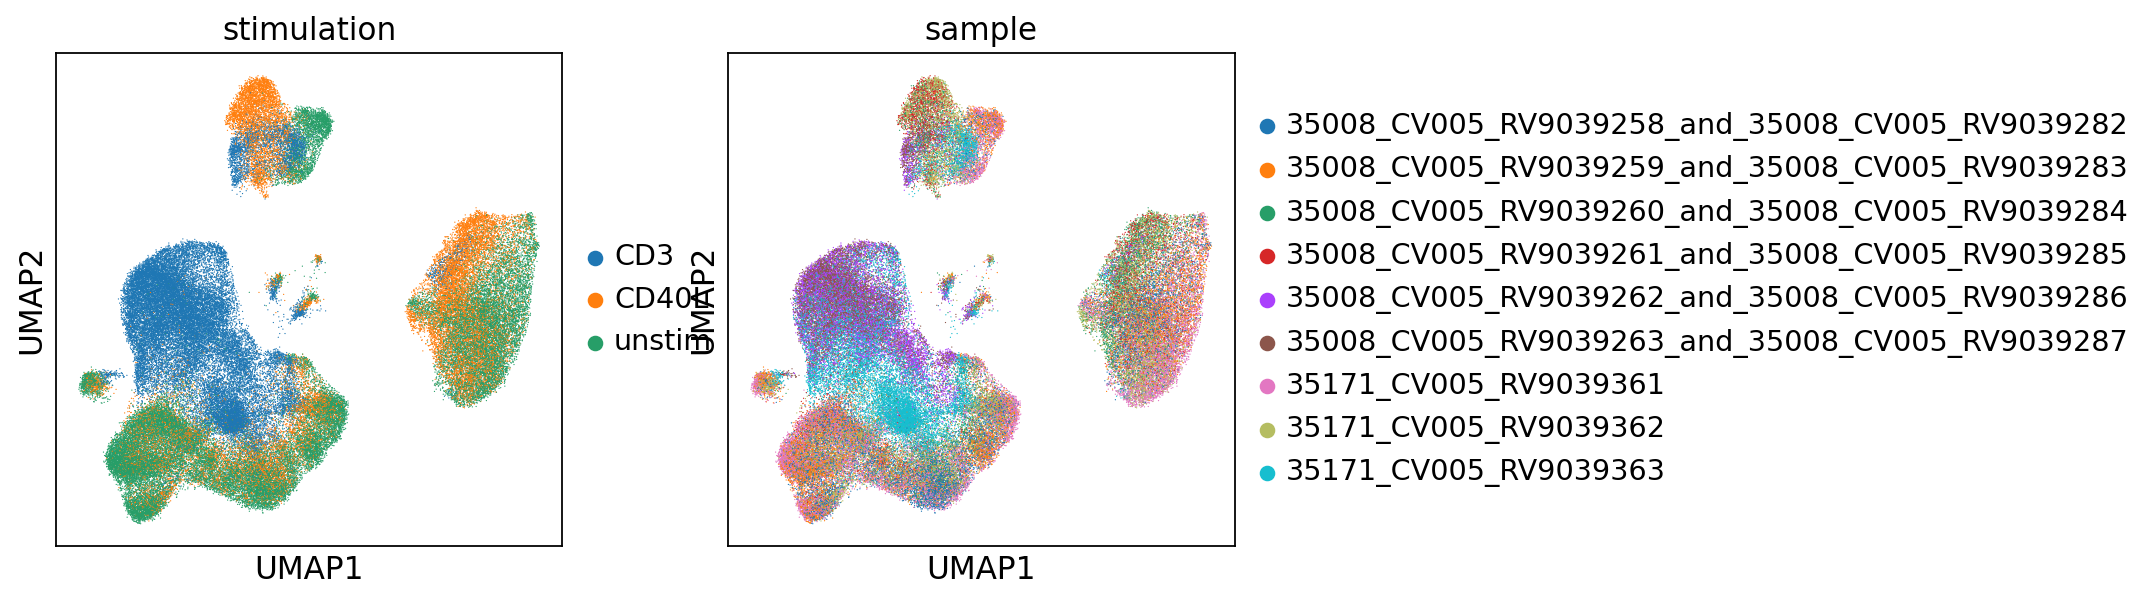

In [12]:
sc.pl.umap(adata_hvg, color=['stimulation','sample'])

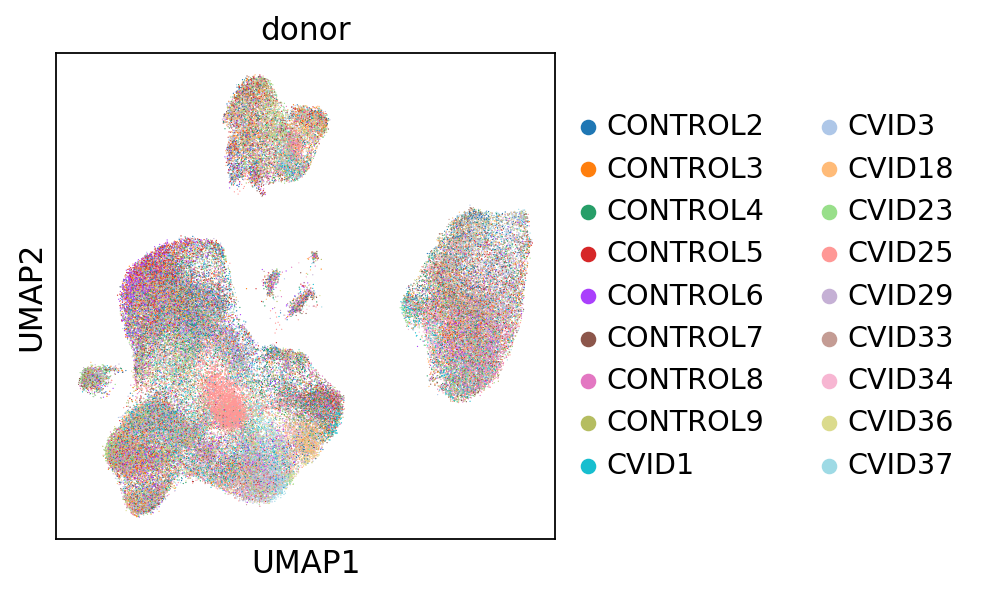

In [13]:
sc.pl.umap(adata_hvg, color=['donor'])

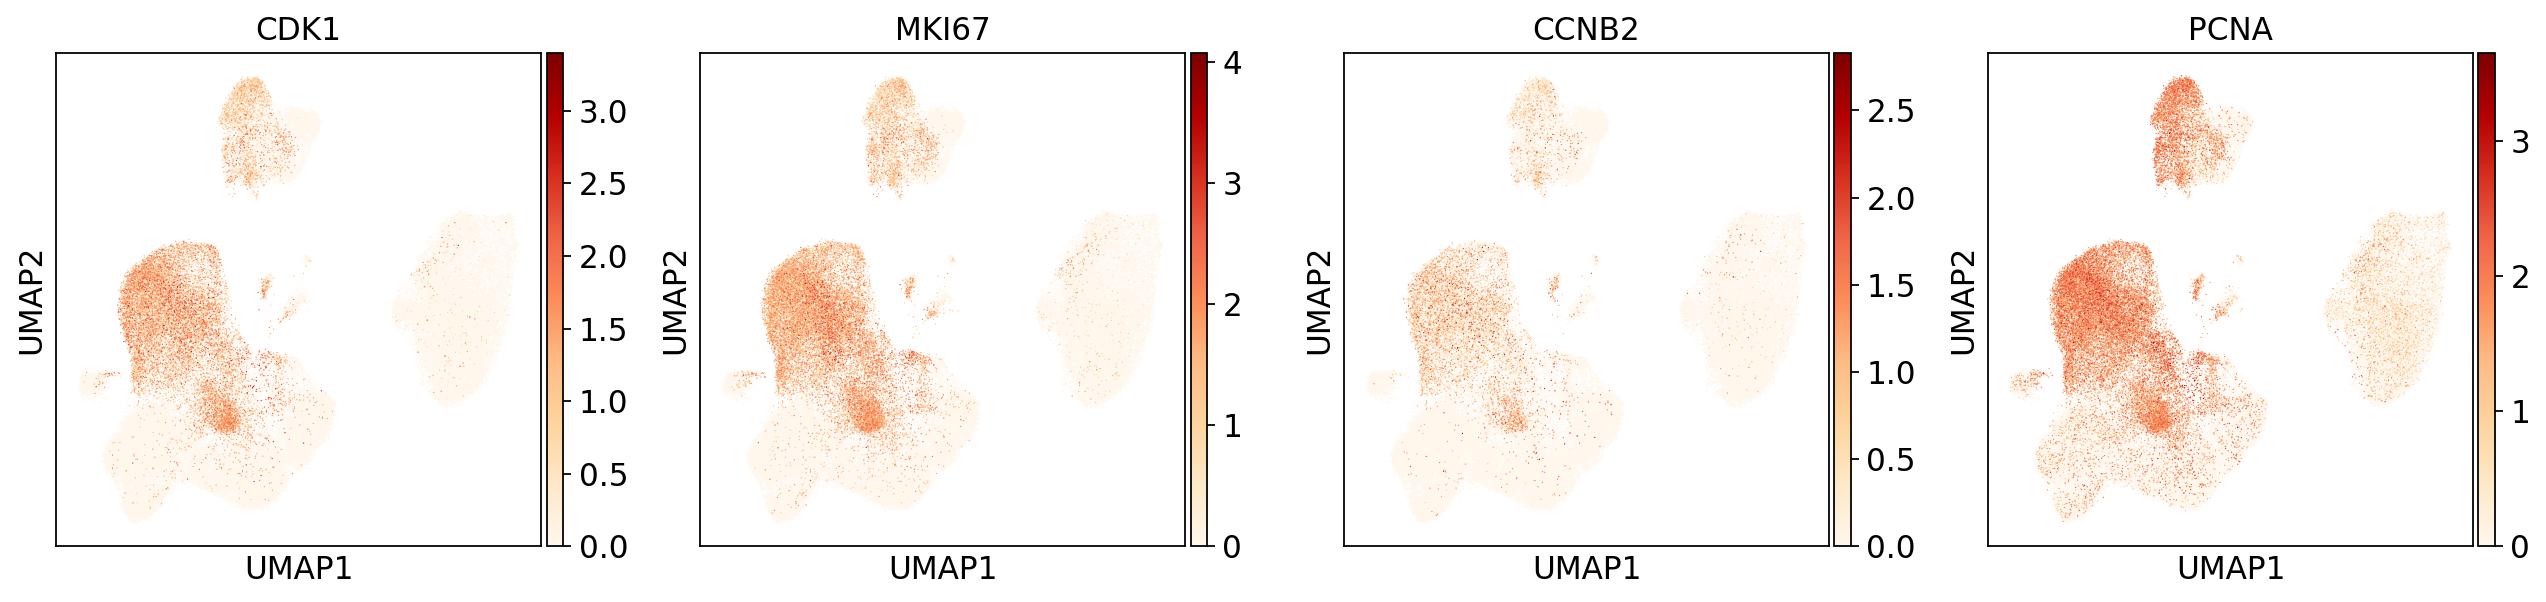

In [14]:
sc.pl.umap(adata_hvg, color=['CDK1','MKI67','CCNB2','PCNA'], cmap='OrRd')

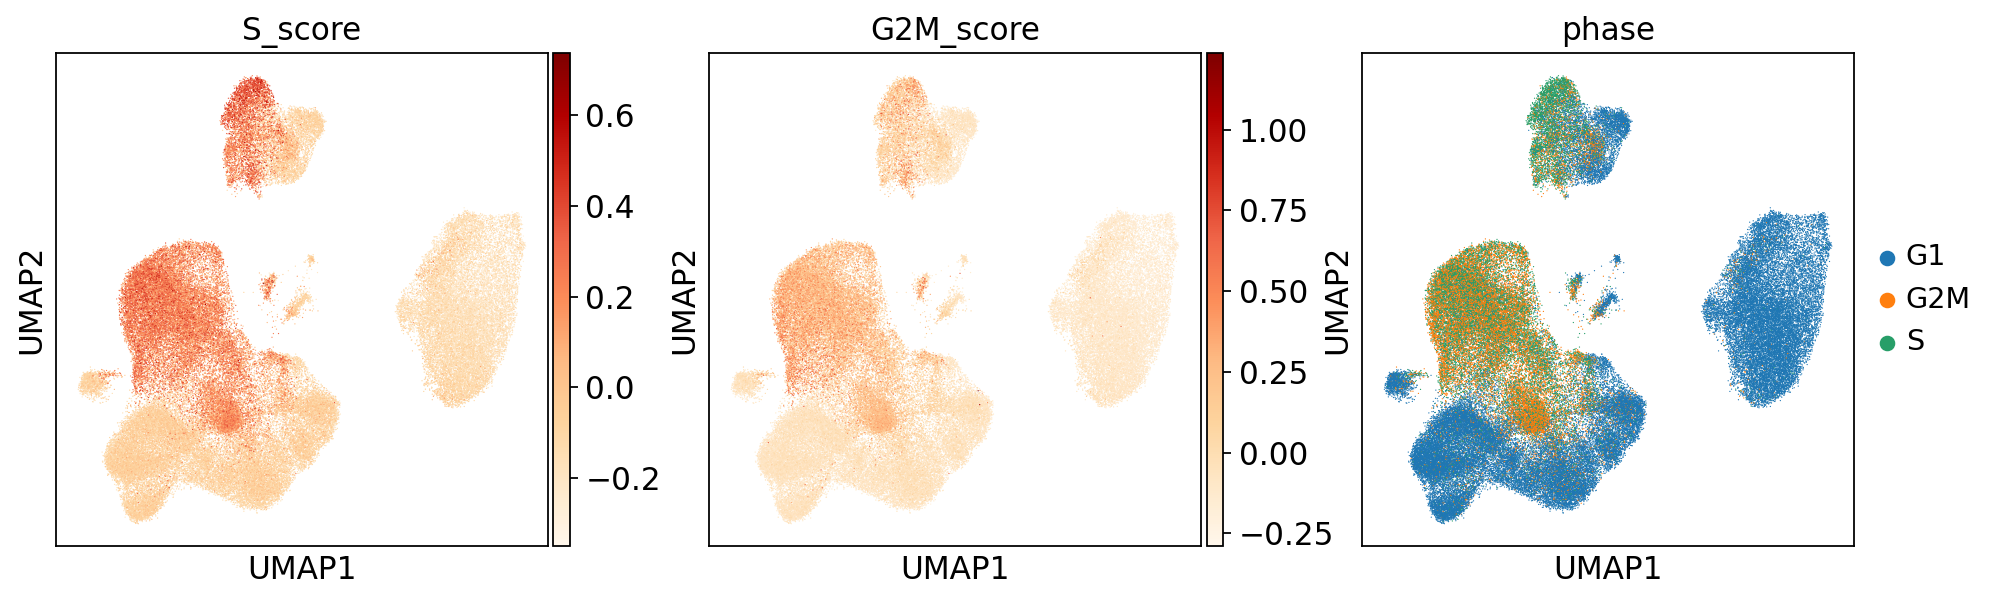

In [15]:
sc.pl.umap(adata_hvg, color=['S_score','G2M_score','phase'], cmap='OrRd')

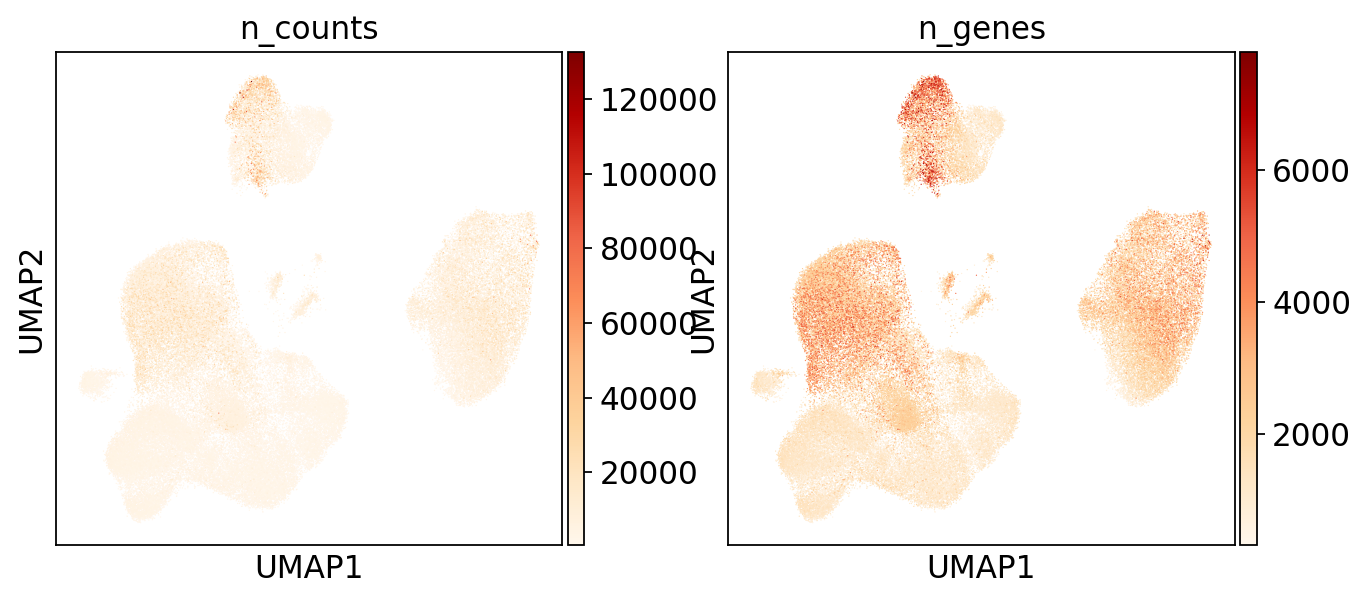

In [16]:
sc.pl.umap(adata_hvg, color=['n_counts',
                             'n_genes'], cmap='OrRd')

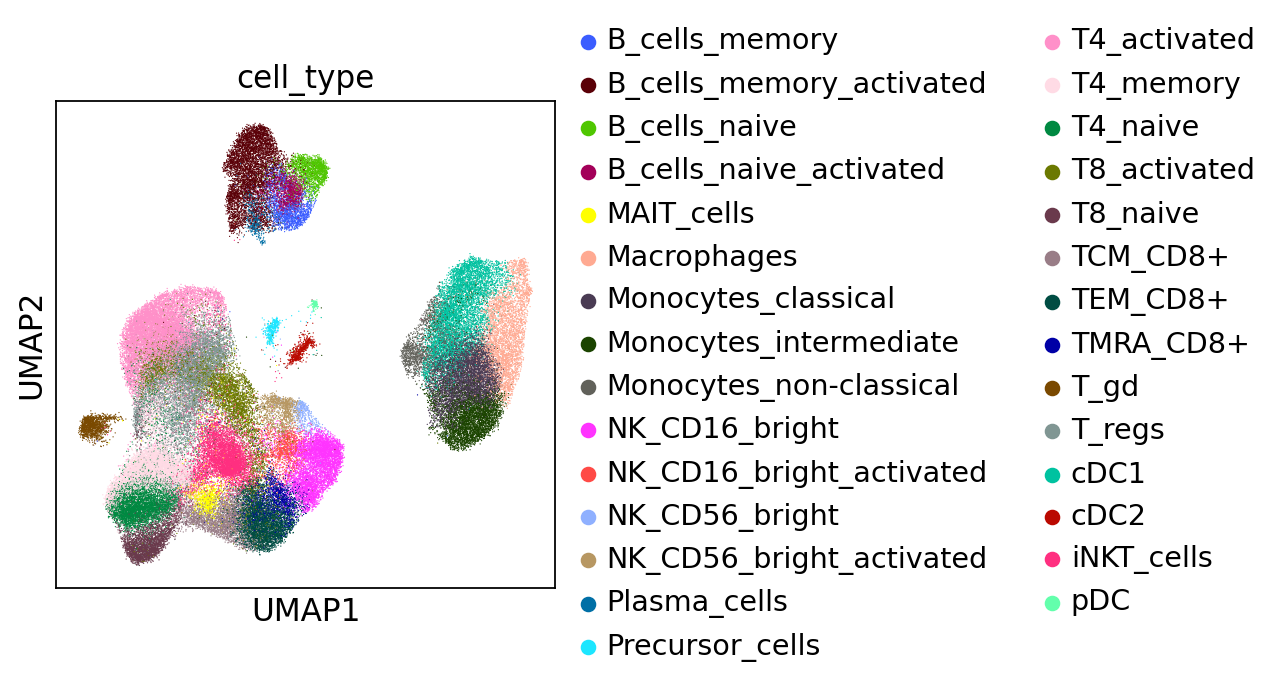

In [17]:
sc.pl.umap(adata_hvg, color=['cell_type'],
           #cmap='OrRd'
          )

In [18]:
adata_hvg

AnnData object with n_obs × n_vars = 95064 × 2627
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4'

In [ ]:
sc.pl.umap(adata_hvg, color=['GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'],
           cmap='OrRd'
          )

# TODO: make a pretty colormap for these cell states

# DE with limma

Only twins CVID vs CONTROL:
- all general cell types
- GC-like B cells only (all predicted)
- GC-like B cells by activation

In [10]:
np.unique(adata_hvg.obs['donor'])

array(['CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5', 'CONTROL6',
       'CONTROL7', 'CONTROL8', 'CONTROL9', 'CVID1', 'CVID18', 'CVID23',
       'CVID25', 'CVID29', 'CVID3', 'CVID33', 'CVID34', 'CVID36',
       'CVID37'], dtype=object)

In [11]:
np.unique(adata_hvg.obs['cell_type'])

array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
       'B_cells_naive_activated', 'MAIT_cells', 'Macrophages',
       'Monocytes_classical', 'Monocytes_intermediate',
       'Monocytes_non-classical', 'NK_CD16_bright',
       'NK_CD16_bright_activated', 'NK_CD56_bright',
       'NK_CD56_bright_activated', 'Plasma_cells', 'Precursor_cells',
       'T4_activated', 'T4_memory', 'T4_naive', 'T8_activated',
       'T8_naive', 'TCM_CD8+', 'TEM_CD8+', 'TMRA_CD8+', 'T_gd', 'T_regs',
       'cDC1', 'cDC2', 'iNKT_cells', 'pDC'], dtype=object)

# All general cell types

In [12]:
# creating also the full object (all genes) - only normalised and log transformed
adata_full = anndata.AnnData(X=adata_hvg.raw.X,
                            obs=adata_hvg.obs,
                            var=adata_hvg.raw.var,
                            obsm=adata_hvg.obsm)

In [13]:
adata_full

AnnData object with n_obs × n_vars = 95064 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4

In [14]:
np.unique(adata_full.obs['CVID_status'])

array(['CONTROL', 'CVID'], dtype=object)

In [15]:
adata_full

AnnData object with n_obs × n_vars = 95064 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4

In [16]:
np.unique(adata_full.obs['cell_type'], return_counts=True)

(array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
        'B_cells_naive_activated', 'MAIT_cells', 'Macrophages',
        'Monocytes_classical', 'Monocytes_intermediate',
        'Monocytes_non-classical', 'NK_CD16_bright',
        'NK_CD16_bright_activated', 'NK_CD56_bright',
        'NK_CD56_bright_activated', 'Plasma_cells', 'Precursor_cells',
        'T4_activated', 'T4_memory', 'T4_naive', 'T8_activated',
        'T8_naive', 'TCM_CD8+', 'TEM_CD8+', 'TMRA_CD8+', 'T_gd', 'T_regs',
        'cDC1', 'cDC2', 'iNKT_cells', 'pDC'], dtype=object),
 array([ 1538,  5290,  1694,  1276,  1173,  3804,  5474,  4203,  1639,
         5294,  1090,   395,  1154,   524,   412, 10030,  7047,  5360,
         4851,  3116,  3276,  4124,  1444,  1387,  7206,  5903,   591,
         5636,   133]))

In [17]:
adata_full.obs['celltype_condition'] = [i + '_' + j for i,j in zip(adata_full.obs['cell_type'], adata_full.obs['CVID_status'])]

In [18]:
np.unique(adata_full.obs['celltype_condition'])

array(['B_cells_memory_CONTROL', 'B_cells_memory_CVID',
       'B_cells_memory_activated_CONTROL',
       'B_cells_memory_activated_CVID', 'B_cells_naive_CONTROL',
       'B_cells_naive_CVID', 'B_cells_naive_activated_CONTROL',
       'B_cells_naive_activated_CVID', 'MAIT_cells_CONTROL',
       'MAIT_cells_CVID', 'Macrophages_CONTROL', 'Macrophages_CVID',
       'Monocytes_classical_CONTROL', 'Monocytes_classical_CVID',
       'Monocytes_intermediate_CONTROL', 'Monocytes_intermediate_CVID',
       'Monocytes_non-classical_CONTROL', 'Monocytes_non-classical_CVID',
       'NK_CD16_bright_CONTROL', 'NK_CD16_bright_CVID',
       'NK_CD16_bright_activated_CONTROL',
       'NK_CD16_bright_activated_CVID', 'NK_CD56_bright_CONTROL',
       'NK_CD56_bright_CVID', 'NK_CD56_bright_activated_CONTROL',
       'NK_CD56_bright_activated_CVID', 'Plasma_cells_CONTROL',
       'Plasma_cells_CVID', 'Precursor_cells_CONTROL',
       'Precursor_cells_CVID', 'T4_activated_CONTROL',
       'T4_activated_CVID

In [30]:
# dividing into cell type specific objects

adatas_per_cell_type = {}

for ct in np.unique(adata_full.obs['cell_type']):
    print(ct)
    adatas_per_cell_type[ct] = adata_full[adata_full.obs['cell_type'] == ct].copy()

B_cells_memory
B_cells_memory_activated
B_cells_naive
B_cells_naive_activated
MAIT_cells
Macrophages
Monocytes_classical
Monocytes_intermediate
Monocytes_non-classical
NK_CD16_bright
NK_CD16_bright_activated
NK_CD56_bright
NK_CD56_bright_activated
Plasma_cells
Precursor_cells
T4_activated
T4_memory
T4_naive
T8_activated
T8_naive
TCM_CD8+
TEM_CD8+
TMRA_CD8+
T_gd
T_regs
cDC1
cDC2
iNKT_cells
pDC


In [469]:
# marker calling

curr_adata = adatas_per_cell_type['pDC'].copy()

#t = adata_hvg.X.toarray().T
t = curr_adata.X.toarray().T
df = pd.DataFrame(data=t, columns= curr_adata.obs.index, index=curr_adata.var_names)

meta_df = pd.DataFrame(data={'Cell':list(curr_adata.obs.index),
                             'cell_type':[ str(i) for i in curr_adata.obs['celltype_condition']],
                             'sample':[ str(i) for i in curr_adata.obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [470]:
meta_df

cell_type  \
Cell                              
CCACCTACATCACCCT-1     pDC_CVID   
CATGGCGGTAAGTGGC-1     pDC_CVID   
GTCAAGTCACTTCTGC-1  pDC_CONTROL   
CGATGGCAGGGCTTGA-1  pDC_CONTROL   
GCGAGAACATTTCACT-1     pDC_CVID   
...                         ...   
TTGCCGTCATCCCACT-1  pDC_CONTROL   
CACATTTAGGATTCGG-1  pDC_CONTROL   
CGTCAGGCATGGTCTA-1     pDC_CVID   
TCCACACGTAAGCACG-1     pDC_CVID   
ACTTGTTAGGAATCGC-1  pDC_CONTROL   

                                                             sample  
Cell                                                                 
CCACCTACATCACCCT-1                            35171_CV005_RV9039362  
CATGGCGGTAAGTGGC-1  35008_CV005_RV9039261_and_35008_CV005_RV9039285  
GTCAAGTCACTTCTGC-1  35008_CV005_RV9039261_and_35008_CV005_RV9039285  
CGATGGCAGGGCTTGA-1  35008_CV005_RV9039260_and_35008_CV005_RV9039284  
GCGAGAACATTTCACT-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                             ...  
TTGCCGTCATCCCACT-1  35008_CV005_RV9039260_and_35008_CV005_RV9039284  
CACATTTAGGATTCGG-1                            35171_CV005_RV9039362  
CGTCAGGCATGGTCTA-1                            35171_CV005_RV9039362  
TCCACACGTAAGCACG-1                            35171_CV005_RV9039362  
ACTTGTTAGGAATCGC-1                            35171_CV005_RV9039362  

[133 rows x 2 columns]

In [471]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['pDC_CONTROL', 'pDC_CVID'], dtype=object), array([62, 71]))

In [472]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [473]:
outpath = './limma_DEG/validation_cohort_new_20210217/'

In [474]:
%%R
library(limma)
library(edgeR)

In [475]:
meta_df.reset_index(inplace=True)

In [476]:
meta_df

Cell    cell_type  \
0    CCACCTACATCACCCT-1     pDC_CVID   
1    CATGGCGGTAAGTGGC-1     pDC_CVID   
2    GTCAAGTCACTTCTGC-1  pDC_CONTROL   
3    CGATGGCAGGGCTTGA-1  pDC_CONTROL   
4    GCGAGAACATTTCACT-1     pDC_CVID   
..                  ...          ...   
128  TTGCCGTCATCCCACT-1  pDC_CONTROL   
129  CACATTTAGGATTCGG-1  pDC_CONTROL   
130  CGTCAGGCATGGTCTA-1     pDC_CVID   
131  TCCACACGTAAGCACG-1     pDC_CVID   
132  ACTTGTTAGGAATCGC-1  pDC_CONTROL   

                                              sample  
0                              35171_CV005_RV9039362  
1    35008_CV005_RV9039261_and_35008_CV005_RV9039285  
2    35008_CV005_RV9039261_and_35008_CV005_RV9039285  
3    35008_CV005_RV9039260_and_35008_CV005_RV9039284  
4    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
..                                               ...  
128  35008_CV005_RV9039260_and_35008_CV005_RV9039284  
129                            35171_CV005_RV9039362  
130                            35171_CV005_RV9039362  
131                            35171_CV005_RV9039362  
132                            35171_CV005_RV9039362  

[133 rows x 3 columns]

In [477]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [478]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [479]:
meta_df

Cell    cell_type  \
0    CCACCTACATCACCCT.1     pDC_CVID   
1    CATGGCGGTAAGTGGC.1     pDC_CVID   
2    GTCAAGTCACTTCTGC.1  pDC_CONTROL   
3    CGATGGCAGGGCTTGA.1  pDC_CONTROL   
4    GCGAGAACATTTCACT.1     pDC_CVID   
..                  ...          ...   
128  TTGCCGTCATCCCACT.1  pDC_CONTROL   
129  CACATTTAGGATTCGG.1  pDC_CONTROL   
130  CGTCAGGCATGGTCTA.1     pDC_CVID   
131  TCCACACGTAAGCACG.1     pDC_CVID   
132  ACTTGTTAGGAATCGC.1  pDC_CONTROL   

                                              sample  
0                              35171_CV005_RV9039362  
1    35008_CV005_RV9039261_and_35008_CV005_RV9039285  
2    35008_CV005_RV9039261_and_35008_CV005_RV9039285  
3    35008_CV005_RV9039260_and_35008_CV005_RV9039284  
4    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
..                                               ...  
128  35008_CV005_RV9039260_and_35008_CV005_RV9039284  
129                            35171_CV005_RV9039362  
130                            35171_CV005_RV9039362  
131                            35171_CV005_RV9039362  
132                            35171_CV005_RV9039362  

[133 rows x 3 columns]

In [480]:
df

index          CCACCTACATCACCCT-1  CATGGCGGTAAGTGGC-1  GTCAAGTCACTTCTGC-1  \
index                                                                       
RP11-34P13.7                  0.0                 0.0                 0.0   
FO538757.2                    0.0                 0.0                 0.0   
AP006222.2                    0.0                 0.0                 0.0   
RP4-669L17.10                 0.0                 0.0                 0.0   
RP5-857K21.4                  0.0                 0.0                 0.0   
...                           ...                 ...                 ...   
CTD-2541M15.3                 0.0                 0.0                 0.0   
THEGL                         0.0                 0.0                 0.0   
KIAA1644                      0.0                 0.0                 0.0   
RP11-132A1.3                  0.0                 0.0                 0.0   
RP11-111H13.1                 0.0                 0.0                 0.0   

index          CGATGGCAGGGCTTGA-1  GCGAGAACATTTCACT-1  CAAGTTGCATGACGGA-1  \
index                                                                       
RP11-34P13.7                  0.0                 0.0                 0.0   
FO538757.2                    0.0                 0.0                 0.0   
AP006222.2                    0.0                 0.0                 0.0   
RP4-669L17.10                 0.0                 0.0                 0.0   
RP5-857K21.4                  0.0                 0.0                 0.0   
...                           ...                 ...                 ...   
CTD-2541M15.3                 0.0                 0.0                 0.0   
THEGL                         0.0                 0.0                 0.0   
KIAA1644                      0.0                 0.0                 0.0   
RP11-132A1.3                  0.0                 0.0                 0.0   
RP11-111H13.1                 0.0                 0.0                 0.0   

index          GGACAAGTCCGGGTGT-1  AATCCAGAGAATAGGG-1  CATATTCCACCTCGGA-1  \
index                                                                       
RP11-34P13.7                  0.0                 0.0                 0.0   
FO538757.2                    0.0                 0.0                 0.0   
AP006222.2                    0.0                 0.0                 0.0   
RP4-669L17.10                 0.0                 0.0                 0.0   
RP5-857K21.4                  0.0                 0.0                 0.0   
...                           ...                 ...                 ...   
CTD-2541M15.3                 0.0                 0.0                 0.0   
THEGL                         0.0                 0.0                 0.0   
KIAA1644                      0.0                 0.0                 0.0   
RP11-132A1.3                  0.0                 0.0                 0.0   
RP11-111H13.1                 0.0                 0.0                 0.0   

index          CCCATACTCCTCCTAG-1  ...  TGGCTGGGTATCAGTC-1  \
index                              ...                       
RP11-34P13.7                  0.0  ...                 0.0   
FO538757.2                    0.0  ...                 0.0   
AP006222.2                    0.0  ...                 0.0   
RP4-669L17.10                 0.0  ...                 0.0   
RP5-857K21.4                  0.0  ...                 0.0   
...                           ...  ...                 ...   
CTD-2541M15.3                 0.0  ...                 0.0   
THEGL                         0.0  ...                 0.0   
KIAA1644                      0.0  ...                 0.0   
RP11-132A1.3                  0.0  ...                 0.0   
RP11-111H13.1                 0.0  ...                 0.0   

index          AGGTCCGCAGTCTTCC-1-1  CCCTCCTGTGCTCTTC-1  TCGAGGCCATACGCCG-1  \
index                                                                         
RP11-34P13.7                 

In [481]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['pDC_CONTROL', 'pDC_CVID'], dtype=object), array([62, 71]))

In [482]:
case = 'pDC_CVID'
ctrl = 'pDC_CONTROL'

In [483]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210217_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "pDC_CVID"    "pDC_CONTROL"


R[write to console]: 133 shared cells



[1] "case" "ctrl"


# GC-like B cells

In [485]:
adata_full.obs['GC_celltype_predictions_condition'] = [i + '_' + j for i,j in zip(adata_full.obs['GC_celltype_predictions_all_genes'], adata_full.obs['CVID_status'])]

In [486]:
np.unique(adata_full.obs['GC_celltype_predictions_condition'],
         return_counts=True)

(array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID', 'Other_B_cells_CONTROL',
        'Other_B_cells_CVID', 'nan_CONTROL', 'nan_CVID'], dtype=object),
 array([ 2137,  2613,  2059,  3513, 33776, 50966]))

In [487]:
adata_GC_like_B_cells = adata_full[adata_full.obs['GC_celltype_predictions_all_genes'] == 'GC_B_cells'].copy()

In [488]:
np.unique(adata_GC_like_B_cells.obs['GC_celltype_predictions_condition'],
         return_counts=True)

(array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID'], dtype=object),
 array([2137, 2613]))

In [508]:
np.unique(adata_GC_like_B_cells.obs['stimulation'],
         return_counts=True)

(array(['CD3', 'CD40L', 'unstim'], dtype=object), array([1438, 3175,  137]))

In [505]:
adatas_GC_like_B_cells_by_activation = {}

for stimulation in np.unique(adata_GC_like_B_cells.obs['stimulation']):
    print(stimulation)
    adatas_GC_like_B_cells_by_activation[stimulation] = adata_GC_like_B_cells[adata_GC_like_B_cells.obs['stimulation'] == stimulation].copy()
    

CD3
CD40L
unstim


In [537]:
# marker calling

curr_adata = adatas_GC_like_B_cells_by_activation['unstim'].copy()

#t = adata_hvg.X.toarray().T
t = curr_adata.X.toarray().T
df = pd.DataFrame(data=t, columns= curr_adata.obs.index, index=curr_adata.var_names)

meta_df = pd.DataFrame(data={'Cell':list(curr_adata.obs.index),
                             'cell_type':[ str(i) for i in curr_adata.obs['GC_celltype_predictions_condition']],
                             'sample':[ str(i) for i in curr_adata.obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [538]:
meta_df

cell_type  \
Cell                                       
CGTTCTGTCACAGTAC-1       GC_B_cells_CVID   
TACTCATGTACATGTC-1       GC_B_cells_CVID   
GGTATTGCATACTACG-1    GC_B_cells_CONTROL   
GTAACGTAGATCCCGC-1       GC_B_cells_CVID   
CGAGCACGTCGCGGTT-1    GC_B_cells_CONTROL   
...                                  ...   
GAATGAAGTAGGCATG-1    GC_B_cells_CONTROL   
CTCTGGTGTATGAATG-1-1  GC_B_cells_CONTROL   
CTCTGGTTCATGGTCA-1       GC_B_cells_CVID   
ACAGCTACAGGAATGC-1       GC_B_cells_CVID   
TGAAAGACAGGTGGAT-1    GC_B_cells_CONTROL   

                                                               sample  
Cell                                                                   
CGTTCTGTCACAGTAC-1                              35171_CV005_RV9039361  
TACTCATGTACATGTC-1                              35171_CV005_RV9039361  
GGTATTGCATACTACG-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
GTAACGTAGATCCCGC-1                              35171_CV005_RV9039361  
CGAGCACGTCGCGGTT-1                              35171_CV005_RV9039361  
...                                                               ...  
GAATGAAGTAGGCATG-1                              35171_CV005_RV9039361  
CTCTGGTGTATGAATG-1-1                            35171_CV005_RV9039361  
CTCTGGTTCATGGTCA-1    35008_CV005_RV9039259_and_35008_CV005_RV9039283  
ACAGCTACAGGAATGC-1                              35171_CV005_RV9039361  
TGAAAGACAGGTGGAT-1                              35171_CV005_RV9039361  

[137 rows x 2 columns]

In [539]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID'], dtype=object),
 array([48, 89]))

In [540]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [541]:
outpath = './limma_DEG/validation_cohort_new_20210217/'

In [542]:
%%R
library(limma)
library(edgeR)

In [543]:
meta_df.reset_index(inplace=True)

In [544]:
meta_df

Cell           cell_type  \
0      CGTTCTGTCACAGTAC-1     GC_B_cells_CVID   
1      TACTCATGTACATGTC-1     GC_B_cells_CVID   
2      GGTATTGCATACTACG-1  GC_B_cells_CONTROL   
3      GTAACGTAGATCCCGC-1     GC_B_cells_CVID   
4      CGAGCACGTCGCGGTT-1  GC_B_cells_CONTROL   
..                    ...                 ...   
132    GAATGAAGTAGGCATG-1  GC_B_cells_CONTROL   
133  CTCTGGTGTATGAATG-1-1  GC_B_cells_CONTROL   
134    CTCTGGTTCATGGTCA-1     GC_B_cells_CVID   
135    ACAGCTACAGGAATGC-1     GC_B_cells_CVID   
136    TGAAAGACAGGTGGAT-1  GC_B_cells_CONTROL   

                                              sample  
0                              35171_CV005_RV9039361  
1                              35171_CV005_RV9039361  
2    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3                              35171_CV005_RV9039361  
4                              35171_CV005_RV9039361  
..                                               ...  
132                            35171_CV005_RV9039361  
133                            35171_CV005_RV9039361  
134  35008_CV005_RV9039259_and_35008_CV005_RV9039283  
135                            35171_CV005_RV9039361  
136                            35171_CV005_RV9039361  

[137 rows x 3 columns]

In [545]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [546]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [547]:
meta_df

Cell           cell_type  \
0      CGTTCTGTCACAGTAC.1     GC_B_cells_CVID   
1      TACTCATGTACATGTC.1     GC_B_cells_CVID   
2      GGTATTGCATACTACG.1  GC_B_cells_CONTROL   
3      GTAACGTAGATCCCGC.1     GC_B_cells_CVID   
4      CGAGCACGTCGCGGTT.1  GC_B_cells_CONTROL   
..                    ...                 ...   
132    GAATGAAGTAGGCATG.1  GC_B_cells_CONTROL   
133  CTCTGGTGTATGAATG.1.1  GC_B_cells_CONTROL   
134    CTCTGGTTCATGGTCA.1     GC_B_cells_CVID   
135    ACAGCTACAGGAATGC.1     GC_B_cells_CVID   
136    TGAAAGACAGGTGGAT.1  GC_B_cells_CONTROL   

                                              sample  
0                              35171_CV005_RV9039361  
1                              35171_CV005_RV9039361  
2    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3                              35171_CV005_RV9039361  
4                              35171_CV005_RV9039361  
..                                               ...  
132                            35171_CV005_RV9039361  
133                            35171_CV005_RV9039361  
134  35008_CV005_RV9039259_and_35008_CV005_RV9039283  
135                            35171_CV005_RV9039361  
136                            35171_CV005_RV9039361  

[137 rows x 3 columns]

In [548]:
df

index          CGTTCTGTCACAGTAC-1  TACTCATGTACATGTC-1  GGTATTGCATACTACG-1  \
index                                                                       
RP11-34P13.7                  0.0                 0.0                 0.0   
FO538757.2                    0.0                 0.0                 0.0   
AP006222.2                    0.0                 0.0                 0.0   
RP4-669L17.10                 0.0                 0.0                 0.0   
RP5-857K21.4                  0.0                 0.0                 0.0   
...                           ...                 ...                 ...   
CTD-2541M15.3                 0.0                 0.0                 0.0   
THEGL                         0.0                 0.0                 0.0   
KIAA1644                      0.0                 0.0                 0.0   
RP11-132A1.3                  0.0                 0.0                 0.0   
RP11-111H13.1                 0.0                 0.0                 0.0   

index          GTAACGTAGATCCCGC-1  CGAGCACGTCGCGGTT-1  GCTGCAGTCAGTTAGC-1  \
index                                                                       
RP11-34P13.7             0.000000                 0.0                 0.0   
FO538757.2               2.163917                 0.0                 0.0   
AP006222.2               0.000000                 0.0                 0.0   
RP4-669L17.10            0.000000                 0.0                 0.0   
RP5-857K21.4             0.000000                 0.0                 0.0   
...                           ...                 ...                 ...   
CTD-2541M15.3            0.000000                 0.0                 0.0   
THEGL                    0.000000                 0.0                 0.0   
KIAA1644                 0.000000                 0.0                 0.0   
RP11-132A1.3             0.000000                 0.0                 0.0   
RP11-111H13.1            0.000000                 0.0                 0.0   

index          CTCGAAATCGCATGGC-1  CGTAGCGAGTCAAGCG-1  GGCCGATCACAGTCGC-1  \
index                                                                       
RP11-34P13.7                  0.0                 0.0                 0.0   
FO538757.2                    0.0                 0.0                 0.0   
AP006222.2                    0.0                 0.0                 0.0   
RP4-669L17.10                 0.0                 0.0                 0.0   
RP5-857K21.4                  0.0                 0.0                 0.0   
...                           ...                 ...                 ...   
CTD-2541M15.3                 0.0                 0.0                 0.0   
THEGL                         0.0                 0.0                 0.0   
KIAA1644                      0.0                 0.0                 0.0   
RP11-132A1.3                  0.0                 0.0                 0.0   
RP11-111H13.1                 0.0                 0.0                 0.0   

index          CCACCTAGTCCTGCTT-1  ...  GGAAAGCTCCTACAGA-1  \
index                              ...                       
RP11-34P13.7                  0.0  ...            0.000000   
FO538757.2                    0.0  ...            2.460736   
AP006222.2                    0.0  ...            0.000000   
RP4-669L17.10                 0.0  ...            0.000000   
RP5-857K21.4                  0.0  ...            0.000000   
...                           ...  ...                 ...   
CTD-2541M15.3                 0.0  ...            0.000000   
THEGL                         0.0  ...            0.000000   
KIAA1644                      0.0  ...            0.000000   
RP11-132A1.3                  0.0  ...            0.000000   
RP11-111H13.1                 0.0  ...            0.000000   

index          TACCTATAGCTAGCCC-1  TCCACACGTGTTGGGA-1  CGTCCATTCCCTCAGT-1  \
index                                                                       
RP11-34P13.7                  0.0

In [549]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID'], dtype=object),
 array([48, 89]))

In [550]:
case = 'GC_B_cells_CVID'
ctrl = 'GC_B_cells_CONTROL'

In [551]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210217_', case, '_unstim_stimulation_vs_', ctrl, '_unstim_stimulation_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "GC_B_cells_CVID"    "GC_B_cells_CONTROL"


R[write to console]: 137 shared cells



[1] "case" "ctrl"


### Splitting tables into those of genes and those of proteins (Abs)

In [552]:
# getting list of Ab names
Abs = list(adata_hvg.raw.var[adata_hvg.raw.var['feature_types-0'] == 'Antibody Capture'].index)
len(Abs)

192

In [554]:
Abs[:10]

['CD80-1',
 'CD86-1',
 'CD274(B7-H1)',
 'CD273(B7-DC)',
 'CD275(B7-H2)',
 'CD11b',
 'CD252(OX40L)',
 'CD137L(4-1BBLigand)',
 'CD155(PVR)',
 'CD112(Nectin-2)']

In [555]:
cell_type_comparison_groups = list(np.unique(adata_hvg.obs['cell_type']))


In [561]:
DE_tables_cell_type = {}

DE_tables_cell_type_GEX = {}

DE_tables_cell_type_protein = {}

for cell_type in cell_type_comparison_groups:
    print(cell_type)
    DE_tables_cell_type[cell_type] = pd.read_csv('./limma_DEG/validation_cohort_new_20210217/20210217_' + cell_type + '_CVID_vs_' + cell_type + '_CONTROL_limma_DEGs.csv',
                                     index_col=0)
    
    # splitting tables into gene and protein parts
    curr_genes_and_proteins = list(DE_tables_cell_type[cell_type].index)
    curr_proteins = list(set(curr_genes_and_proteins) & set(Abs))
    curr_genes = list(set(curr_genes_and_proteins) - set(curr_proteins))
    
    DE_tables_cell_type_GEX[cell_type] = DE_tables_cell_type[cell_type].loc[curr_genes,:]
    DE_tables_cell_type_protein[cell_type] = DE_tables_cell_type[cell_type].loc[curr_proteins,:]
    
    print('shape of the whole table:', DE_tables_cell_type[cell_type].shape)
    print('shape of the genes only table:', DE_tables_cell_type_GEX[cell_type].shape)
    print('shape of the proteins only table:', DE_tables_cell_type_protein[cell_type].shape)
    
    if len(curr_genes_and_proteins) == len(curr_genes) + len(curr_proteins):
        add_up_bool = True
        print('adds up')
    else:
        add_up_bool = False
        print('does not add up!')
    print('\n')

B_cells_memory
shape of the whole table: (15968, 7)
shape of the genes only table: (15776, 7)
shape of the proteins only table: (192, 7)
adds up


B_cells_memory_activated
shape of the whole table: (18693, 7)
shape of the genes only table: (18501, 7)
shape of the proteins only table: (192, 7)
adds up


B_cells_naive
shape of the whole table: (14890, 7)
shape of the genes only table: (14699, 7)
shape of the proteins only table: (191, 7)
adds up


B_cells_naive_activated
shape of the whole table: (14876, 7)
shape of the genes only table: (14684, 7)
shape of the proteins only table: (192, 7)
adds up


MAIT_cells
shape of the whole table: (14650, 7)
shape of the genes only table: (14458, 7)
shape of the proteins only table: (192, 7)
adds up


Macrophages
shape of the whole table: (17629, 7)
shape of the genes only table: (17442, 7)
shape of the proteins only table: (187, 7)
adds up


Monocytes_classical
shape of the whole table: (17755, 7)
shape of the genes only table: (17567, 7)
shape of

In [562]:
DE_tables_cell_type_GEX['B_cells_naive']

logFC   P.Value  adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                      
IGKV3D-20  0.014395  0.139603   0.780587         0.014395      0.000000   
TMEM256    0.011461  0.733473   0.934616         0.285954      0.274493   
POP7      -0.026770  0.144999   0.780587         0.068245      0.095014   
RAB43     -0.009443  0.208772   0.790806         0.008139      0.017581   
RNF216    -0.015947  0.559847   0.871160         0.165543      0.181490   
...             ...       ...        ...              ...           ...   
TPSAB1     0.001151  0.447386   0.813497         0.001151      0.000000   
AMH       -0.002929  0.192140   0.780587         0.000000      0.002929   
C11orf85  -0.002438  0.603558   0.890235         0.003556      0.005995   
FAM134C   -0.003943  0.821665   0.960329         0.065398      0.069341   
HSPB1     -0.030635  0.287397   0.813497         0.190114      0.220750   

           percentExpr_cluster  percentExpr_rest  
Gene                                              
IGKV3D-20             0.003742            0.0000  
TMEM256               0.167446            0.1472  
POP7                  0.042095            0.0560  
RAB43                 0.004677            0.0096  
RNF216                0.097287            0.0960  
...                        ...               ...  
TPSAB1                0.000935            0.0000  
AMH                   0.000000            0.0016  
C11orf85              0.001871            0.0032  
FAM134C               0.036483            0.0400  
HSPB1                 0.117867            0.1200  

[14699 rows x 7 columns]

In [563]:
for cell_type in cell_type_comparison_groups:
    print(cell_type)
    DE_tables_cell_type_GEX[cell_type].to_csv('./limma_DEG/validation_cohort_new_20210217/separate_gene_tables/20210217_' + cell_type + '_CVID_vs_' + cell_type + '_CONTROL_limma_DEGs_genes_only.csv')
    DE_tables_cell_type_protein[cell_type].to_csv('./limma_DEG/validation_cohort_new_20210217/separate_protein_tables/20210217_' + cell_type + '_CVID_vs_' + cell_type + '_CONTROL_limma_DEGs_proteins_only.csv')

B_cells_memory
B_cells_memory_activated
B_cells_naive
B_cells_naive_activated
MAIT_cells
Macrophages
Monocytes_classical
Monocytes_intermediate
Monocytes_non-classical
NK_CD16_bright
NK_CD16_bright_activated
NK_CD56_bright
NK_CD56_bright_activated
Plasma_cells
Precursor_cells
T4_activated
T4_memory
T4_naive
T8_activated
T8_naive
TCM_CD8+
TEM_CD8+
TMRA_CD8+
T_gd
T_regs
cDC1
cDC2
iNKT_cells
pDC


In [567]:
# splitting separately the GC tables because the naming was slightly different

In [568]:
DE_tables_GC = {}
DE_tables_GC['GC_B_cells'] = pd.read_csv('./limma_DEG/validation_cohort_new_20210217/20210217_GC_B_cells_CVID_vs_GC_B_cells_CONTROL_limma_DEGs.csv',
                                     index_col=0)
DE_tables_GC['GC_B_cells_unstim'] = pd.read_csv('./limma_DEG/validation_cohort_new_20210217/20210217_GC_B_cells_CVID_unstim_stimulation_vs_GC_B_cells_CONTROL_unstim_stimulation_limma_DEGs.csv',
                                     index_col=0)
DE_tables_GC['GC_B_cells_CD3'] = pd.read_csv('./limma_DEG/validation_cohort_new_20210217/20210217_GC_B_cells_CVID_CD3_stimulation_vs_GC_B_cells_CONTROL_CD3_stimulation_limma_DEGs.csv',
                                     index_col=0)
DE_tables_GC['GC_B_cells_CD40L'] = pd.read_csv('./limma_DEG/validation_cohort_new_20210217/20210217_GC_B_cells_CVID_CD40L_stimulation_vs_GC_B_cells_CONTROL_CD40L_stimulation_limma_DEGs.csv',
                                     index_col=0)

In [570]:
DE_tables_GC.keys()

dict_keys(['GC_B_cells', 'GC_B_cells_unstim', 'GC_B_cells_CD3', 'GC_B_cells_CD40L'])

In [571]:
GC_groups = list(DE_tables_GC.keys())

DE_tables_GC_GEX = {}

DE_tables_GC_protein = {}

for group in GC_groups:
    print(group)
    
    # splitting tables into gene and protein parts
    curr_genes_and_proteins = list(DE_tables_GC[group].index)
    curr_proteins = list(set(curr_genes_and_proteins) & set(Abs))
    curr_genes = list(set(curr_genes_and_proteins) - set(curr_proteins))
    
    DE_tables_GC_GEX[group] = DE_tables_GC[group].loc[curr_genes,:]
    DE_tables_GC_protein[group] = DE_tables_GC[group].loc[curr_proteins,:]
    
    print('shape of the whole table:', DE_tables_GC[group].shape)
    print('shape of the genes only table:', DE_tables_GC_GEX[group].shape)
    print('shape of the proteins only table:', DE_tables_GC_protein[group].shape)
    
    if len(curr_genes_and_proteins) == len(curr_genes) + len(curr_proteins):
        add_up_bool = True
        print('adds up')
    else:
        add_up_bool = False
        print('does not add up!')
    print('\n')

GC_B_cells
shape of the whole table: (18786, 7)
shape of the genes only table: (18594, 7)
shape of the proteins only table: (192, 7)
adds up


GC_B_cells_unstim
shape of the whole table: (11579, 7)
shape of the genes only table: (11396, 7)
shape of the proteins only table: (183, 7)
adds up


GC_B_cells_CD3
shape of the whole table: (15485, 7)
shape of the genes only table: (15293, 7)
shape of the proteins only table: (192, 7)
adds up


GC_B_cells_CD40L
shape of the whole table: (18489, 7)
shape of the genes only table: (18298, 7)
shape of the proteins only table: (191, 7)
adds up




In [572]:
DE_tables_GC_GEX['GC_B_cells']

logFC   P.Value  adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                        
TMEM256     -0.038484  0.026472   0.192231         0.556462      0.594946   
RP11-2E11.9  0.000364  0.366164   0.655647         0.000364      0.000000   
RNF216       0.011271  0.334668   0.655647         0.199797      0.188526   
PIGH        -0.013402  0.185129   0.552124         0.152047      0.165450   
ADAT1        0.004378  0.503568   0.753254         0.066402      0.062024   
...               ...       ...        ...              ...           ...   
EPPK1       -0.000440  0.391650   0.668589         0.000111      0.000552   
TPSAB1       0.001662  0.081298   0.378192         0.001662      0.000000   
FAM134C     -0.000101  0.983028   0.994220         0.029356      0.029458   
HSPB1       -0.028071  0.069031   0.343257         0.368325      0.396396   
FAM179A      0.000220  0.822288   0.927559         0.001079      0.000859   

             percentExpr_cluster  percentExpr_rest  
Gene                                                
TMEM256                 0.517030          0.583528  
RP11-2E11.9             0.000383          0.000000  
RNF216                  0.262533          0.300889  
PIGH                    0.224646          0.275620  
ADAT1                   0.112514          0.121198  
...                          ...               ...  
EPPK1                   0.000383          0.000468  
TPSAB1                  0.001531          0.000000  
FAM134C                 0.046690          0.054750  
HSPB1                   0.409108          0.455311  
FAM179A                 0.001531          0.000936  

[18594 rows x 7 columns]

In [573]:
for group in GC_groups:
    print(group)
    DE_tables_GC_GEX[group].to_csv('./limma_DEG/validation_cohort_new_20210217/separate_gene_tables/20210217_' + group + '_CVID_vs_' + group + '_CONTROL_limma_DEGs_genes_only.csv')
    DE_tables_GC_protein[group].to_csv('./limma_DEG/validation_cohort_new_20210217/separate_protein_tables/20210217_' + group + '_CVID_vs_' + group + '_CONTROL_limma_DEGs_proteins_only.csv')

GC_B_cells
GC_B_cells_unstim
GC_B_cells_CD3
GC_B_cells_CD40L


In [558]:
DE_tables_cell_type['B_cells_naive']

logFC       P.Value     adj.P.Val  \
Gene                                                                   
CD35                        5.231709e-01  1.867506e-22  1.926376e-18   
HLA-C                       5.065817e-01  2.587476e-22  1.926376e-18   
CD73(Ecto-5'-nucleotidase) -6.989467e-01  1.633014e-21  8.105193e-18   
RPS4Y1                      4.745808e-01  1.322833e-15  4.924246e-12   
CD69-1                      6.066380e-01  2.463306e-15  7.335725e-12   
...                                  ...           ...           ...   
CCSER1                     -3.201259e-06  9.998585e-01  9.999939e-01   
SOX30                      -5.949383e-07  9.999138e-01  9.999939e-01   
IFT20                       2.020018e-06  9.999221e-01  9.999939e-01   
CLIP1                       3.976536e-07  9.999854e-01  9.999939e-01   
MAP3K13                    -1.281097e-07  9.999939e-01  9.999939e-01   

                            AveExpr_cluster  AveExpr_rest  \
Gene                                                        
CD35                               4.068514      3.545343   
HLA-C                              2.820515      2.313933   
CD73(Ecto-5'-nucleotidase)         3.077928      3.776875   
RPS4Y1                             1.567506      1.092925   
CD69-1                             2.408029      1.801391   
...                                     ...           ...   
CCSER1                             0.072105      0.072109   
SOX30                              0.006332      0.006333   
IFT20                              0.093673      0.093671   
CLIP1                              0.103643      0.103643   
MAP3K13                            0.065494      0.065494   

                            percentExpr_cluster  percentExpr_rest  
Gene                                                               
CD35                                   0.972872            0.9600  
HLA-C                                  0.942002            0.8224  
CD73(Ecto-5'-nucleotidase)             0.890552            0.9392  
RPS4Y1                                 0.685688            0.4736  
CD69-1                                 0.812909            0.6848  
...                                         ...               ...  
CCSER1                                 0.043031            0.0384  
SOX30                                  0.003742            0.0032  
IFT20                                  0.054256            0.0496  
CLIP1                                  0.061740            0.0544  
MAP3K13                                0.042095            0.0368  

[14890 rows x 7 columns]

In [19]:
adata_full

AnnData object with n_obs × n_vars = 95064 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes', 'celltype_condition'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n

In [20]:
np.unique(adata_full.obs['cell_type'])

array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
       'B_cells_naive_activated', 'MAIT_cells', 'Macrophages',
       'Monocytes_classical', 'Monocytes_intermediate',
       'Monocytes_non-classical', 'NK_CD16_bright',
       'NK_CD16_bright_activated', 'NK_CD56_bright',
       'NK_CD56_bright_activated', 'Plasma_cells', 'Precursor_cells',
       'T4_activated', 'T4_memory', 'T4_naive', 'T8_activated',
       'T8_naive', 'TCM_CD8+', 'TEM_CD8+', 'TMRA_CD8+', 'T_gd', 'T_regs',
       'cDC1', 'cDC2', 'iNKT_cells', 'pDC'], dtype=object)

## Calculating DE for activated B cells = B_cells_memory_activated + B_cells_naive_activated

In [21]:
adata_B_cells_activated = adata_full[adata_full.obs['cell_type'].isin(['B_cells_memory_activated','B_cells_naive_activated'])].copy()

In [22]:
adata_B_cells_activated

AnnData object with n_obs × n_vars = 6566 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'cell_type', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes', 'celltype_condition'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_

In [23]:
# need to get lablels of B_cells_activated_CVID and B_cells_activated_CONTROL
adata_B_cells_activated.obs['comparison'] = ['B_cells_activated_' + cvid_status for cvid_status in adata_B_cells_activated.obs['CVID_status']]

In [24]:
np.unique(adata_B_cells_activated.obs['CVID_status'], return_counts=True)

(array(['CONTROL', 'CVID'], dtype=object), array([2709, 3857]))

In [25]:
np.unique(adata_B_cells_activated.obs['comparison'], return_counts=True)

(array(['B_cells_activated_CONTROL', 'B_cells_activated_CVID'],
       dtype=object), array([2709, 3857]))

In [26]:
# marker calling

curr_adata = adata_B_cells_activated.copy()

#t = adata_hvg.X.toarray().T
t = curr_adata.X.toarray().T
df = pd.DataFrame(data=t, columns= curr_adata.obs.index, index=curr_adata.var_names)

meta_df = pd.DataFrame(data={'Cell':list(curr_adata.obs.index),
                             'cell_type':[ str(i) for i in curr_adata.obs['comparison']],
                             'sample':[ str(i) for i in curr_adata.obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [27]:
meta_df

cell_type  \
Cell                                              
CTTACCGTCGATCCCT-1       B_cells_activated_CVID   
ACAGCTACACAACGTT-1    B_cells_activated_CONTROL   
CCGTACTTCGGCTTGG-1    B_cells_activated_CONTROL   
GGGAATGCACTGTTAG-1-1  B_cells_activated_CONTROL   
GATTCAGAGCACACAG-1       B_cells_activated_CVID   
...                                         ...   
ACATGGTTCTCTGAGA-1       B_cells_activated_CVID   
AAGACCTCAGGCTGAA-1       B_cells_activated_CVID   
ACCAGTATCCACTCCA-1    B_cells_activated_CONTROL   
CGGACTGGTAAGGGAA-1-1  B_cells_activated_CONTROL   
CGATGTATCACTATTC-1-1     B_cells_activated_CVID   

                                                               sample  
Cell                                                                   
CTTACCGTCGATCCCT-1    35008_CV005_RV9039262_and_35008_CV005_RV9039286  
ACAGCTACACAACGTT-1                              35171_CV005_RV9039362  
CCGTACTTCGGCTTGG-1    35008_CV005_RV9039261_and_35008_CV005_RV9039285  
GGGAATGCACTGTTAG-1-1                            35171_CV005_RV9039362  
GATTCAGAGCACACAG-1    35008_CV005_RV9039261_and_35008_CV005_RV9039285  
...                                                               ...  
ACATGGTTCTCTGAGA-1    35008_CV005_RV9039260_and_35008_CV005_RV9039284  
AAGACCTCAGGCTGAA-1                              35171_CV005_RV9039362  
ACCAGTATCCACTCCA-1                              35171_CV005_RV9039363  
CGGACTGGTAAGGGAA-1-1  35008_CV005_RV9039261_and_35008_CV005_RV9039285  
CGATGTATCACTATTC-1-1                            35171_CV005_RV9039363  

[6566 rows x 2 columns]

In [28]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['B_cells_activated_CONTROL', 'B_cells_activated_CVID'],
       dtype=object), array([2709, 3857]))

In [29]:
%load_ext rpy2.ipython

In [30]:
outpath = './limma_DEG/validation_cohort_new_20210217/'

In [31]:
%%R
library(limma)
library(edgeR)

In [32]:
meta_df.reset_index(inplace=True)

In [33]:
meta_df

Cell                  cell_type  \
0       CTTACCGTCGATCCCT-1     B_cells_activated_CVID   
1       ACAGCTACACAACGTT-1  B_cells_activated_CONTROL   
2       CCGTACTTCGGCTTGG-1  B_cells_activated_CONTROL   
3     GGGAATGCACTGTTAG-1-1  B_cells_activated_CONTROL   
4       GATTCAGAGCACACAG-1     B_cells_activated_CVID   
...                    ...                        ...   
6561    ACATGGTTCTCTGAGA-1     B_cells_activated_CVID   
6562    AAGACCTCAGGCTGAA-1     B_cells_activated_CVID   
6563    ACCAGTATCCACTCCA-1  B_cells_activated_CONTROL   
6564  CGGACTGGTAAGGGAA-1-1  B_cells_activated_CONTROL   
6565  CGATGTATCACTATTC-1-1     B_cells_activated_CVID   

                                               sample  
0     35008_CV005_RV9039262_and_35008_CV005_RV9039286  
1                               35171_CV005_RV9039362  
2     35008_CV005_RV9039261_and_35008_CV005_RV9039285  
3                               35171_CV005_RV9039362  
4     35008_CV005_RV9039261_and_35008_CV005_RV9039285  
...                                               ...  
6561  35008_CV005_RV9039260_and_35008_CV005_RV9039284  
6562                            35171_CV005_RV9039362  
6563                            35171_CV005_RV9039363  
6564  35008_CV005_RV9039261_and_35008_CV005_RV9039285  
6565                            35171_CV005_RV9039363  

[6566 rows x 3 columns]

In [34]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [35]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [36]:
meta_df

Cell                  cell_type  \
0       CTTACCGTCGATCCCT.1     B_cells_activated_CVID   
1       ACAGCTACACAACGTT.1  B_cells_activated_CONTROL   
2       CCGTACTTCGGCTTGG.1  B_cells_activated_CONTROL   
3     GGGAATGCACTGTTAG.1.1  B_cells_activated_CONTROL   
4       GATTCAGAGCACACAG.1     B_cells_activated_CVID   
...                    ...                        ...   
6561    ACATGGTTCTCTGAGA.1     B_cells_activated_CVID   
6562    AAGACCTCAGGCTGAA.1     B_cells_activated_CVID   
6563    ACCAGTATCCACTCCA.1  B_cells_activated_CONTROL   
6564  CGGACTGGTAAGGGAA.1.1  B_cells_activated_CONTROL   
6565  CGATGTATCACTATTC.1.1     B_cells_activated_CVID   

                                               sample  
0     35008_CV005_RV9039262_and_35008_CV005_RV9039286  
1                               35171_CV005_RV9039362  
2     35008_CV005_RV9039261_and_35008_CV005_RV9039285  
3                               35171_CV005_RV9039362  
4     35008_CV005_RV9039261_and_35008_CV005_RV9039285  
...                                               ...  
6561  35008_CV005_RV9039260_and_35008_CV005_RV9039284  
6562                            35171_CV005_RV9039362  
6563                            35171_CV005_RV9039363  
6564  35008_CV005_RV9039261_and_35008_CV005_RV9039285  
6565                            35171_CV005_RV9039363  

[6566 rows x 3 columns]

In [37]:
df

index          CTTACCGTCGATCCCT-1  ACAGCTACACAACGTT-1  CCGTACTTCGGCTTGG-1  \
index                                                                       
RP11-34P13.7                  0.0            0.000000                 0.0   
FO538757.2                    0.0            0.373042                 0.0   
AP006222.2                    0.0            0.000000                 0.0   
RP4-669L17.10                 0.0            0.000000                 0.0   
RP5-857K21.4                  0.0            0.000000                 0.0   
...                           ...                 ...                 ...   
CTD-2541M15.3                 0.0            0.000000                 0.0   
THEGL                         0.0            0.000000                 0.0   
KIAA1644                      0.0            0.000000                 0.0   
RP11-132A1.3                  0.0            0.000000                 0.0   
RP11-111H13.1                 0.0            0.000000                 0.0   

index          GGGAATGCACTGTTAG-1-1  GATTCAGAGCACACAG-1  CAGCGACCACAGAGGT-1  \
index                                                                         
RP11-34P13.7               0.000000                 0.0                 0.0   
FO538757.2                 0.286917                 0.0                 0.0   
AP006222.2                 0.000000                 0.0                 0.0   
RP4-669L17.10              0.000000                 0.0                 0.0   
RP5-857K21.4               0.000000                 0.0                 0.0   
...                             ...                 ...                 ...   
CTD-2541M15.3              0.000000                 0.0                 0.0   
THEGL                      0.000000                 0.0                 0.0   
KIAA1644                   0.000000                 0.0                 0.0   
RP11-132A1.3               0.000000                 0.0                 0.0   
RP11-111H13.1              0.000000                 0.0                 0.0   

index          CGAATGTTCTGGAGCC-1  CACTCCACACAACTGT-1  CGCGGTAGTGAGGGTT-1  \
index                                                                       
RP11-34P13.7                  0.0                 0.0                 0.0   
FO538757.2                    0.0                 0.0                 0.0   
AP006222.2                    0.0                 0.0                 0.0   
RP4-669L17.10                 0.0                 0.0                 0.0   
RP5-857K21.4                  0.0                 0.0                 0.0   
...                           ...                 ...                 ...   
CTD-2541M15.3                 0.0                 0.0                 0.0   
THEGL                         0.0                 0.0                 0.0   
KIAA1644                      0.0                 0.0                 0.0   
RP11-132A1.3                  0.0                 0.0                 0.0   
RP11-111H13.1                 0.0                 0.0                 0.0   

index          AGAGTGGAGGACAGCT-1  ...  GTCAAGTGTTGCGTTA-1  \
index                              ...                       
RP11-34P13.7             0.000000  ...                 0.0   
FO538757.2               0.330735  ...                 0.0   
AP006222.2               0.000000  ...                 0.0   
RP4-669L17.10            0.000000  ...                 0.0   
RP5-857K21.4             0.000000  ...                 0.0   
...                           ...  ...                 ...   
CTD-2541M15.3            0.000000  ...                 0.0   
THEGL                    0.000000  ...                 0.0   
KIAA1644                 0.000000  ...                 0.0   
RP11-132A1.3             0.000000  ...                 0.0   
RP11-111H13.1            0.000000  ...                 0.0   

index          TTTGCGCGTAGAAGGA-1  TTGGCAAAGTGAATTG-1  AGCAGCCCATGATCCA-1  \
index                                                                       
RP11-34

In [38]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['B_cells_activated_CONTROL', 'B_cells_activated_CVID'],
       dtype=object), array([2709, 3857]))

In [39]:
case = 'B_cells_activated_CVID'
ctrl = 'B_cells_activated_CONTROL'

In [40]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210219_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_activated_CVID"    "B_cells_activated_CONTROL"


R[write to console]: 6566 shared cells



[1] "case" "ctrl"


### Splitting tables into those of genes and those of proteins (Abs)

In [41]:
# getting list of Ab names
Abs = list(adata_hvg.raw.var[adata_hvg.raw.var['feature_types-0'] == 'Antibody Capture'].index)
len(Abs)

192

In [42]:
Abs[:10]

['CD80-1',
 'CD86-1',
 'CD274(B7-H1)',
 'CD273(B7-DC)',
 'CD275(B7-H2)',
 'CD11b',
 'CD252(OX40L)',
 'CD137L(4-1BBLigand)',
 'CD155(PVR)',
 'CD112(Nectin-2)']

In [43]:
DE_table_B_cells_activated = pd.read_csv('./limma_DEG/validation_cohort_new_20210217/20210219_B_cells_activated_CVID_vs_B_cells_activated_CONTROL_limma_DEGs.csv',
                                     index_col=0)
    
# splitting tables into gene and protein parts
curr_genes_and_proteins = list(DE_table_B_cells_activated.index)
curr_proteins = list(set(curr_genes_and_proteins) & set(Abs))
curr_genes = list(set(curr_genes_and_proteins) - set(curr_proteins))
    
DE_table_B_cells_activated_GEX = DE_table_B_cells_activated.loc[curr_genes,:]
DE_table_B_cells_activated_protein = DE_table_B_cells_activated.loc[curr_proteins,:]
    
print('shape of the whole table:', DE_table_B_cells_activated.shape)
print('shape of the genes only table:', DE_table_B_cells_activated_GEX.shape)
print('shape of the proteins only table:', DE_table_B_cells_activated_protein.shape)
    
if len(curr_genes_and_proteins) == len(curr_genes) + len(curr_proteins):
    add_up_bool = True
    print('adds up')
else:
    add_up_bool = False
    print('does not add up!')


shape of the whole table: (18855, 7)
shape of the genes only table: (18663, 7)
shape of the proteins only table: (192, 7)
adds up


In [44]:
DE_table_B_cells_activated

logFC       P.Value     adj.P.Val  AveExpr_cluster  \
Gene                                                                  
RPS4Y1    4.193439e-01  2.536083e-66  4.781785e-62         1.641127   
IgD       4.906565e-01  8.351501e-54  7.873378e-50         1.554284   
HLA-DQB1 -3.275684e-01  8.254787e-49  5.188133e-45         1.362349   
HLA-DQA1 -2.988824e-01  1.696711e-40  7.997870e-37         1.829456   
CD35      4.362865e-01  1.970936e-37  7.432400e-34         2.816251   
...                ...           ...           ...              ...   
GORASP1  -3.651762e-06  9.993168e-01  9.995288e-01         0.028370   
F3       -4.205153e-07  9.995109e-01  9.996433e-01         0.000717   
NAT6      2.482476e-06  9.995607e-01  9.996433e-01         0.036512   
TRAPPC1  -8.668824e-06  9.996236e-01  9.996433e-01         0.873887   
WIPF3    -2.248340e-07  9.996433e-01  9.996433e-01         0.000345   

          AveExpr_rest  percentExpr_cluster  percentExpr_rest  
Gene                                                           
RPS4Y1        1.221783             0.813326          0.614618  
IgD           1.063627             0.757584          0.611296  
HLA-DQB1      1.689917             0.766399          0.851606  
HLA-DQA1      2.128338             0.863365          0.906977  
CD35          2.379964             0.919886          0.897379  
...                ...                  ...               ...  
GORASP1       0.028374             0.037853          0.045773  
F3            0.000717             0.001296          0.000738  
NAT6          0.036510             0.057039          0.062754  
TRAPPC1       0.873895             0.636764          0.659653  
WIPF3         0.000345             0.000259          0.000369  

[18855 rows x 7 columns]

In [45]:
DE_table_B_cells_activated_GEX.to_csv('./limma_DEG/validation_cohort_new_20210217/separate_gene_tables/20210219_B_cells_activated_CVID_vs_B_cells_activated_CONTROL_limma_DEGs_genes_only.csv')
DE_table_B_cells_activated_protein.to_csv('./limma_DEG/validation_cohort_new_20210217/separate_protein_tables/20210219_B_cells_activated_CVID_vs_B_cells_activated_CONTROL_limma_DEGs_proteins_only.csv')

In [177]:
# reading results for GC-like cells, twins, without protein
DE_GC_B_cells_twins_gex_only = pd.read_csv('./limma_DEG/twins_only/20210112_GC_B_cells_CVID_vs_GC_B_cells_CONTROL_limma_DEGs_GEX_only.csv', index_col=0)

In [179]:
DE_GC_B_cells_twins_gex_only[DE_GC_B_cells_twins_gex_only['adj.P.Val'] < 0.05]

logFC       P.Value  adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                        
MT-ATP6  0.476095  3.203017e-10   0.000005         2.507222      2.031127   
SLIRP   -0.327802  5.986687e-08   0.000423         0.600661      0.928463   
RPS29   -0.356730  1.729046e-07   0.000815         1.545343      1.902074   
ATP5I   -0.240089  5.209033e-07   0.001841         0.335771      0.575861   
MYEOV2  -0.232839  6.522966e-07   0.001844         0.326444      0.559283   
RPL38   -0.318973  2.870390e-06   0.006762         1.568951      1.887924   
COX7B   -0.295329  3.916178e-06   0.007907         0.966747      1.262075   
RPS27   -0.289442  5.614296e-06   0.009919         2.579195      2.868637   
ATP5E   -0.308703  9.008133e-06   0.014147         1.429932      1.738635   
MINOS1  -0.257744  1.397926e-05   0.019758         0.782607      1.040352   
ATP5J2  -0.266271  3.284121e-05   0.039863         1.031972      1.298244   
CIAPIN1 -0.178040  3.384451e-05   0.039863         0.273484      0.451524   

         percentExpr_cluster  percentExpr_rest  
Gene                                            
MT-ATP6             0.916944          0.903846  
SLIRP               0.451827          0.605769  
RPS29               0.774086          0.875000  
ATP5I               0.299003          0.480769  
MYEOV2              0.302326          0.459135  
RPL38               0.787375          0.865385  
COX7B               0.621262          0.747596  
RPS27               0.920266          0.947115  
ATP5E               0.744186          0.822115  
MINOS1              0.564784          0.697115  
ATP5J2              0.634551          0.766827  
CIAPIN1             0.259136          0.391827

In [180]:
# reading results for GC-like cells, twins
DE_GC_B_cells_twins = pd.read_csv('./limma_DEG/twins_only/20210112_GC_B_cells_CVID_vs_GC_B_cells_CONTROL_limma_DEGs.csv', index_col=0)

In [183]:
# recalc with old function 
DE_GC_B_cells_twins[DE_GC_B_cells_twins['adj.P.Val'] < 0.05]

logFC       P.Value  adj.P.Val  AveExpr_cluster  \
Gene                                                                
MT-ATP6        0.476095  3.203499e-10   0.000005         2.507222   
CD30          -0.492353  2.649774e-09   0.000019         0.337399   
CD307d(FcRL4) -0.416015  1.688049e-08   0.000081         0.380037   
SLIRP         -0.327802  5.987382e-08   0.000196         0.600661   
CD71          -0.669422  6.838057e-08   0.000196         2.336679   
CD86-1        -0.228356  8.941223e-08   0.000213         0.081073   
RPS29         -0.356730  1.729230e-07   0.000354         1.545343   
ATP5I         -0.240089  5.209581e-07   0.000923         0.335771   
CD70-1         0.270720  5.929315e-07   0.000923         0.365457   
MYEOV2        -0.232839  6.523644e-07   0.000923         0.326444   
CD137(4-1BB)  -0.274868  7.089410e-07   0.000923         0.164460   
RPL38         -0.318973  2.870636e-06   0.003427         1.568951   
COX7B         -0.295329  3.916508e-06   0.004315         0.966747   
RPS27         -0.289442  5.614755e-06   0.005395         2.579195   
CD54          -0.483529  5.650000e-06   0.005395         3.207590   
ATP5E         -0.308703  9.008831e-06   0.008065         1.429932   
MINOS1        -0.257744  1.398032e-05   0.011780         0.782607   
CD303(BDCA-2) -0.281650  2.024803e-05   0.016113         0.303866   
CD29          -0.132602  2.514511e-05   0.018807         0.062487   
CD254(TRANCE)  0.188056  2.625979e-05   0.018807         0.256521   
ATP5J2        -0.266271  3.284348e-05   0.022038         1.031972   
CIAPIN1       -0.178040  3.384705e-05   0.022038         0.273484   
CD357(GITR)    0.234535  3.941722e-05   0.024548         0.401296   
CD45RO        -0.260604  7.962137e-05   0.047521         0.295684   

               AveExpr_rest  percentExpr_cluster  percentExpr_rest  
Gene                                                                
MT-ATP6            2.031127             0.916944          0.903846  
CD30               0.829752             0.192691          0.411058  
CD307d(FcRL4)      0.796052             0.275748          0.483173  
SLIRP              0.928463             0.451827          0.605769  
CD71               3.006101             0.727575          0.860577  
CD86-1             0.309430             0.056478          0.286058  
RPS29              1.902074             0.774086          0.875000  
ATP5I              0.575861             0.299003          0.480769  
CD70-1             0.094737             0.235880          0.038462  
MYEOV2             0.559283             0.302326          0.459135  
CD137(4-1BB)       0.439328             0.159468          0.283654  
RPL38              1.887924             0.787375          0.865385  
COX7B              1.262075             0.621262          0.747596  
RPS27              2.868637             0.920266          0.947115  
CD54               3.691119             0.867110          0.942308  
ATP5E              1.738635             0.744186          0.822115  
MINOS1             1.040352             0.564784          0.697115  
CD303(BDCA-2)      0.585517             0.225914          0.365385  
CD29               0.195090             0.036545          0.228365  
CD254(TRANCE)      0.068465             0.169435          0.043269  
ATP5J2             1.298244             0.634551          0.766827  
CIAPIN1            0.451524             0.259136          0.391827  
CD357(GITR)        0.166760             0.249169          0.079327  
CD45RO             0.556288             0.149502          0.384615

In [182]:
DE_GC_B_cells_twins

logFC       P.Value  adj.P.Val  AveExpr_cluster  \
Gene                                                                
MT-ATP6        0.476095  3.203499e-10   0.000005         2.507222   
CD30          -0.492353  2.649774e-09   0.000019         0.337399   
CD307d(FcRL4) -0.416015  1.688049e-08   0.000081         0.380037   
SLIRP         -0.327802  5.987382e-08   0.000196         0.600661   
CD71          -0.669422  6.838057e-08   0.000196         2.336679   
...                 ...           ...        ...              ...   
PAIP2B         0.000004  9.996694e-01   0.999792         0.013657   
BIRC5         -0.000016  9.996801e-01   0.999792         0.261854   
HS3ST3B1      -0.000004  9.996810e-01   0.999792         0.016507   
RIC8A          0.000014  9.997221e-01   0.999792         0.290377   
MYLK-AS1      -0.000003  9.998400e-01   0.999840         0.020759   

               AveExpr_rest  percentExpr_cluster  percentExpr_rest  
Gene                                                                
MT-ATP6            2.031127             0.916944          0.903846  
CD30               0.829752             0.192691          0.411058  
CD307d(FcRL4)      0.796052             0.275748          0.483173  
SLIRP              0.928463             0.451827          0.605769  
CD71               3.006101             0.727575          0.860577  
...                     ...                  ...               ...  
PAIP2B             0.013653             0.013289          0.012019  
BIRC5              0.261871             0.215947          0.235577  
HS3ST3B1           0.016510             0.019934          0.019231  
RIC8A              0.290363             0.272425          0.269231  
MYLK-AS1           0.020761             0.019934          0.019231  

[14324 rows x 7 columns]

In [58]:
# CVID vs CONTROL comparison
GC_B_cells_twins_upreg = ['RPS10', 'LGALS9', 'FCRLA', 'CD52', 'POU2AF1', 'CD79B', 
                          'BLK', 'SYK', 'CCR6', 'CD180', 'PTPN1', 'CD81', 'TNFRSF13B']
GC_B_cells_twins_downreg = ['CXCL10', 'CXCL9', 'ATP5D', 'CCL22', 'CCND2', 'TRAF1', 'IFNGR2', 'BCL2A1',
                            'TNF', 'IRF4', 'RELB', 'NFKBIA', 'PRDM1', 'CD40']

In [59]:
GC_B_cells_twins_upreg = [gene for gene in GC_B_cells_twins_upreg if gene in list(DE_GC_B_cells_twins.index)]
GC_B_cells_twins_downreg = [gene for gene in GC_B_cells_twins_downreg if gene in list(DE_GC_B_cells_twins.index)]

In [60]:
GC_B_cells_twins_upreg

['RPS10',
 'LGALS9',
 'FCRLA',
 'CD52',
 'POU2AF1',
 'CD79B',
 'BLK',
 'SYK',
 'CCR6',
 'CD180',
 'PTPN1',
 'CD81',
 'TNFRSF13B']

In [61]:
GC_B_cells_twins_downreg

['CXCL10',
 'CXCL9',
 'ATP5D',
 'CCL22',
 'CCND2',
 'TRAF1',
 'IFNGR2',
 'BCL2A1',
 'TNF',
 'IRF4',
 'RELB',
 'NFKBIA',
 'PRDM1',
 'CD40']

In [ ]:
DE_GC_B_cells_twins.loc[GC_B_cells_twins_upreg]

In [73]:
DE_GC_B_cells_twins.loc[GC_B_cells_twins_upreg]

logFC   P.Value  adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                      
RPS10     -0.111668  0.094323   0.769824         3.254711      3.366380   
LGALS9     0.074979  0.084949   0.769824         0.328716      0.253738   
FCRLA      0.006909  0.879979   0.974756         0.349356      0.342448   
CD52       0.013989  0.798259   0.956066         0.503227      0.489237   
POU2AF1    0.034328  0.498807   0.829819         0.464736      0.430408   
CD79B      0.015343  0.767256   0.946440         0.440394      0.425051   
BLK       -0.064582  0.094125   0.769824         0.194304      0.258886   
SYK       -0.018431  0.625094   0.893954         0.222796      0.241227   
CCR6       0.002195  0.929533   0.985539         0.093237      0.091043   
CD180     -0.006557  0.781496   0.950671         0.095562      0.102118   
PTPN1      0.015101  0.819194   0.962603         1.171291      1.156190   
CD81      -0.015522  0.539172   0.850816         0.083455      0.098976   
TNFRSF13B -0.026366  0.576112   0.870304         0.402093      0.428459   

           percentExpr_cluster  percentExpr_rest  
Gene                                              
RPS10                 0.933555          0.956731  
LGALS9                0.262458          0.213942  
FCRLA                 0.292359          0.276442  
CD52                  0.382060          0.377404  
POU2AF1               0.372093          0.334135  
CD79B                 0.338870          0.331731  
BLK                   0.176080          0.223558  
SYK                   0.205980          0.211538  
CCR6                  0.093023          0.084135  
CD180                 0.102990          0.100962  
PTPN1                 0.691030          0.716346  
CD81                  0.079734          0.086538  
TNFRSF13B             0.332226          0.355769

In [74]:
DE_GC_B_cells_twins.loc[GC_B_cells_twins_downreg]

logFC   P.Value  adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                   
CXCL10  0.024017  0.645633   0.902581         0.245335      0.221318   
CXCL9  -0.061869  0.090372   0.769824         0.094724      0.156594   
ATP5D  -0.188865  0.007043   0.399450         1.551276      1.740141   
CCL22  -0.060126  0.211463   0.769824         0.166464      0.226590   
CCND2  -0.242329  0.000387   0.113172         0.728658      0.970987   
TRAF1  -0.097671  0.064800   0.769824         0.437545      0.535216   
IFNGR2 -0.022561  0.567503   0.864962         0.258517      0.281078   
BCL2A1 -0.115905  0.023928   0.643051         0.371793      0.487698   
TNF    -0.103622  0.000823   0.161526         0.066246      0.169868   
IRF4   -0.001189  0.976257   0.995299         0.185701      0.186890   
RELB   -0.007350  0.864126   0.971754         0.269729      0.277079   
NFKBIA -0.039164  0.583479   0.873893         1.610030      1.649194   
PRDM1   0.012546  0.537261   0.849931         0.043854      0.031308   
CD40   -0.082045  0.178230   0.769824         0.789855      0.871900   

        percentExpr_cluster  percentExpr_rest  
Gene                                           
CXCL10             0.119601          0.125000  
CXCL9              0.056478          0.098558  
ATP5D              0.744186          0.838942  
CCL22              0.083056          0.125000  
CCND2              0.468439          0.600962  
TRAF1              0.328904          0.420673  
IFNGR2             0.242525          0.247596  
BCL2A1             0.282392          0.382212  
TNF                0.059801          0.137019  
IRF4               0.126246          0.141827  
RELB               0.225914          0.233173  
NFKBIA             0.780731          0.817308  
PRDM1              0.023256          0.021635  
CD40               0.561462          0.596154

In [76]:
# DESeq2 DE genes - here nothing is DE at all
DE_DESeq2_twins = pd.read_csv('./DESeq2_data/results/twins/20210112_DESeq2_DEG_GC_B_cells_CVID_vs_GC_B_cells_CONTROL_twins.csv', index_col=0)
DE_DESeq2_validation_cohort = pd.read_csv('./DESeq2_data/results/validation_cohort/20210112_DESeq2_DEG_GC_B_cells_CVID_vs_GC_B_cells_CONTROL_validation_cohort.csv',
                                         index_col=0)

In [77]:
DE_DESeq2_twins.loc[GC_B_cells_twins_upreg, :]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
RPS10      1292.092660       -0.103846  0.578307 -0.179568  0.857492  0.999938
LGALS9       30.384630        0.680075  0.813484  0.836003  0.403153  0.999938
FCRLA        28.554810        0.160619  0.822267  0.195336  0.845130  0.999938
CD52         69.220554       -0.563604  0.773889 -0.728274  0.466446  0.999938
POU2AF1      30.667482        0.076733  0.881908  0.087008  0.930665  0.999938
CD79B        41.507969       -0.170476  0.747803 -0.227969  0.819671  0.999938
BLK          13.876440       -0.111626  1.013833 -0.110103  0.912328  0.999938
SYK          12.922952        0.046445  1.144257  0.040590  0.967623  0.999938
CCR6               NaN             NaN       NaN       NaN       NaN       NaN
CD180              NaN             NaN       NaN       NaN       NaN       NaN
PTPN1       131.983920        0.089517  0.622812  0.143730  0.885714  0.999938
CD81               NaN             NaN       NaN       NaN       NaN       NaN
TNFRSF13B    30.299267       -0.001300  0.899402 -0.001445  0.998847  0.999938

In [78]:
DE_DESeq2_validation_cohort.loc[GC_B_cells_twins_upreg, :]

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
RPS10      1406.327021       -0.207583  0.177957 -1.166477  0.243422  0.999762
LGALS9       29.401141        0.540160  0.292969  1.843747  0.065220  0.999762
FCRLA        50.469894        0.345610  0.392060  0.881522  0.378035  0.999762
CD52        206.907738        0.087786  0.503897  0.174214  0.861697  0.999762
POU2AF1      75.180052        0.033465  0.401348  0.083383  0.933547  0.999762
CD79B       121.428575       -0.002630  0.360478 -0.007296  0.994179  0.999762
BLK          62.826083       -0.042636  0.556437 -0.076623  0.938924  0.999762
SYK          53.545362        0.062388  0.416915  0.149642  0.881047  0.999762
CCR6               NaN             NaN       NaN       NaN       NaN       NaN
CD180        19.478813       -0.088759  0.361313 -0.245656  0.805948  0.999762
PTPN1       149.624305        0.037106  0.225832  0.164310  0.869487  0.999762
CD81         15.965159        0.412988  0.341683  1.208690  0.226782  0.999762
TNFRSF13B    48.737932        0.193757  0.348461  0.556036  0.578186  0.999762

In [80]:
DE_DESeq2_twins.loc[GC_B_cells_twins_downreg, :]

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
CXCL10  149.205162        1.074298  2.059361  0.521666  0.601903  0.999938
CXCL9    47.594815       -0.193345  1.835841 -0.105317  0.916125  0.999938
ATP5D   245.108138       -0.164001  0.608455 -0.269536  0.787517  0.999938
CCL22    52.581545       -0.126008  0.804525 -0.156624  0.875541  0.999938
CCND2   151.574842       -0.059141  0.748805 -0.078980  0.937048  0.999938
TRAF1    52.395269       -0.205583  0.704911 -0.291643  0.770559  0.999938
IFNGR2   16.011024        0.032537  1.004691  0.032385  0.974165  0.999938
BCL2A1   60.155414       -0.482163  0.730719 -0.659848  0.509351  0.999938
TNF      22.147051       -1.125663  1.072672 -1.049401  0.293994  0.999938
IRF4     35.100906       -0.470740  1.045461 -0.450271  0.652515  0.999938
RELB     25.182153        0.175560  0.819456  0.214240  0.830360  0.999938
NFKBIA  258.686364       -0.202132  0.595267 -0.339566  0.734183  0.999938
PRDM1          NaN             NaN       NaN       NaN       NaN       NaN
CD40     94.318544       -0.162389  0.640505 -0.253532  0.799857  0.999938

In [79]:
DE_DESeq2_validation_cohort.loc[GC_B_cells_twins_downreg, :]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
CXCL10  331.547498       -0.421207  1.319956 -0.319107  0.749645  0.999762
CXCL9   159.947361       -0.261643  1.439828 -0.181718  0.855804  0.999762
ATP5D   262.026373       -0.110829  0.231971 -0.477772  0.632813  0.999762
CCL22   246.445783       -1.019443  0.815482 -1.250112  0.211259  0.999762
CCND2   138.589925       -0.174259  0.773058 -0.225416  0.821656  0.999762
TRAF1    78.901030       -0.283677  0.421441 -0.673112  0.500876  0.999762
IFNGR2   43.632011        0.005160  0.276636  0.018652  0.985119  0.999762
BCL2A1  114.604374       -0.348763  0.364366 -0.957177  0.338478  0.999762
TNF      39.986291       -0.220890  0.759774 -0.290731  0.771257  0.999762
IRF4     34.770702       -0.243854  0.394710 -0.617805  0.536704  0.999762
RELB     44.900464       -0.067548  0.233558 -0.289215  0.772417  0.999762
NFKBIA  336.567461       -0.020831  0.269037 -0.077429  0.938282  0.999762
PRDM1          NaN             NaN       NaN       NaN       NaN       NaN
CD40    141.365187       -0.248650  0.232718 -1.068460  0.285313  0.999762

In [64]:
adata_hvg_twins_GC_B_cells = adata_hvg_twins[adata_full_GC_B_cells.obs_names,:].copy()

In [65]:
adata_hvg_twins_GC_B_cells

AnnData object with n_obs × n_vars = 717 × 2696
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-

Trying to set attribute `.obs` of view, copying.
... storing 'GC_celltype_predictions_all_genes' as categorical


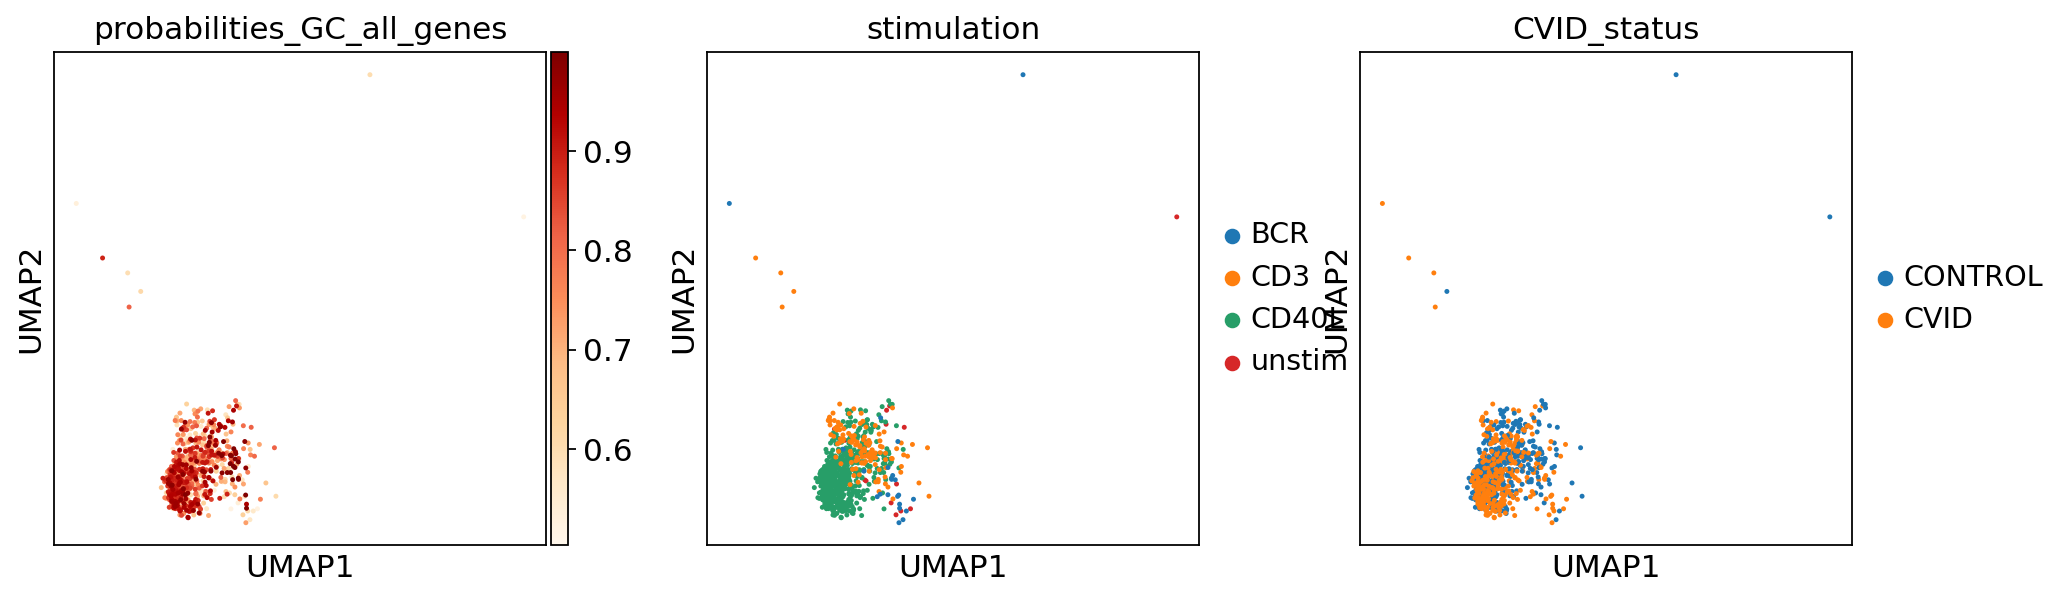

In [68]:
sc.pl.umap(adata_hvg_twins_GC_B_cells[adata_hvg_twins_GC_B_cells.obs['GC_celltype_predictions_all_genes'] == 'GC_B_cells'],
           color=['probabilities_GC_all_genes','stimulation','CVID_status'], cmap='OrRd',
          size=20)

In [81]:
# what about a scanpy test?
adata_hvg_twins_GC_B_cells

AnnData object with n_obs × n_vars = 717 × 2696
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-

In [82]:
# quick DE
sc.tl.rank_genes_groups(adata_hvg_twins_GC_B_cells, groupby='CVID_status', n_genes=100000, use_raw=True)

ranking genes


... storing 'GC_celltype_predictions_all_genes' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


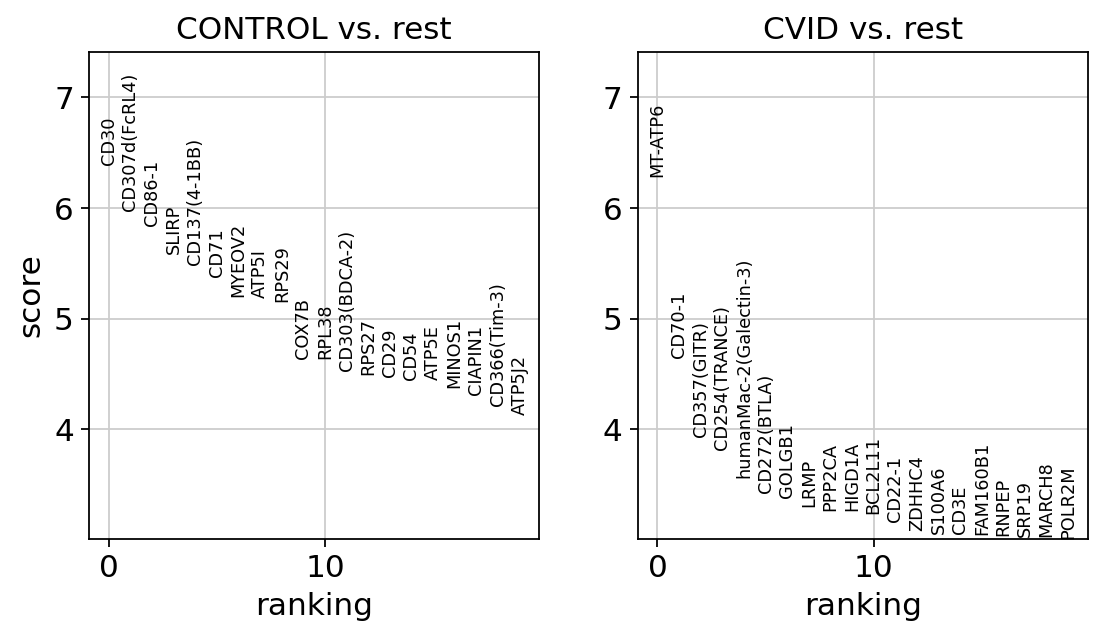

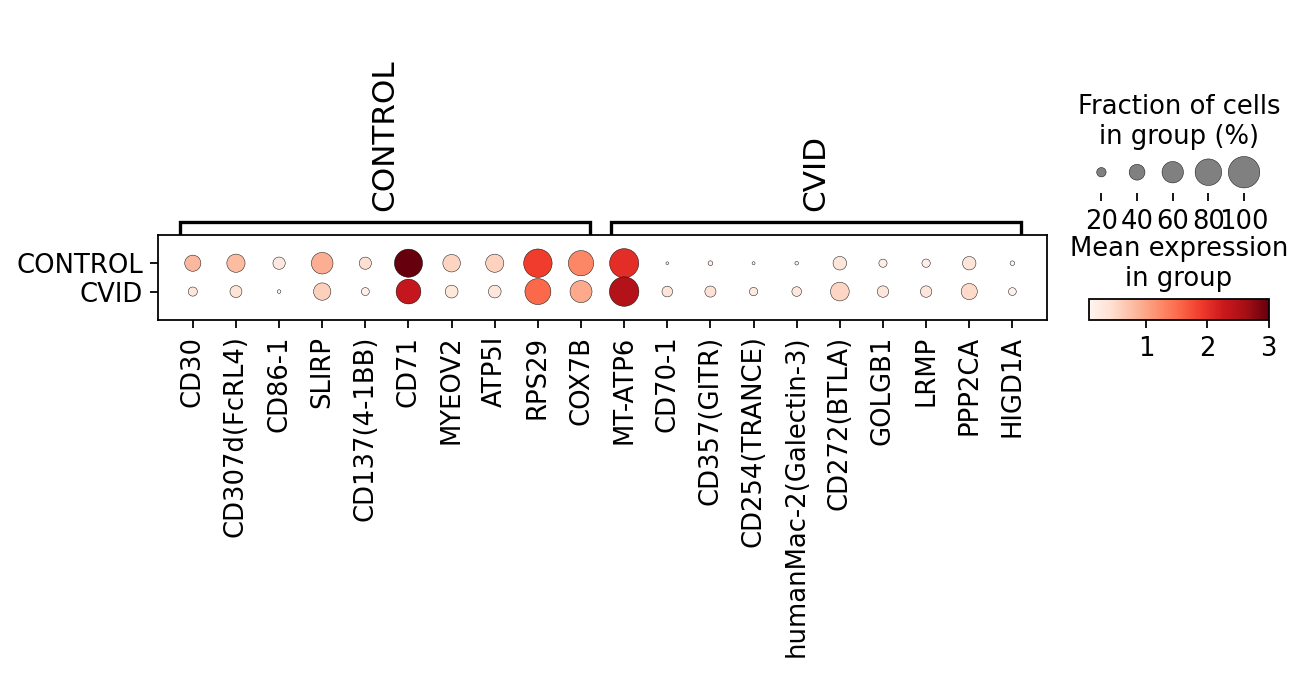

In [83]:
# marker visualisation
sc.pl.rank_genes_groups(adata_hvg_twins_GC_B_cells, n_genes=20)
sc.pl.rank_genes_groups_dotplot(adata_hvg_twins_GC_B_cells, n_genes=10, dendrogram=False)

In [89]:
list(adata_hvg_twins_GC_B_cells.uns['rank_genes_groups']['names'])

[('CD30', 'MT-ATP6'),
 ('CD307d(FcRL4)', 'CD70-1'),
 ('CD86-1', 'CD357(GITR)'),
 ('SLIRP', 'CD254(TRANCE)'),
 ('CD137(4-1BB)', 'humanMac-2(Galectin-3)'),
 ('CD71', 'CD272(BTLA)'),
 ('MYEOV2', 'GOLGB1'),
 ('ATP5I', 'LRMP'),
 ('RPS29', 'PPP2CA'),
 ('COX7B', 'HIGD1A'),
 ('RPL38', 'BCL2L11'),
 ('CD303(BDCA-2)', 'CD22-1'),
 ('RPS27', 'ZDHHC4'),
 ('CD29', 'S100A6'),
 ('CD54', 'CD3E'),
 ('ATP5E', 'FAM160B1'),
 ('MINOS1', 'RNPEP'),
 ('CIAPIN1', 'SRP19'),
 ('CD366(Tim-3)', 'MARCH8'),
 ('ATP5J2', 'POLR2M'),
 ('PRMT6', 'SMIM14'),
 ('Podoplanin', 'WIPF1'),
 ('CD45RO', 'VWA9'),
 ('CHCHD4', 'HSD17B8'),
 ('AGTPBP1', 'CD44'),
 ('CD66a/c/e', 'HNRNPUL2-BSCL2'),
 ('HLA-DR', 'CLK4'),
 ('RPL37', 'CD96(TACTILE)'),
 ('SNRPB', 'IGKV2-29'),
 ('TMEM258', 'COPB1'),
 ('CD314(NKG2D)', 'IL17F'),
 ('C19orf70', 'CHI3L1'),
 ('TMSB10', 'ALDH16A1'),
 ('RPL27', 'HIST1H1B'),
 ('RPL37A', 'BROX'),
 ('CD279(PD-1)', 'PIP4K2A'),
 ('CD99-1', 'CCL2'),
 ('NDUFA1', 'NME3'),
 ('CD1a', 'CRTC3'),
 ('CD274(B7-H1)', 'TNFAIP1'),
 ('PA2G

In [91]:
adata_hvg_twins_GC_B_cells.uns['rank_genes_groups']['pvals_adj']

rec.array([(6.47255711e-06, 7.11879090e-06),
           (2.75122402e-05, 7.50097472e-03),
           (4.38757696e-05, 8.01554888e-02), ...,
           (8.01554888e-02, 4.38757696e-05),
           (7.50097472e-03, 2.75122402e-05),
           (7.11879090e-06, 6.47255711e-06)],
          dtype=[('CONTROL', '<f8'), ('CVID', '<f8')])

In [37]:
DE_GC_B_cells_twins[DE_GC_B_cells_twins['adj.P.Val'] < 0.05]

logFC       P.Value  adj.P.Val  AveExpr_cluster  \
Gene                                                                
MT-ATP6        0.476095  3.203499e-10   0.000005         2.507222   
CD30          -0.492353  2.649774e-09   0.000019         0.337399   
CD307d(FcRL4) -0.416015  1.688049e-08   0.000081         0.380037   
SLIRP         -0.327802  5.987382e-08   0.000196         0.600661   
CD71          -0.669422  6.838057e-08   0.000196         2.336679   
CD86-1        -0.228356  8.941223e-08   0.000213         0.081073   
RPS29         -0.356730  1.729230e-07   0.000354         1.545343   
ATP5I         -0.240089  5.209581e-07   0.000923         0.335771   
CD70-1         0.270720  5.929315e-07   0.000923         0.365457   
MYEOV2        -0.232839  6.523644e-07   0.000923         0.326444   
CD137(4-1BB)  -0.274868  7.089410e-07   0.000923         0.164460   
RPL38         -0.318973  2.870636e-06   0.003427         1.568951   
COX7B         -0.295329  3.916508e-06   0.004315         0.966747   
RPS27         -0.289442  5.614755e-06   0.005395         2.579195   
CD54          -0.483529  5.650000e-06   0.005395         3.207590   
ATP5E         -0.308703  9.008831e-06   0.008065         1.429932   
MINOS1        -0.257744  1.398032e-05   0.011780         0.782607   
CD303(BDCA-2) -0.281650  2.024803e-05   0.016113         0.303866   
CD29          -0.132602  2.514511e-05   0.018807         0.062487   
CD254(TRANCE)  0.188056  2.625979e-05   0.018807         0.256521   
ATP5J2        -0.266271  3.284348e-05   0.022038         1.031972   
CIAPIN1       -0.178040  3.384705e-05   0.022038         0.273484   
CD357(GITR)    0.234535  3.941722e-05   0.024548         0.401296   
CD45RO        -0.260604  7.962137e-05   0.047521         0.295684   

               AveExpr_rest  percentExpr_cluster  percentExpr_rest  
Gene                                                                
MT-ATP6            2.031127             0.916944          0.903846  
CD30               0.829752             0.192691          0.411058  
CD307d(FcRL4)      0.796052             0.275748          0.483173  
SLIRP              0.928463             0.451827          0.605769  
CD71               3.006101             0.727575          0.860577  
CD86-1             0.309430             0.056478          0.286058  
RPS29              1.902074             0.774086          0.875000  
ATP5I              0.575861             0.299003          0.480769  
CD70-1             0.094737             0.235880          0.038462  
MYEOV2             0.559283             0.302326          0.459135  
CD137(4-1BB)       0.439328             0.159468          0.283654  
RPL38              1.887924             0.787375          0.865385  
COX7B              1.262075             0.621262          0.747596  
RPS27              2.868637             0.920266          0.947115  
CD54               3.691119             0.867110          0.942308  
ATP5E              1.738635             0.744186          0.822115  
MINOS1             1.040352             0.564784          0.697115  
CD303(BDCA-2)      0.585517             0.225914          0.365385  
CD29               0.195090             0.036545          0.228365  
CD254(TRANCE)      0.068465             0.169435          0.043269  
ATP5J2             1.298244             0.634551          0.766827  
CIAPIN1            0.451524             0.259136          0.391827  
CD357(GITR)        0.166760             0.249169          0.079327  
CD45RO             0.556288             0.149502          0.384615

In [26]:
# validation cohort
DE_GC_B_cells_validation_cohort = pd.read_csv('./limma_DEG/validation_cohort/20210112_B_cells_naive_CD40L_CVID_vs_B_cells_naive_CD40L_CONTROL_limma_DEGs.csv',
                                             index_col=0)

In [27]:
DE_GC_B_cells_validation_cohort.loc[GC_B_cells_twins_upreg]

logFC       P.Value     adj.P.Val  AveExpr_cluster  \
Gene                                                               
RPS10     -0.077794  6.463737e-07  3.492726e-05         3.397757   
LGALS9     0.118805  7.178082e-10  9.159331e-08         0.414016   
FCRLA      0.094630  2.949690e-05  8.779439e-04         0.674315   
CD52       0.240070  6.157404e-19  4.658076e-16         0.954578   
POU2AF1    0.081290  5.111886e-04  9.393866e-03         0.734300   
CD79B      0.213225  5.761428e-17  3.268890e-14         0.958185   
BLK        0.030953  5.764676e-02  3.062126e-01         0.305801   
SYK        0.083248  2.821352e-05  8.480871e-04         0.519675   
CCR6       0.026066  1.240944e-02  1.110975e-01         0.119376   
CD180     -0.011754  4.164652e-01  6.796860e-01         0.217378   
PTPN1      0.101630  3.301897e-05  9.669231e-04         1.541481   
CD81       0.041231  1.804792e-03  2.552010e-02         0.196260   
TNFRSF13B  0.023126  2.787088e-01  6.073245e-01         0.474426   

           AveExpr_rest  percentExpr_cluster  percentExpr_rest  
Gene                                                            
RPS10          3.475551             0.994114          0.991545  
LGALS9         0.295211             0.442483          0.398155  
FCRLA          0.579685             0.619583          0.588009  
CD52           0.714508             0.721241          0.649500  
POU2AF1        0.653010             0.648475          0.660261  
CD79B          0.744960             0.748529          0.687932  
BLK            0.274848             0.387908          0.389700  
SYK            0.436428             0.541466          0.543428  
CCR6           0.093311             0.174960          0.164489  
CD180          0.229132             0.305511          0.344350  
PTPN1          1.439850             0.898341          0.896234  
CD81           0.155028             0.266988          0.249808  
TNFRSF13B      0.451300             0.463349          0.457341

In [29]:
DE_GC_B_cells_validation_cohort.loc[GC_B_cells_twins_downreg]

logFC       P.Value     adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                          
CXCL10 -0.043515  1.778446e-02  1.433813e-01         0.156089      0.199604   
CXCL9  -0.030229  6.725429e-02  3.364959e-01         0.137596      0.167826   
ATP5D  -0.102088  9.785712e-06  3.456603e-04         1.721755      1.823843   
CCL22  -0.030600  7.762415e-03  7.853567e-02         0.069034      0.099634   
CCND2  -0.254249  5.989570e-23  9.062219e-20         0.605255      0.859504   
TRAF1  -0.076223  8.587715e-04  1.434393e-02         0.550249      0.626472   
IFNGR2  0.041464  3.055154e-02  2.077114e-01         0.475701      0.434237   
BCL2A1 -0.096117  1.015624e-04  2.508798e-03         0.638553      0.734669   
TNF    -0.036498  1.398802e-03  2.107606e-02         0.104016      0.140514   
IRF4   -0.017913  1.287040e-01  4.696152e-01         0.123981      0.141894   
RELB   -0.009900  5.718780e-01  7.912104e-01         0.386859      0.396759   
NFKBIA  0.075867  2.593664e-03  3.378089e-02         2.009083      1.933216   
PRDM1  -0.009365  5.957473e-02  3.122514e-01         0.017737      0.027102   
CD40   -0.079075  1.374549e-03  2.090144e-02         1.063818      1.142893   

        percentExpr_cluster  percentExpr_rest  
Gene                                           
CXCL10             0.127876          0.165257  
CXCL9              0.131621          0.151422  
ATP5D              0.912253          0.930822  
CCL22              0.077047          0.108378  
CCND2              0.545211          0.692544  
TRAF1              0.532370          0.605688  
IFNGR2             0.539861          0.537279  
BCL2A1             0.575174          0.646426  
TNF                0.146602          0.209839  
IRF4               0.175495          0.221368  
RELB               0.471910          0.522675  
NFKBIA             0.953451          0.953113  
PRDM1              0.029428          0.039201  
CD40               0.794007          0.847809

In [31]:
# old DE for twins only
DE_GC_B_cells_twins_old = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/CVID/GitHub_to_post/CVID_old_full/scTranscriptomics/10X_B_cells_DE_limma/GC_B_cells_CVID_vs_GC_B_cells_CONTROL_limma_DEGs.csv',
                                    index_col=0)

In [32]:
DE_GC_B_cells_twins_old.loc[GC_B_cells_twins_upreg]

logFC       P.Value     adj.P.Val  AveExpr_cluster  \
Gene                                                               
RPS10      0.457580  7.684170e-34  3.082313e-30         1.336505   
LGALS9     0.328538  1.481445e-28  3.395683e-25         0.565073   
FCRLA      0.398977  5.616976e-27  9.012438e-24         0.913276   
CD52       0.399403  9.287707e-23  8.765956e-20         1.091409   
POU2AF1    0.378418  2.881243e-22  2.433134e-19         1.040262   
CD79B      0.378789  3.490920e-20  1.867061e-17         1.152017   
BLK        0.273883  1.531399e-16  4.095216e-14         0.697564   
SYK        0.229221  1.486191e-13  2.020842e-11         0.598759   
CCR6       0.157778  2.991964e-12  3.221883e-10         0.275061   
CD180      0.126580  1.709298e-06  3.798635e-05         0.356187   
PTPN1      0.205662  2.412030e-07  7.112342e-06         1.538812   
CD81       0.088999  1.151556e-04  1.313199e-03         0.283326   
TNFRSF13B  0.149564  5.763188e-06  1.111422e-04         0.583943   

           AveExpr_rest  percentExpr_cluster  percentExpr_rest  
Gene                                                            
RPS10          0.878925             0.789416          0.548023  
LGALS9         0.236535             0.470783          0.188701  
FCRLA          0.514299             0.620728          0.359322  
CD52           0.692006             0.674752          0.445198  
POU2AF1        0.661844             0.681367          0.435028  
CD79B          0.773228             0.724366          0.490395  
BLK            0.423681             0.553473          0.326554  
SYK            0.369538             0.500551          0.305085  
CCR6           0.117283             0.252481          0.108475  
CD180          0.229606             0.329658          0.196610  
PTPN1          1.333150             0.829107          0.707345  
CD81           0.194327             0.292172          0.174011  
TNFRSF13B      0.434379             0.441014          0.314124

In [33]:
DE_GC_B_cells_twins_old.loc[GC_B_cells_twins_downreg]

logFC       P.Value     adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                          
CXCL10 -0.622998  1.924466e-30  6.175611e-27         0.448894      1.071892   
CXCL9  -0.542837  2.347815e-28  4.708836e-25         0.350880      0.893718   
ATP5D  -0.406209  6.444156e-29  1.723275e-25         0.365411      0.771620   
CCL22  -0.436937  3.852021e-27  6.867298e-24         0.212998      0.649935   
CCND2  -0.404164  1.800776e-19  9.029203e-17         0.846086      1.250250   
TRAF1  -0.360384  4.609835e-16  1.155700e-13         0.870512      1.230896   
IFNGR2 -0.221710  2.655337e-17  9.064868e-15         0.184769      0.406479   
BCL2A1 -0.364732  6.804466e-15  1.314253e-12         0.884229      1.248961   
TNF    -0.269065  2.850303e-11  2.492026e-09         0.423347      0.692412   
IRF4   -0.236721  4.604457e-11  3.788642e-09         0.391838      0.628559   
RELB   -0.167726  1.886204e-10  1.333222e-08         0.215930      0.383656   
NFKBIA -0.253722  7.294190e-10  4.518737e-08         1.029494      1.283216   
PRDM1  -0.061141  3.515527e-04  3.294780e-03         0.055276      0.116417   
CD40   -0.133730  2.479148e-04  2.464556e-03         1.622950      1.756680   

        percentExpr_cluster  percentExpr_rest  
Gene                                           
CXCL10             0.194046          0.435028  
CXCL9              0.165380          0.376271  
ATP5D              0.348401          0.430508  
CCL22              0.117971          0.318644  
CCND2              0.557883          0.670056  
TRAF1              0.592062          0.676836  
IFNGR2             0.189636          0.318644  
BCL2A1             0.579934          0.644068  
TNF                0.299890          0.389831  
IRF4               0.327453          0.409040  
RELB               0.214994          0.314124  
NFKBIA             0.707828          0.667797  
PRDM1              0.048512          0.088136  
CD40               0.890849          0.880226

In [112]:
# what if we just see how many DE genes are in some important T cell compartments?
np.unique(adata_hvg_twins.obs['cell_type_final'], return_counts=True)

(array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
        'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
        'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
        'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
        'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
        'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
        'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object),
 array([ 619, 1305,  275,  185,  266, 2160, 1194,  200,   75,  121,  158,
         192,   64, 1262, 1201,  857,  168,  520,  321,  305,  404,  145,
           8]))

In [121]:
# let's see for T_cells_CD4+_activated, T_cells_CD4+_memory and T_cells_CD4+_naive compartments

DE_limma_twins_new = {}

CD4_T_cell_clusters_new = ['T_cells_CD4+_activated', 'T_cells_CD4+_memory', 'T_cells_CD4+_naive']

print('NEW twins data')

for  ct in CD4_T_cell_clusters_new:
    print(ct)
    DE_limma_twins_new[ct] = pd.read_csv('./limma_DEG/twins_only/20210112_' + ct + '_CVID_vs_' + ct + '_CONTROL_limma_DEGs.csv',
                                        index_col=0)
    # taking only significant DEGs
    DE_limma_twins_new[ct] = DE_limma_twins_new[ct][DE_limma_twins_new[ct]['adj.P.Val'] < 0.05]
    print('number of significant DEGs:', DE_limma_twins_new[ct].shape[0], '\n')


NEW twins data
T_cells_CD4+_activated
number of significant DEGs: 695 

T_cells_CD4+_memory
number of significant DEGs: 69 

T_cells_CD4+_naive
number of significant DEGs: 26 



In [123]:
# let's see for T_cells_CD4+_activated, T_cells_CD4+_memory and T_cells_CD4+_naive compartments

DE_limma_twins_old = {}

# same just different names
CD4_T_cell_clusters_old = ['Activated_CD4+_T_cells', 'Memory_CD4+_T_cells', 'Naive_CD4+_T_cells']

print('OLD twins data')

for  ct in CD4_T_cell_clusters_old:
    print(ct)
    DE_limma_twins_old[ct] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/CVID/GitHub_to_post/CVID_old_full/scTranscriptomics/10X_DE_limma/' + ct + '_CVID_vs_' + ct + '_CONTROL_limma_DEGs.csv',
                                        index_col=0)
    # taking only significant DEGs
    DE_limma_twins_old[ct] = DE_limma_twins_old[ct][DE_limma_twins_old[ct]['adj.P.Val'] < 0.05]
    print('number of significant DEGs here:', DE_limma_twins_old[ct].shape[0], '\n')


OLD twins data
Activated_CD4+_T_cells
number of significant DEGs here: 3212 

Memory_CD4+_T_cells
number of significant DEGs here: 411 

Naive_CD4+_T_cells
number of significant DEGs here: 186 



In [129]:
'CD40LG' in DE_limma_twins_old['Activated_CD4+_T_cells'].index

True

In [131]:
DE_limma_twins_old['Activated_CD4+_T_cells'].loc['CD40LG']

logFC                 -2.750294e-01
P.Value                2.672521e-13
adj.P.Val              2.688491e-11
AveExpr_cluster        6.443090e-01
AveExpr_rest           9.193380e-01
percentExpr_cluster    4.390980e-01
percentExpr_rest       5.794680e-01
Name: CD40LG, dtype: float64

In [133]:
'CD40LG' in DE_limma_twins_new['T_cells_CD4+_activated'].index

False

In [134]:
'CD40LG' in DE_limma_twins_new['T_cells_CD4+_naive'].index

False

In [135]:
'CD40LG' in DE_limma_twins_new['T_cells_CD4+_memory'].index

False

In [153]:
adata_hvg_twins.var['feature_types-0'].value_counts()

Gene Expression     2553
Antibody Capture     137
nan                    6
Name: feature_types-0, dtype: int64

In [185]:
adata_hvg_twins_B_cells = adata_hvg_twins[adata_hvg_twins.obs['cell_type_final'].isin(['B_cells_naive','B_cells_memory'])].copy()

In [ ]:
adata_hvg_twins_GC_B_cells

In [ ]:
# what is the distribution of cells from twins in each stimulation


In [192]:
df_stats = pd.DataFrame(columns=list(np.unique(adata_hvg_twins_GC_B_cells.obs['CVID_status'])),
                     index=list(np.unique(adata_hvg_twins_GC_B_cells.obs['stimulation'])))

In [193]:
df_stats

CONTROL CVID
BCR        NaN  NaN
CD3        NaN  NaN
CD40L      NaN  NaN
unstim     NaN  NaN

In [194]:
for condition in df_stats.columns:
    print('condition', condition)
    for stimulation in df_stats.index:
        #print(sample)
        df_stats.loc[stimulation, condition] = adata_hvg_twins_GC_B_cells[(adata_hvg_twins_GC_B_cells.obs['stimulation'] == stimulation)
                                         & (adata_hvg_twins_GC_B_cells.obs['CVID_status'] == condition)].X.shape[0]

condition CONTROL
condition CVID


In [195]:
df_stats

CONTROL  CVID
BCR           7    14
CD3          67    56
CD40L       335   223
unstim        7     8

In [196]:
#cols_new_order = [str(i) for i in range(1,22)]
#df_new = df_new[cols_new_order]
#df_new

Text(0.5, 0, 'stimulation')

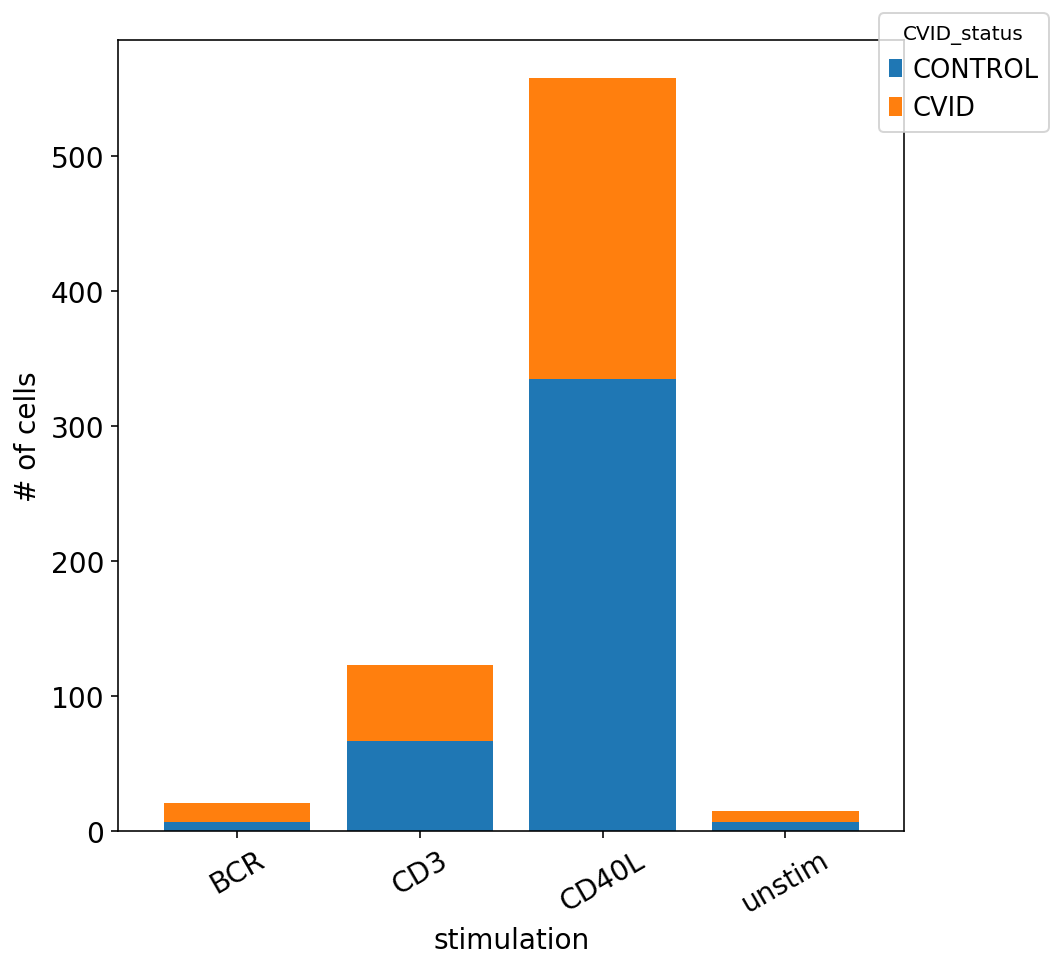

In [197]:
# this is for final cells only

ax = df_stats.plot.bar(stacked=True, figsize=(7,7), width=0.8)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles,
          labels, title='CVID_status',
          bbox_to_anchor=(1.20, 1.05))

ax.set_xticklabels(labels=['BCR',
                           'CD3',
                           'CD40L',
                           'unstim'])
ax.tick_params(axis='x', rotation=30)

# to turn off the grid
plt.grid(b=None)

#plt.title('CITE-seq sample composition')
plt.ylabel('# of cells')
plt.xlabel('stimulation')

#plt.savefig('./figures/CITE-seq_sample_composition_all_samples_final_cells_20210112.pdf',
#           bbox_inches='tight')

# TWINS only

## B cells (naive and memory only) by activation

In [60]:
# creating also the full object (all genes) - only normalised and log transformed
adata_full = anndata.AnnData(X=adata_hvg_twins.raw.X,
                            obs=adata_hvg_twins.obs,
                            var=adata_hvg_twins.raw.var,
                            obsm=adata_hvg_twins.obsm)

In [61]:
np.unique(adata_full.obs['donor'])

array(['CONTROL_twin', 'CVID_twin'], dtype=object)

In [62]:
adata_full

AnnData object with n_obs × n_vars = 12005 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_i

In [63]:
np.unique(adata_full.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [64]:
adata_full.obs['celltype_condition'] = [i + '_' + j for i,j in zip(adata_full.obs['cell_type_final'], adata_full.obs['CVID_status'])]

In [65]:
np.unique(adata_full.obs['celltype_condition'])

array(['B_cells_memory_CONTROL', 'B_cells_memory_CVID',
       'B_cells_naive_CONTROL', 'B_cells_naive_CVID',
       'MAIT_cells_CONTROL', 'MAIT_cells_CVID', 'Macrophages_CONTROL',
       'Macrophages_CVID', 'Monocytes_CD16+_CONTROL',
       'Monocytes_CD16+_CVID', 'Monocytes_Classical_CONTROL',
       'Monocytes_Classical_CVID', 'NK_CD16_bright_CONTROL',
       'NK_CD16_bright_CVID', 'NK_CD56_bright_CONTROL',
       'NK_CD56_bright_CVID', 'Plasma_cells_CONTROL', 'Plasma_cells_CVID',
       'Precursor_Cells_CONTROL', 'Precursor_Cells_CVID',
       'TCM_CD8+_CONTROL', 'TCM_CD8+_CVID', 'TEM_CD8+_CONTROL',
       'TEM_CD8+_CVID', 'TMRA_CD8+_CONTROL', 'TMRA_CD8+_CVID',
       'T_cells_CD4+_activated_CONTROL', 'T_cells_CD4+_activated_CVID',
       'T_cells_CD4+_memory_CONTROL', 'T_cells_CD4+_memory_CVID',
       'T_cells_CD4+_naive_CONTROL', 'T_cells_CD4+_naive_CVID',
       'T_cells_CD8+_activated_CONTROL', 'T_cells_CD8+_activated_CVID',
       'T_cells_CD8+_naive_CONTROL', 'T_cells_CD8+_n

In [68]:
adata_full_naive_memory_B_cells = adata_full[adata_full.obs['cell_type_final'].isin(['B_cells_memory', 'B_cells_naive'])].copy()
adata_full_naive_memory_B_cells.obs['stimulation_condition'] = [i + '_' + j for i,j in zip(adata_full_naive_memory_B_cells.obs['stimulation'], 
                                                                                           adata_full_naive_memory_B_cells.obs['CVID_status'])]

In [69]:
np.unique(adata_full_naive_memory_B_cells.obs['stimulation_condition'],
         return_counts=True)

(array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
        'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
       dtype=object), array([354, 247,  93,  83, 442, 304, 202, 199]))

In [70]:
np.unique(adata_full_naive_memory_B_cells.obs['cell_type_final'],
         return_counts=True)

(array(['B_cells_memory', 'B_cells_naive'], dtype=object), array([ 619, 1305]))

In [71]:
# marker calling

#t = adata_hvg.X.toarray().T
t = adata_full_naive_memory_B_cells.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_full_naive_memory_B_cells.obs.index, index=adata_full_naive_memory_B_cells.var_names)

meta_df = pd.DataFrame(data={'Cell':list(adata_full_naive_memory_B_cells.obs.index),
                             'cell_type':[ str(i) for i in adata_full_naive_memory_B_cells.obs['stimulation_condition']],
                             'sample':[ str(i) for i in adata_full_naive_memory_B_cells.obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [72]:
meta_df

cell_type  \
Cell                                   
AAACCTGGTAGCGATG-1    unstim_CONTROL   
AAAGATGCATTGCGGC-1    unstim_CONTROL   
AAAGATGGTGGTGTAG-1    unstim_CONTROL   
AAATGCCGTACCCAAT-1    unstim_CONTROL   
AACACGTCAACCGCCA-1    unstim_CONTROL   
...                              ...   
TTCTACAGTTGGTGGA-1-1        BCR_CVID   
TTGACTTAGGCACATG-1          BCR_CVID   
TTGACTTTCTAACGGT-1-1        BCR_CVID   
TTTACTGGTCCGAGTC-1          BCR_CVID   
TTTGTCAAGCTCCTCT-1          BCR_CVID   

                                                               sample  
Cell                                                                   
AAACCTGGTAGCGATG-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAAGATGCATTGCGGC-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAAGATGGTGGTGTAG-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAATGCCGTACCCAAT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AACACGTCAACCGCCA-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                               ...  
TTCTACAGTTGGTGGA-1-1  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
TTGACTTAGGCACATG-1    35008_CV005_RV9039265_and_35008_CV005_RV9039289  
TTGACTTTCTAACGGT-1-1  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
TTTACTGGTCCGAGTC-1    35008_CV005_RV9039265_and_35008_CV005_RV9039289  
TTTGTCAAGCTCCTCT-1    35008_CV005_RV9039265_and_35008_CV005_RV9039289  

[1924 rows x 2 columns]

In [73]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
        'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
       dtype=object), array([354, 247,  93,  83, 442, 304, 202, 199]))

In [74]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [75]:
outpath = './limma_DEG/twins_only/'

In [76]:
%%R
library(limma)
library(edgeR)

In [77]:
meta_df.reset_index(inplace=True)

In [78]:
meta_df

Cell       cell_type  \
0       AAACCTGGTAGCGATG-1  unstim_CONTROL   
1       AAAGATGCATTGCGGC-1  unstim_CONTROL   
2       AAAGATGGTGGTGTAG-1  unstim_CONTROL   
3       AAATGCCGTACCCAAT-1  unstim_CONTROL   
4       AACACGTCAACCGCCA-1  unstim_CONTROL   
...                    ...             ...   
1919  TTCTACAGTTGGTGGA-1-1        BCR_CVID   
1920    TTGACTTAGGCACATG-1        BCR_CVID   
1921  TTGACTTTCTAACGGT-1-1        BCR_CVID   
1922    TTTACTGGTCCGAGTC-1        BCR_CVID   
1923    TTTGTCAAGCTCCTCT-1        BCR_CVID   

                                               sample  
0     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                               ...  
1919  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1920  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1921  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1922  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1923  35008_CV005_RV9039265_and_35008_CV005_RV9039289  

[1924 rows x 3 columns]

In [79]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [80]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [81]:
meta_df

Cell       cell_type  \
0       AAACCTGGTAGCGATG.1  unstim_CONTROL   
1       AAAGATGCATTGCGGC.1  unstim_CONTROL   
2       AAAGATGGTGGTGTAG.1  unstim_CONTROL   
3       AAATGCCGTACCCAAT.1  unstim_CONTROL   
4       AACACGTCAACCGCCA.1  unstim_CONTROL   
...                    ...             ...   
1919  TTCTACAGTTGGTGGA.1.1        BCR_CVID   
1920    TTGACTTAGGCACATG.1        BCR_CVID   
1921  TTGACTTTCTAACGGT.1.1        BCR_CVID   
1922    TTTACTGGTCCGAGTC.1        BCR_CVID   
1923    TTTGTCAAGCTCCTCT.1        BCR_CVID   

                                               sample  
0     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                               ...  
1919  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1920  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1921  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1922  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1923  35008_CV005_RV9039265_and_35008_CV005_RV9039289  

[1924 rows x 3 columns]

In [82]:
df

AAACCTGGTAGCGATG-1  AAAGATGCATTGCGGC-1  \
A1BG                                   0.0                 0.0   
A1BG-AS1                               0.0                 0.0   
A2M                                    0.0                 0.0   
A2M-AS1                                0.0                 0.0   
A2ML1                                  0.0                 0.0   
...                                    ...                 ...   
bP-2189O9.3                            0.0                 0.0   
humanCD207                             0.0                 0.0   
humanMac-2(Galectin-3)                 0.0                 0.0   
mouse/ratCD278(ICOS)                   0.0                 0.0   
mouseintegrinB7                        0.0                 0.0   

                        AAAGATGGTGGTGTAG-1  AAATGCCGTACCCAAT-1  \
A1BG                                   0.0            0.000000   
A1BG-AS1                               0.0            0.000000   
A2M                                    0.0            0.000000   
A2M-AS1                                0.0            0.000000   
A2ML1                                  0.0            0.000000   
...                                    ...                 ...   
bP-2189O9.3                            0.0            0.000000   
humanCD207                             0.0            0.000000   
humanMac-2(Galectin-3)                 0.0            0.000000   
mouse/ratCD278(ICOS)                   0.0            0.000000   
mouseintegrinB7                        0.0            1.943141   

                        AACACGTCAACCGCCA-1  AACCATGCATTACCTT-1  \
A1BG                              0.000000            0.000000   
A1BG-AS1                          0.000000            0.000000   
A2M                               0.000000            0.000000   
A2M-AS1                           0.000000            0.000000   
A2ML1                             0.000000            0.000000   
...                                    ...                 ...   
bP-2189O9.3                       0.000000            0.000000   
humanCD207                        0.000000            0.000000   
humanMac-2(Galectin-3)            2.579373            3.075778   
mouse/ratCD278(ICOS)              0.000000            0.000000   
mouseintegrinB7                   1.906618            0.000000   

                        AAGACCTAGTCGTACT-1  AAGCCGCAGAGCTGCA-1  \
A1BG                                   0.0            0.000000   
A1BG-AS1                               0.0            0.000000   
A2M                                    0.0            0.000000   
A2M-AS1                                0.0            0.000000   
A2ML1                                  0.0            0.000000   
...                                    ...                 ...   
bP-2189O9.3                            0.0            0.000000   
humanCD207                             0.0            0.000000   
humanMac-2(Galectin-3)                 0.0            0.000000   
mouse/ratCD278(ICOS)                   0.0            0.000000   
mouseintegrinB7                        0.0            2.122482   

                        AAGCCGCCATGAAGTA-1  AAGGCAGGTAGCACGA-1  ...  \
A1BG                              0.000000                 0.0  ...   
A1BG-AS1                          0.000000                 0.0  ...   
A2M                               0.000000                 0.0  ...   
A2M-AS1                           0.000000                 0.0  ...   
A2ML1                             0.000000                 0.0  ...   
...                                    ...                 ...  ...   
bP-2189O9.3                       0.000000                 0.0  ...   
humanCD207                        0.000000                 0.0  ...   
humanMac-2(Galectin-3)            0.000000                 0.0  ...   
mouse/ratCD278(ICOS)              0.000000                 0.0  ...   
mouseintegrinB7                   2.959025                 0.0  ...   


In [84]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
        'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
       dtype=object), array([354, 247,  93,  83, 442, 304, 202, 199]))

In [85]:
np.unique(adata_full_naive_memory_B_cells.obs['stimulation_condition'])

array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
       'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
      dtype=object)

In [86]:
case = 'BCR_CVID'
ctrl = 'BCR_CONTROL'

In [87]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "BCR_CONTROL" "BCR_CVID"   


R[write to console]: 601 shared cells



[1] "ctrl" "case"


In [88]:
case = 'CD3_CVID'
ctrl = 'CD3_CONTROL'

In [89]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "CD3_CONTROL" "CD3_CVID"   


R[write to console]: 176 shared cells



[1] "ctrl" "case"


In [90]:
case = 'CD40L_CVID'
ctrl = 'CD40L_CONTROL'

In [91]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "CD40L_CONTROL" "CD40L_CVID"   


R[write to console]: 746 shared cells



[1] "ctrl" "case"


In [92]:
case = 'unstim_CVID'
ctrl = 'unstim_CONTROL'

In [93]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "unstim_CONTROL" "unstim_CVID"   


R[write to console]: 401 shared cells



[1] "ctrl" "case"


# TWINS only

## B cells (naive and memory only) by cell_type + activation key

In [94]:
# creating also the full object (all genes) - only normalised and log transformed
adata_full = anndata.AnnData(X=adata_hvg_twins.raw.X,
                            obs=adata_hvg_twins.obs,
                            var=adata_hvg_twins.raw.var,
                            obsm=adata_hvg_twins.obsm)

In [95]:
np.unique(adata_full.obs['donor'])

array(['CONTROL_twin', 'CVID_twin'], dtype=object)

In [96]:
adata_full

AnnData object with n_obs × n_vars = 12005 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_i

In [97]:
np.unique(adata_full.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [98]:
adata_full.obs['celltype_condition'] = [i + '_' + j for i,j in zip(adata_full.obs['cell_type_final'], adata_full.obs['CVID_status'])]

In [99]:
np.unique(adata_full.obs['celltype_condition'])

array(['B_cells_memory_CONTROL', 'B_cells_memory_CVID',
       'B_cells_naive_CONTROL', 'B_cells_naive_CVID',
       'MAIT_cells_CONTROL', 'MAIT_cells_CVID', 'Macrophages_CONTROL',
       'Macrophages_CVID', 'Monocytes_CD16+_CONTROL',
       'Monocytes_CD16+_CVID', 'Monocytes_Classical_CONTROL',
       'Monocytes_Classical_CVID', 'NK_CD16_bright_CONTROL',
       'NK_CD16_bright_CVID', 'NK_CD56_bright_CONTROL',
       'NK_CD56_bright_CVID', 'Plasma_cells_CONTROL', 'Plasma_cells_CVID',
       'Precursor_Cells_CONTROL', 'Precursor_Cells_CVID',
       'TCM_CD8+_CONTROL', 'TCM_CD8+_CVID', 'TEM_CD8+_CONTROL',
       'TEM_CD8+_CVID', 'TMRA_CD8+_CONTROL', 'TMRA_CD8+_CVID',
       'T_cells_CD4+_activated_CONTROL', 'T_cells_CD4+_activated_CVID',
       'T_cells_CD4+_memory_CONTROL', 'T_cells_CD4+_memory_CVID',
       'T_cells_CD4+_naive_CONTROL', 'T_cells_CD4+_naive_CVID',
       'T_cells_CD8+_activated_CONTROL', 'T_cells_CD8+_activated_CVID',
       'T_cells_CD8+_naive_CONTROL', 'T_cells_CD8+_n

In [100]:
adata_full_naive_memory_B_cells = adata_full[adata_full.obs['cell_type_final'].isin(['B_cells_memory', 'B_cells_naive'])].copy()
adata_full_naive_memory_B_cells.obs['cell_type_stimulation_condition'] = [i + '_' + j + '_' + k for i,j,k in zip(adata_full_naive_memory_B_cells.obs['cell_type_final'],
                                                                                                                 adata_full_naive_memory_B_cells.obs['stimulation'], 
                                                                                           adata_full_naive_memory_B_cells.obs['CVID_status'])]

In [101]:
np.unique(adata_full_naive_memory_B_cells.obs['cell_type_stimulation_condition'],
         return_counts=True)

(array(['B_cells_memory_BCR_CONTROL', 'B_cells_memory_BCR_CVID',
        'B_cells_memory_CD3_CONTROL', 'B_cells_memory_CD3_CVID',
        'B_cells_memory_CD40L_CONTROL', 'B_cells_memory_CD40L_CVID',
        'B_cells_memory_unstim_CONTROL', 'B_cells_memory_unstim_CVID',
        'B_cells_naive_BCR_CONTROL', 'B_cells_naive_BCR_CVID',
        'B_cells_naive_CD3_CONTROL', 'B_cells_naive_CD3_CVID',
        'B_cells_naive_CD40L_CONTROL', 'B_cells_naive_CD40L_CVID',
        'B_cells_naive_unstim_CONTROL', 'B_cells_naive_unstim_CVID'],
       dtype=object),
 array([111,  55,  59,  64, 134,  70,  58,  68, 243, 192,  34,  19, 308,
        234, 144, 131]))

In [102]:
np.unique(adata_full_naive_memory_B_cells.obs['cell_type_final'],
         return_counts=True)

(array(['B_cells_memory', 'B_cells_naive'], dtype=object), array([ 619, 1305]))

In [103]:
# marker calling

#t = adata_hvg.X.toarray().T
t = adata_full_naive_memory_B_cells.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_full_naive_memory_B_cells.obs.index, index=adata_full_naive_memory_B_cells.var_names)

meta_df = pd.DataFrame(data={'Cell':list(adata_full_naive_memory_B_cells.obs.index),
                             'cell_type':[ str(i) for i in adata_full_naive_memory_B_cells.obs['cell_type_stimulation_condition']],
                             'sample':[ str(i) for i in adata_full_naive_memory_B_cells.obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [104]:
meta_df

cell_type  \
Cell                                                 
AAACCTGGTAGCGATG-1    B_cells_naive_unstim_CONTROL   
AAAGATGCATTGCGGC-1    B_cells_naive_unstim_CONTROL   
AAAGATGGTGGTGTAG-1    B_cells_naive_unstim_CONTROL   
AAATGCCGTACCCAAT-1    B_cells_naive_unstim_CONTROL   
AACACGTCAACCGCCA-1    B_cells_naive_unstim_CONTROL   
...                                            ...   
TTCTACAGTTGGTGGA-1-1       B_cells_memory_BCR_CVID   
TTGACTTAGGCACATG-1          B_cells_naive_BCR_CVID   
TTGACTTTCTAACGGT-1-1        B_cells_naive_BCR_CVID   
TTTACTGGTCCGAGTC-1          B_cells_naive_BCR_CVID   
TTTGTCAAGCTCCTCT-1          B_cells_naive_BCR_CVID   

                                                               sample  
Cell                                                                   
AAACCTGGTAGCGATG-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAAGATGCATTGCGGC-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAAGATGGTGGTGTAG-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAATGCCGTACCCAAT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AACACGTCAACCGCCA-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                               ...  
TTCTACAGTTGGTGGA-1-1  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
TTGACTTAGGCACATG-1    35008_CV005_RV9039265_and_35008_CV005_RV9039289  
TTGACTTTCTAACGGT-1-1  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
TTTACTGGTCCGAGTC-1    35008_CV005_RV9039265_and_35008_CV005_RV9039289  
TTTGTCAAGCTCCTCT-1    35008_CV005_RV9039265_and_35008_CV005_RV9039289  

[1924 rows x 2 columns]

In [105]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['B_cells_memory_BCR_CONTROL', 'B_cells_memory_BCR_CVID',
        'B_cells_memory_CD3_CONTROL', 'B_cells_memory_CD3_CVID',
        'B_cells_memory_CD40L_CONTROL', 'B_cells_memory_CD40L_CVID',
        'B_cells_memory_unstim_CONTROL', 'B_cells_memory_unstim_CVID',
        'B_cells_naive_BCR_CONTROL', 'B_cells_naive_BCR_CVID',
        'B_cells_naive_CD3_CONTROL', 'B_cells_naive_CD3_CVID',
        'B_cells_naive_CD40L_CONTROL', 'B_cells_naive_CD40L_CVID',
        'B_cells_naive_unstim_CONTROL', 'B_cells_naive_unstim_CVID'],
       dtype=object),
 array([111,  55,  59,  64, 134,  70,  58,  68, 243, 192,  34,  19, 308,
        234, 144, 131]))

In [106]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [107]:
outpath = './limma_DEG/twins_only/'

In [108]:
%%R
library(limma)
library(edgeR)

In [109]:
meta_df.reset_index(inplace=True)

In [110]:
meta_df

Cell                     cell_type  \
0       AAACCTGGTAGCGATG-1  B_cells_naive_unstim_CONTROL   
1       AAAGATGCATTGCGGC-1  B_cells_naive_unstim_CONTROL   
2       AAAGATGGTGGTGTAG-1  B_cells_naive_unstim_CONTROL   
3       AAATGCCGTACCCAAT-1  B_cells_naive_unstim_CONTROL   
4       AACACGTCAACCGCCA-1  B_cells_naive_unstim_CONTROL   
...                    ...                           ...   
1919  TTCTACAGTTGGTGGA-1-1       B_cells_memory_BCR_CVID   
1920    TTGACTTAGGCACATG-1        B_cells_naive_BCR_CVID   
1921  TTGACTTTCTAACGGT-1-1        B_cells_naive_BCR_CVID   
1922    TTTACTGGTCCGAGTC-1        B_cells_naive_BCR_CVID   
1923    TTTGTCAAGCTCCTCT-1        B_cells_naive_BCR_CVID   

                                               sample  
0     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                               ...  
1919  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1920  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1921  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1922  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1923  35008_CV005_RV9039265_and_35008_CV005_RV9039289  

[1924 rows x 3 columns]

In [111]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [112]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [113]:
meta_df

Cell                     cell_type  \
0       AAACCTGGTAGCGATG.1  B_cells_naive_unstim_CONTROL   
1       AAAGATGCATTGCGGC.1  B_cells_naive_unstim_CONTROL   
2       AAAGATGGTGGTGTAG.1  B_cells_naive_unstim_CONTROL   
3       AAATGCCGTACCCAAT.1  B_cells_naive_unstim_CONTROL   
4       AACACGTCAACCGCCA.1  B_cells_naive_unstim_CONTROL   
...                    ...                           ...   
1919  TTCTACAGTTGGTGGA.1.1       B_cells_memory_BCR_CVID   
1920    TTGACTTAGGCACATG.1        B_cells_naive_BCR_CVID   
1921  TTGACTTTCTAACGGT.1.1        B_cells_naive_BCR_CVID   
1922    TTTACTGGTCCGAGTC.1        B_cells_naive_BCR_CVID   
1923    TTTGTCAAGCTCCTCT.1        B_cells_naive_BCR_CVID   

                                               sample  
0     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                               ...  
1919  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1920  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1921  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1922  35008_CV005_RV9039265_and_35008_CV005_RV9039289  
1923  35008_CV005_RV9039265_and_35008_CV005_RV9039289  

[1924 rows x 3 columns]

In [114]:
df

AAACCTGGTAGCGATG-1  AAAGATGCATTGCGGC-1  \
A1BG                                   0.0                 0.0   
A1BG-AS1                               0.0                 0.0   
A2M                                    0.0                 0.0   
A2M-AS1                                0.0                 0.0   
A2ML1                                  0.0                 0.0   
...                                    ...                 ...   
bP-2189O9.3                            0.0                 0.0   
humanCD207                             0.0                 0.0   
humanMac-2(Galectin-3)                 0.0                 0.0   
mouse/ratCD278(ICOS)                   0.0                 0.0   
mouseintegrinB7                        0.0                 0.0   

                        AAAGATGGTGGTGTAG-1  AAATGCCGTACCCAAT-1  \
A1BG                                   0.0            0.000000   
A1BG-AS1                               0.0            0.000000   
A2M                                    0.0            0.000000   
A2M-AS1                                0.0            0.000000   
A2ML1                                  0.0            0.000000   
...                                    ...                 ...   
bP-2189O9.3                            0.0            0.000000   
humanCD207                             0.0            0.000000   
humanMac-2(Galectin-3)                 0.0            0.000000   
mouse/ratCD278(ICOS)                   0.0            0.000000   
mouseintegrinB7                        0.0            1.943141   

                        AACACGTCAACCGCCA-1  AACCATGCATTACCTT-1  \
A1BG                              0.000000            0.000000   
A1BG-AS1                          0.000000            0.000000   
A2M                               0.000000            0.000000   
A2M-AS1                           0.000000            0.000000   
A2ML1                             0.000000            0.000000   
...                                    ...                 ...   
bP-2189O9.3                       0.000000            0.000000   
humanCD207                        0.000000            0.000000   
humanMac-2(Galectin-3)            2.579373            3.075778   
mouse/ratCD278(ICOS)              0.000000            0.000000   
mouseintegrinB7                   1.906618            0.000000   

                        AAGACCTAGTCGTACT-1  AAGCCGCAGAGCTGCA-1  \
A1BG                                   0.0            0.000000   
A1BG-AS1                               0.0            0.000000   
A2M                                    0.0            0.000000   
A2M-AS1                                0.0            0.000000   
A2ML1                                  0.0            0.000000   
...                                    ...                 ...   
bP-2189O9.3                            0.0            0.000000   
humanCD207                             0.0            0.000000   
humanMac-2(Galectin-3)                 0.0            0.000000   
mouse/ratCD278(ICOS)                   0.0            0.000000   
mouseintegrinB7                        0.0            2.122482   

                        AAGCCGCCATGAAGTA-1  AAGGCAGGTAGCACGA-1  ...  \
A1BG                              0.000000                 0.0  ...   
A1BG-AS1                          0.000000                 0.0  ...   
A2M                               0.000000                 0.0  ...   
A2M-AS1                           0.000000                 0.0  ...   
A2ML1                             0.000000                 0.0  ...   
...                                    ...                 ...  ...   
bP-2189O9.3                       0.000000                 0.0  ...   
humanCD207                        0.000000                 0.0  ...   
humanMac-2(Galectin-3)            0.000000                 0.0  ...   
mouse/ratCD278(ICOS)              0.000000                 0.0  ...   
mouseintegrinB7                   2.959025                 0.0  ...   


In [115]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['B_cells_memory_BCR_CONTROL', 'B_cells_memory_BCR_CVID',
        'B_cells_memory_CD3_CONTROL', 'B_cells_memory_CD3_CVID',
        'B_cells_memory_CD40L_CONTROL', 'B_cells_memory_CD40L_CVID',
        'B_cells_memory_unstim_CONTROL', 'B_cells_memory_unstim_CVID',
        'B_cells_naive_BCR_CONTROL', 'B_cells_naive_BCR_CVID',
        'B_cells_naive_CD3_CONTROL', 'B_cells_naive_CD3_CVID',
        'B_cells_naive_CD40L_CONTROL', 'B_cells_naive_CD40L_CVID',
        'B_cells_naive_unstim_CONTROL', 'B_cells_naive_unstim_CVID'],
       dtype=object),
 array([111,  55,  59,  64, 134,  70,  58,  68, 243, 192,  34,  19, 308,
        234, 144, 131]))

In [116]:
np.unique(adata_full_naive_memory_B_cells.obs['cell_type_stimulation_condition'])

array(['B_cells_memory_BCR_CONTROL', 'B_cells_memory_BCR_CVID',
       'B_cells_memory_CD3_CONTROL', 'B_cells_memory_CD3_CVID',
       'B_cells_memory_CD40L_CONTROL', 'B_cells_memory_CD40L_CVID',
       'B_cells_memory_unstim_CONTROL', 'B_cells_memory_unstim_CVID',
       'B_cells_naive_BCR_CONTROL', 'B_cells_naive_BCR_CVID',
       'B_cells_naive_CD3_CONTROL', 'B_cells_naive_CD3_CVID',
       'B_cells_naive_CD40L_CONTROL', 'B_cells_naive_CD40L_CVID',
       'B_cells_naive_unstim_CONTROL', 'B_cells_naive_unstim_CVID'],
      dtype=object)

In [117]:
case = 'B_cells_memory_BCR_CVID'
ctrl = 'B_cells_memory_BCR_CONTROL'

In [118]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_memory_BCR_CONTROL" "B_cells_memory_BCR_CVID"   


R[write to console]: 166 shared cells



[1] "ctrl" "case"


In [119]:
case = 'B_cells_memory_CD3_CONTROL'
ctrl = 'B_cells_memory_CD3_CVID'

In [120]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_memory_CD3_CONTROL" "B_cells_memory_CD3_CVID"   


R[write to console]: 123 shared cells



[1] "case" "ctrl"


In [121]:
case = 'B_cells_memory_CD40L_CVID'
ctrl = 'B_cells_memory_CD40L_CONTROL'

In [122]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_memory_CD40L_CONTROL" "B_cells_memory_CD40L_CVID"   


R[write to console]: 204 shared cells



[1] "ctrl" "case"


In [123]:
case = 'B_cells_memory_unstim_CVID'
ctrl = 'B_cells_memory_unstim_CONTROL'

In [124]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_memory_unstim_CONTROL" "B_cells_memory_unstim_CVID"   


R[write to console]: 126 shared cells



[1] "ctrl" "case"


In [125]:
case = 'B_cells_naive_BCR_CVID'
ctrl = 'B_cells_naive_BCR_CONTROL'

In [126]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_naive_BCR_CONTROL" "B_cells_naive_BCR_CVID"   


R[write to console]: 435 shared cells



[1] "ctrl" "case"


In [127]:
case = 'B_cells_naive_CD3_CVID'
ctrl = 'B_cells_naive_CD3_CONTROL'

In [128]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_naive_CD3_CONTROL" "B_cells_naive_CD3_CVID"   


R[write to console]: 53 shared cells



[1] "ctrl" "case"


In [129]:
case = 'B_cells_naive_CD40L_CVID'
ctrl = 'B_cells_naive_CD40L_CONTROL'

In [130]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_naive_CD40L_CONTROL" "B_cells_naive_CD40L_CVID"   


R[write to console]: 542 shared cells



[1] "ctrl" "case"


In [131]:
case = 'B_cells_naive_unstim_CVID'
ctrl = 'B_cells_naive_unstim_CONTROL'

In [132]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_naive_unstim_CONTROL" "B_cells_naive_unstim_CVID"   


R[write to console]: 275 shared cells



[1] "ctrl" "case"


# DE with limma

Validation cohort only (aka excluding twins):
- all general cell types
- GC-like B cells only (excluding plasma cells)
- B cells (only naive and memory) by activation (4 comparisons)
- B cells (only naive and memory) by cell type + activation key (8 comparisons)

In [15]:
np.unique(adata_hvg.obs['donor'])

array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
       'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CONTROL_twin',
       'CVID1', 'CVID18', 'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33',
       'CVID34', 'CVID36', 'CVID37', 'CVID_twin'], dtype=object)

In [13]:
# making a separate small object for data only from twins
adata_hvg_validation_cohort = adata_hvg[(adata_hvg.obs['donor'] != 'CVID_twin')
                                        & (adata_hvg.obs['donor'] != 'CONTROL_twin')].copy()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
np.unique(adata_hvg_validation_cohort.obs['donor'])

array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
       'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CVID1', 'CVID18',
       'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33', 'CVID34',
       'CVID36', 'CVID37'], dtype=object)

In [18]:
np.unique(adata_hvg_validation_cohort.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

# Validation cohort only

## Only GC-like B cells

In [138]:
# creating also the full object (all genes) - only normalised and log transformed
adata_full = anndata.AnnData(X=adata_hvg_validation_cohort.raw.X,
                            obs=adata_hvg_validation_cohort.obs,
                            var=adata_hvg_validation_cohort.raw.var,
                            obsm=adata_hvg_validation_cohort.obsm)

In [139]:
np.unique(adata_full.obs['donor'])

array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
       'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CVID1', 'CVID18',
       'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33', 'CVID34',
       'CVID36', 'CVID37'], dtype=object)

In [140]:
adata_full

AnnData object with n_obs × n_vars = 133818 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_

In [142]:
np.unique(adata_full.obs['GC_celltype_predictions_all_genes'])

array(['GC_B_cells', 'Other_B_cells', 'nan'], dtype=object)

In [143]:
adata_full.obs['GC_celltype_predictions_all_genes_condition'] = [i + '_' + j for i,j in zip(adata_full.obs['GC_celltype_predictions_all_genes'], 
                                                                                            adata_full.obs['CVID_status'])]

In [144]:
np.unique(adata_full.obs['GC_celltype_predictions_all_genes_condition'])

array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID', 'Other_B_cells_CONTROL',
       'Other_B_cells_CVID', 'nan_CONTROL', 'nan_CVID'], dtype=object)

In [145]:
np.unique(adata_full.obs['cell_type_final'],
         return_counts=True)

(array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
        'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
        'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
        'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
        'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
        'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
        'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object),
 array([ 5255,  7199,  1724, 10797,  5940,  8231, 13453,  2020,   409,
          444,  3438,  3944,  8144, 17613,  7331, 10507,  3891,  5103,
          939,  6526,  2912,  7843,   155]))

In [146]:
# excluding plasma cells
adata_full_GC_B_cells = adata_full[(adata_full.obs['GC_celltype_predictions_all_genes'] == 'GC_B_cells')
                                  & (adata_full.obs['cell_type_final'] != 'Plasma_cells')].copy()

In [148]:
np.unique(adata_full_GC_B_cells.obs['GC_celltype_predictions_all_genes_condition'])

array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID'], dtype=object)

In [149]:
# marker calling

#t = adata_hvg.X.toarray().T
t = adata_full_GC_B_cells.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_full_GC_B_cells.obs.index, index=adata_full_GC_B_cells.var_names)

meta_df = pd.DataFrame(data={'Cell':list(adata_full_GC_B_cells.obs.index),
                             'cell_type':[ str(i) for i in adata_full_GC_B_cells.obs['GC_celltype_predictions_all_genes_condition']],
                             'sample':[ str(i) for i in adata_full_GC_B_cells.obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [150]:
meta_df

cell_type  \
Cell                                       
ACATACGAGCCACGTC-1       GC_B_cells_CVID   
CCACTACTCTAACGGT-1       GC_B_cells_CVID   
CCCATACAGACGCTTT-1       GC_B_cells_CVID   
CGTAGCGCAACGATGG-1       GC_B_cells_CVID   
CGTCCATGTCTTGATG-1       GC_B_cells_CVID   
...                                  ...   
TTAACTCAGATAGGAG-1       GC_B_cells_CVID   
TTCTCCTGTTCCACAA-1       GC_B_cells_CVID   
TTCTTAGAGGACGAAA-1    GC_B_cells_CONTROL   
TTGACTTAGGATGGAA-1-2  GC_B_cells_CONTROL   
TTGGCAAGTATGGTTC-1-2  GC_B_cells_CONTROL   

                                                               sample  
Cell                                                                   
ACATACGAGCCACGTC-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
CCACTACTCTAACGGT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
CCCATACAGACGCTTT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
CGTAGCGCAACGATGG-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
CGTCCATGTCTTGATG-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                               ...  
TTAACTCAGATAGGAG-1                              35171_CV005_RV9039364  
TTCTCCTGTTCCACAA-1                              35171_CV005_RV9039364  
TTCTTAGAGGACGAAA-1                              35171_CV005_RV9039364  
TTGACTTAGGATGGAA-1-2                            35171_CV005_RV9039364  
TTGGCAAGTATGGTTC-1-2                            35171_CV005_RV9039364  

[5709 rows x 2 columns]

In [151]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID'], dtype=object),
 array([2409, 3300]))

In [152]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [157]:
outpath = './limma_DEG/validation_cohort/'

In [154]:
%%R
library(limma)
library(edgeR)

In [155]:
meta_df.reset_index(inplace=True)

In [156]:
meta_df

Cell           cell_type  \
0       ACATACGAGCCACGTC-1     GC_B_cells_CVID   
1       CCACTACTCTAACGGT-1     GC_B_cells_CVID   
2       CCCATACAGACGCTTT-1     GC_B_cells_CVID   
3       CGTAGCGCAACGATGG-1     GC_B_cells_CVID   
4       CGTCCATGTCTTGATG-1     GC_B_cells_CVID   
...                    ...                 ...   
5704    TTAACTCAGATAGGAG-1     GC_B_cells_CVID   
5705    TTCTCCTGTTCCACAA-1     GC_B_cells_CVID   
5706    TTCTTAGAGGACGAAA-1  GC_B_cells_CONTROL   
5707  TTGACTTAGGATGGAA-1-2  GC_B_cells_CONTROL   
5708  TTGGCAAGTATGGTTC-1-2  GC_B_cells_CONTROL   

                                               sample  
0     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                               ...  
5704                            35171_CV005_RV9039364  
5705                            35171_CV005_RV9039364  
5706                            35171_CV005_RV9039364  
5707                            35171_CV005_RV9039364  
5708                            35171_CV005_RV9039364  

[5709 rows x 3 columns]

In [158]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [159]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [160]:
meta_df

Cell           cell_type  \
0       ACATACGAGCCACGTC.1     GC_B_cells_CVID   
1       CCACTACTCTAACGGT.1     GC_B_cells_CVID   
2       CCCATACAGACGCTTT.1     GC_B_cells_CVID   
3       CGTAGCGCAACGATGG.1     GC_B_cells_CVID   
4       CGTCCATGTCTTGATG.1     GC_B_cells_CVID   
...                    ...                 ...   
5704    TTAACTCAGATAGGAG.1     GC_B_cells_CVID   
5705    TTCTCCTGTTCCACAA.1     GC_B_cells_CVID   
5706    TTCTTAGAGGACGAAA.1  GC_B_cells_CONTROL   
5707  TTGACTTAGGATGGAA.1.2  GC_B_cells_CONTROL   
5708  TTGGCAAGTATGGTTC.1.2  GC_B_cells_CONTROL   

                                               sample  
0     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4     35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                               ...  
5704                            35171_CV005_RV9039364  
5705                            35171_CV005_RV9039364  
5706                            35171_CV005_RV9039364  
5707                            35171_CV005_RV9039364  
5708                            35171_CV005_RV9039364  

[5709 rows x 3 columns]

In [161]:
df

ACATACGAGCCACGTC-1  CCACTACTCTAACGGT-1  \
A1BG                                   0.0                 0.0   
A1BG-AS1                               0.0                 0.0   
A2M                                    0.0                 0.0   
A2M-AS1                                0.0                 0.0   
A2ML1                                  0.0                 0.0   
...                                    ...                 ...   
bP-2189O9.3                            0.0                 0.0   
humanCD207                             0.0                 0.0   
humanMac-2(Galectin-3)                 0.0                 0.0   
mouse/ratCD278(ICOS)                   0.0                 0.0   
mouseintegrinB7                        0.0                 0.0   

                        CCCATACAGACGCTTT-1  CGTAGCGCAACGATGG-1  \
A1BG                                   0.0                 0.0   
A1BG-AS1                               0.0                 0.0   
A2M                                    0.0                 0.0   
A2M-AS1                                0.0                 0.0   
A2ML1                                  0.0                 0.0   
...                                    ...                 ...   
bP-2189O9.3                            0.0                 0.0   
humanCD207                             0.0                 0.0   
humanMac-2(Galectin-3)                 0.0                 0.0   
mouse/ratCD278(ICOS)                   0.0                 0.0   
mouseintegrinB7                        0.0                 0.0   

                        CGTCCATGTCTTGATG-1  GACAGAGTCGCATGAT-1  \
A1BG                                   0.0            0.000000   
A1BG-AS1                               0.0            0.000000   
A2M                                    0.0            0.000000   
A2M-AS1                                0.0            0.000000   
A2ML1                                  0.0            0.000000   
...                                    ...                 ...   
bP-2189O9.3                            0.0            0.000000   
humanCD207                             0.0            0.000000   
humanMac-2(Galectin-3)                 0.0            0.000000   
mouse/ratCD278(ICOS)                   0.0            0.000000   
mouseintegrinB7                        0.0            2.350294   

                        GCAGCCATCCGTAGGC-1  GCTGCAGTCAGTTAGC-1  \
A1BG                              0.000000                 0.0   
A1BG-AS1                          0.000000                 0.0   
A2M                               0.000000                 0.0   
A2M-AS1                           0.000000                 0.0   
A2ML1                             0.000000                 0.0   
...                                    ...                 ...   
bP-2189O9.3                       0.000000                 0.0   
humanCD207                        0.000000                 0.0   
humanMac-2(Galectin-3)            0.000000                 0.0   
mouse/ratCD278(ICOS)              0.000000                 0.0   
mouseintegrinB7                   1.571323                 0.0   

                        TGACTAGAGGAGTTTA-1  TGAGAGGGTTTCCACC-1  ...  \
A1BG                                   0.0                 0.0  ...   
A1BG-AS1                               0.0                 0.0  ...   
A2M                                    0.0                 0.0  ...   
A2M-AS1                                0.0                 0.0  ...   
A2ML1                                  0.0                 0.0  ...   
...                                    ...                 ...  ...   
bP-2189O9.3                            0.0                 0.0  ...   
humanCD207                             0.0                 0.0  ...   
humanMac-2(Galectin-3)                 0.0                 0.0  ...   
mouse/ratCD278(ICOS)                   0.0                 0.0  ...   
mouseintegrinB7                        0.0                 0.0  ...   


In [162]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID'], dtype=object),
 array([2409, 3300]))

In [165]:
np.unique(adata_full_GC_B_cells.obs['GC_celltype_predictions_all_genes_condition'],
         return_counts=True)

(array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID'], dtype=object),
 array([2409, 3300]))

In [164]:
len(np.unique(adata_full_GC_B_cells.obs['GC_celltype_predictions_all_genes_condition']))

2

In [166]:
case = 'GC_B_cells_CVID'
ctrl = 'GC_B_cells_CONTROL'

In [167]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "GC_B_cells_CVID"    "GC_B_cells_CONTROL"


R[write to console]: 5709 shared cells



[1] "case" "ctrl"


# Validation cohort only

## B cells (naive and memory only) by activation

In [168]:
# creating also the full object (all genes) - only normalised and log transformed
adata_full = anndata.AnnData(X=adata_hvg_validation_cohort.raw.X,
                            obs=adata_hvg_validation_cohort.obs,
                            var=adata_hvg_validation_cohort.raw.var,
                            obsm=adata_hvg_validation_cohort.obsm)

In [169]:
np.unique(adata_full.obs['donor'])

array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
       'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CVID1', 'CVID18',
       'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33', 'CVID34',
       'CVID36', 'CVID37'], dtype=object)

In [170]:
adata_full

AnnData object with n_obs × n_vars = 133818 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_

In [171]:
np.unique(adata_full.obs['stimulation'])

array(['BCR', 'CD3', 'CD40L', 'unstim'], dtype=object)

In [172]:
adata_full.obs['stimulation_condition'] = [i + '_' + j for i,j in zip(adata_full.obs['stimulation'], adata_full.obs['CVID_status'])]

In [173]:
np.unique(adata_full.obs['stimulation_condition'])

array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
       'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
      dtype=object)

In [174]:
adata_full_naive_memory_B_cells = adata_full[adata_full.obs['cell_type_final'].isin(['B_cells_memory', 'B_cells_naive'])].copy()

In [175]:
np.unique(adata_full_naive_memory_B_cells.obs['stimulation_condition'],
         return_counts=True)

(array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
        'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
       dtype=object), array([ 971, 1641,  996, 1751, 1847, 2599, 1060, 1589]))

In [176]:
np.unique(adata_full_naive_memory_B_cells.obs['cell_type_final'],
         return_counts=True)

(array(['B_cells_memory', 'B_cells_naive'], dtype=object), array([5255, 7199]))

In [177]:
# marker calling

#t = adata_hvg.X.toarray().T
t = adata_full_naive_memory_B_cells.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_full_naive_memory_B_cells.obs.index, index=adata_full_naive_memory_B_cells.var_names)

meta_df = pd.DataFrame(data={'Cell':list(adata_full_naive_memory_B_cells.obs.index),
                             'cell_type':[ str(i) for i in adata_full_naive_memory_B_cells.obs['stimulation_condition']],
                             'sample':[ str(i) for i in adata_full_naive_memory_B_cells.obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [178]:
meta_df

cell_type  \
Cell                                 
AAACCTGCAGATGGGT-1  unstim_CONTROL   
AAACCTGGTTAGATGA-1  unstim_CONTROL   
AAACGGGAGGATTCGG-1     unstim_CVID   
AAACGGGGTGCGCTTG-1     unstim_CVID   
AAAGATGCACCGCTAG-1  unstim_CONTROL   
...                            ...   
TTTGGTTAGGTAAACT-1     BCR_CONTROL   
TTTGGTTTCTACCTGC-1        BCR_CVID   
TTTGTCAAGAAACCTA-1     BCR_CONTROL   
TTTGTCACACAGCGTC-1        BCR_CVID   
TTTGTCAGTAGTACCT-1     BCR_CONTROL   

                                                             sample  
Cell                                                                 
AAACCTGCAGATGGGT-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAACCTGGTTAGATGA-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAACGGGAGGATTCGG-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAACGGGGTGCGCTTG-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAAGATGCACCGCTAG-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                             ...  
TTTGGTTAGGTAAACT-1                            35171_CV005_RV9039364  
TTTGGTTTCTACCTGC-1                            35171_CV005_RV9039364  
TTTGTCAAGAAACCTA-1                            35171_CV005_RV9039364  
TTTGTCACACAGCGTC-1                            35171_CV005_RV9039364  
TTTGTCAGTAGTACCT-1                            35171_CV005_RV9039364  

[12454 rows x 2 columns]

In [179]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
        'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
       dtype=object), array([ 971, 1641,  996, 1751, 1847, 2599, 1060, 1589]))

In [180]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [184]:
outpath = './limma_DEG/validation_cohort/'

In [185]:
%%R
library(limma)
library(edgeR)

In [186]:
meta_df.reset_index(inplace=True)

In [187]:
meta_df

index                Cell       cell_type  \
0          0  AAACCTGCAGATGGGT-1  unstim_CONTROL   
1          1  AAACCTGGTTAGATGA-1  unstim_CONTROL   
2          2  AAACGGGAGGATTCGG-1     unstim_CVID   
3          3  AAACGGGGTGCGCTTG-1     unstim_CVID   
4          4  AAAGATGCACCGCTAG-1  unstim_CONTROL   
...      ...                 ...             ...   
12449  12449  TTTGGTTAGGTAAACT-1     BCR_CONTROL   
12450  12450  TTTGGTTTCTACCTGC-1        BCR_CVID   
12451  12451  TTTGTCAAGAAACCTA-1     BCR_CONTROL   
12452  12452  TTTGTCACACAGCGTC-1        BCR_CVID   
12453  12453  TTTGTCAGTAGTACCT-1     BCR_CONTROL   

                                                sample  
0      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                ...  
12449                            35171_CV005_RV9039364  
12450                            35171_CV005_RV9039364  
12451                            35171_CV005_RV9039364  
12452                            35171_CV005_RV9039364  
12453                            35171_CV005_RV9039364  

[12454 rows x 4 columns]

In [188]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [189]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [190]:
meta_df

index                Cell       cell_type  \
0          0  AAACCTGCAGATGGGT.1  unstim_CONTROL   
1          1  AAACCTGGTTAGATGA.1  unstim_CONTROL   
2          2  AAACGGGAGGATTCGG.1     unstim_CVID   
3          3  AAACGGGGTGCGCTTG.1     unstim_CVID   
4          4  AAAGATGCACCGCTAG.1  unstim_CONTROL   
...      ...                 ...             ...   
12449  12449  TTTGGTTAGGTAAACT.1     BCR_CONTROL   
12450  12450  TTTGGTTTCTACCTGC.1        BCR_CVID   
12451  12451  TTTGTCAAGAAACCTA.1     BCR_CONTROL   
12452  12452  TTTGTCACACAGCGTC.1        BCR_CVID   
12453  12453  TTTGTCAGTAGTACCT.1     BCR_CONTROL   

                                                sample  
0      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                ...  
12449                            35171_CV005_RV9039364  
12450                            35171_CV005_RV9039364  
12451                            35171_CV005_RV9039364  
12452                            35171_CV005_RV9039364  
12453                            35171_CV005_RV9039364  

[12454 rows x 4 columns]

In [191]:
df

AAACCTGCAGATGGGT-1  AAACCTGGTTAGATGA-1  \
A1BG                                   0.0            0.000000   
A1BG-AS1                               0.0            0.000000   
A2M                                    0.0            0.000000   
A2M-AS1                                0.0            0.000000   
A2ML1                                  0.0            0.000000   
...                                    ...                 ...   
bP-2189O9.3                            0.0            0.000000   
humanCD207                             0.0            0.000000   
humanMac-2(Galectin-3)                 0.0            0.000000   
mouse/ratCD278(ICOS)                   0.0            0.000000   
mouseintegrinB7                        0.0            2.124168   

                        AAACGGGAGGATTCGG-1  AAACGGGGTGCGCTTG-1  \
A1BG                              0.000000                 0.0   
A1BG-AS1                          0.000000                 0.0   
A2M                               0.000000                 0.0   
A2M-AS1                           0.000000                 0.0   
A2ML1                             0.000000                 0.0   
...                                    ...                 ...   
bP-2189O9.3                       0.000000                 0.0   
humanCD207                        0.000000                 0.0   
humanMac-2(Galectin-3)            0.000000                 0.0   
mouse/ratCD278(ICOS)              0.000000                 0.0   
mouseintegrinB7                   2.174676                 0.0   

                        AAAGATGCACCGCTAG-1  AAAGATGTCAGCTCGG-1  \
A1BG                                   0.0                 0.0   
A1BG-AS1                               0.0                 0.0   
A2M                                    0.0                 0.0   
A2M-AS1                                0.0                 0.0   
A2ML1                                  0.0                 0.0   
...                                    ...                 ...   
bP-2189O9.3                            0.0                 0.0   
humanCD207                             0.0                 0.0   
humanMac-2(Galectin-3)                 0.0                 0.0   
mouse/ratCD278(ICOS)                   0.0                 0.0   
mouseintegrinB7                        0.0                 0.0   

                        AACACGTCAATGGTCT-1  AACCATGAGAAACCTA-1  \
A1BG                                   0.0                 0.0   
A1BG-AS1                               0.0                 0.0   
A2M                                    0.0                 0.0   
A2M-AS1                                0.0                 0.0   
A2ML1                                  0.0                 0.0   
...                                    ...                 ...   
bP-2189O9.3                            0.0                 0.0   
humanCD207                             0.0                 0.0   
humanMac-2(Galectin-3)                 0.0                 0.0   
mouse/ratCD278(ICOS)                   0.0                 0.0   
mouseintegrinB7                        0.0                 0.0   

                        AACCATGAGAGGGATA-1  AACCGCGAGACCGGAT-1  ...  \
A1BG                                   0.0                 0.0  ...   
A1BG-AS1                               0.0                 0.0  ...   
A2M                                    0.0                 0.0  ...   
A2M-AS1                                0.0                 0.0  ...   
A2ML1                                  0.0                 0.0  ...   
...                                    ...                 ...  ...   
bP-2189O9.3                            0.0                 0.0  ...   
humanCD207                             0.0                 0.0  ...   
humanMac-2(Galectin-3)                 0.0                 0.0  ...   
mouse/ratCD278(ICOS)                   0.0                 0.0  ...   
mouseintegrinB7                        0.0                 0.0  ...   


In [192]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
        'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
       dtype=object), array([ 971, 1641,  996, 1751, 1847, 2599, 1060, 1589]))

In [193]:
np.unique(adata_full_naive_memory_B_cells.obs['stimulation_condition'])

array(['BCR_CONTROL', 'BCR_CVID', 'CD3_CONTROL', 'CD3_CVID',
       'CD40L_CONTROL', 'CD40L_CVID', 'unstim_CONTROL', 'unstim_CVID'],
      dtype=object)

In [194]:
case = 'BCR_CVID'
ctrl = 'BCR_CONTROL'

In [195]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "BCR_CONTROL" "BCR_CVID"   


R[write to console]: 2612 shared cells



[1] "ctrl" "case"


In [196]:
case = 'CD3_CVID'
ctrl = 'CD3_CONTROL'

In [197]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "CD3_CONTROL" "CD3_CVID"   


R[write to console]: 2747 shared cells



[1] "ctrl" "case"


In [198]:
case = 'CD40L_CVID'
ctrl = 'CD40L_CONTROL'

In [199]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "CD40L_CVID"    "CD40L_CONTROL"


R[write to console]: 4446 shared cells



[1] "case" "ctrl"


In [200]:
case = 'unstim_CVID'
ctrl = 'unstim_CONTROL'

In [201]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "unstim_CONTROL" "unstim_CVID"   


R[write to console]: 2649 shared cells



[1] "ctrl" "case"


# Validation cohort only

## B cells (naive and memory only) by cell_type + activation key

In [202]:
# creating also the full object (all genes) - only normalised and log transformed
adata_full = anndata.AnnData(X=adata_hvg_validation_cohort.raw.X,
                            obs=adata_hvg_validation_cohort.obs,
                            var=adata_hvg_validation_cohort.raw.var,
                            obsm=adata_hvg_validation_cohort.obsm)

In [203]:
np.unique(adata_full.obs['donor'])

array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
       'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CVID1', 'CVID18',
       'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33', 'CVID34',
       'CVID36', 'CVID37'], dtype=object)

In [204]:
adata_full

AnnData object with n_obs × n_vars = 133818 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_

In [205]:
np.unique(adata_full.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [206]:
np.unique(adata_full.obs['stimulation'])

array(['BCR', 'CD3', 'CD40L', 'unstim'], dtype=object)

In [207]:
adata_full.obs['cell_type_stimulation_condition'] = [i + '_' + j + '_' + k for i,j,k in zip(adata_full.obs['cell_type_final'],
                                                                                            adata_full.obs['stimulation'], 
                                                                                            adata_full.obs['CVID_status'])]

In [208]:
np.unique(adata_full.obs['cell_type_stimulation_condition'])

array(['B_cells_memory_BCR_CONTROL', 'B_cells_memory_BCR_CVID',
       'B_cells_memory_CD3_CONTROL', 'B_cells_memory_CD3_CVID',
       'B_cells_memory_CD40L_CONTROL', 'B_cells_memory_CD40L_CVID',
       'B_cells_memory_unstim_CONTROL', 'B_cells_memory_unstim_CVID',
       'B_cells_naive_BCR_CONTROL', 'B_cells_naive_BCR_CVID',
       'B_cells_naive_CD3_CONTROL', 'B_cells_naive_CD3_CVID',
       'B_cells_naive_CD40L_CONTROL', 'B_cells_naive_CD40L_CVID',
       'B_cells_naive_unstim_CONTROL', 'B_cells_naive_unstim_CVID',
       'MAIT_cells_BCR_CONTROL', 'MAIT_cells_BCR_CVID',
       'MAIT_cells_CD3_CONTROL', 'MAIT_cells_CD3_CVID',
       'MAIT_cells_CD40L_CONTROL', 'MAIT_cells_CD40L_CVID',
       'MAIT_cells_unstim_CONTROL', 'MAIT_cells_unstim_CVID',
       'Macrophages_BCR_CONTROL', 'Macrophages_BCR_CVID',
       'Macrophages_CD3_CONTROL', 'Macrophages_CD3_CVID',
       'Macrophages_CD40L_CONTROL', 'Macrophages_CD40L_CVID',
       'Macrophages_unstim_CONTROL', 'Macrophages_unstim_CVID',


In [209]:
adata_full_naive_memory_B_cells = adata_full[adata_full.obs['cell_type_final'].isin(['B_cells_memory', 'B_cells_naive'])].copy()

In [210]:
np.unique(adata_full_naive_memory_B_cells.obs['cell_type_stimulation_condition'],
         return_counts=True)

(array(['B_cells_memory_BCR_CONTROL', 'B_cells_memory_BCR_CVID',
        'B_cells_memory_CD3_CONTROL', 'B_cells_memory_CD3_CVID',
        'B_cells_memory_CD40L_CONTROL', 'B_cells_memory_CD40L_CVID',
        'B_cells_memory_unstim_CONTROL', 'B_cells_memory_unstim_CVID',
        'B_cells_naive_BCR_CONTROL', 'B_cells_naive_BCR_CVID',
        'B_cells_naive_CD3_CONTROL', 'B_cells_naive_CD3_CVID',
        'B_cells_naive_CD40L_CONTROL', 'B_cells_naive_CD40L_CVID',
        'B_cells_naive_unstim_CONTROL', 'B_cells_naive_unstim_CVID'],
       dtype=object),
 array([ 297,  626,  791, 1337,  546,  730,  370,  558,  674, 1015,  205,
         414, 1301, 1869,  690, 1031]))

In [211]:
np.unique(adata_full_naive_memory_B_cells.obs['cell_type_final'],
         return_counts=True)

(array(['B_cells_memory', 'B_cells_naive'], dtype=object), array([5255, 7199]))

In [212]:
# marker calling

#t = adata_hvg.X.toarray().T
t = adata_full_naive_memory_B_cells.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_full_naive_memory_B_cells.obs.index, index=adata_full_naive_memory_B_cells.var_names)

meta_df = pd.DataFrame(data={'Cell':list(adata_full_naive_memory_B_cells.obs.index),
                             'cell_type':[ str(i) for i in adata_full_naive_memory_B_cells.obs['cell_type_stimulation_condition']],
                             'sample':[ str(i) for i in adata_full_naive_memory_B_cells.obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [213]:
meta_df

cell_type  \
Cell                                                
AAACCTGCAGATGGGT-1   B_cells_naive_unstim_CONTROL   
AAACCTGGTTAGATGA-1   B_cells_naive_unstim_CONTROL   
AAACGGGAGGATTCGG-1      B_cells_naive_unstim_CVID   
AAACGGGGTGCGCTTG-1      B_cells_naive_unstim_CVID   
AAAGATGCACCGCTAG-1  B_cells_memory_unstim_CONTROL   
...                                           ...   
TTTGGTTAGGTAAACT-1      B_cells_naive_BCR_CONTROL   
TTTGGTTTCTACCTGC-1         B_cells_naive_BCR_CVID   
TTTGTCAAGAAACCTA-1      B_cells_naive_BCR_CONTROL   
TTTGTCACACAGCGTC-1        B_cells_memory_BCR_CVID   
TTTGTCAGTAGTACCT-1      B_cells_naive_BCR_CONTROL   

                                                             sample  
Cell                                                                 
AAACCTGCAGATGGGT-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAACCTGGTTAGATGA-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAACGGGAGGATTCGG-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAACGGGGTGCGCTTG-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AAAGATGCACCGCTAG-1  35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                             ...  
TTTGGTTAGGTAAACT-1                            35171_CV005_RV9039364  
TTTGGTTTCTACCTGC-1                            35171_CV005_RV9039364  
TTTGTCAAGAAACCTA-1                            35171_CV005_RV9039364  
TTTGTCACACAGCGTC-1                            35171_CV005_RV9039364  
TTTGTCAGTAGTACCT-1                            35171_CV005_RV9039364  

[12454 rows x 2 columns]

In [214]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['B_cells_memory_BCR_CONTROL', 'B_cells_memory_BCR_CVID',
        'B_cells_memory_CD3_CONTROL', 'B_cells_memory_CD3_CVID',
        'B_cells_memory_CD40L_CONTROL', 'B_cells_memory_CD40L_CVID',
        'B_cells_memory_unstim_CONTROL', 'B_cells_memory_unstim_CVID',
        'B_cells_naive_BCR_CONTROL', 'B_cells_naive_BCR_CVID',
        'B_cells_naive_CD3_CONTROL', 'B_cells_naive_CD3_CVID',
        'B_cells_naive_CD40L_CONTROL', 'B_cells_naive_CD40L_CVID',
        'B_cells_naive_unstim_CONTROL', 'B_cells_naive_unstim_CVID'],
       dtype=object),
 array([ 297,  626,  791, 1337,  546,  730,  370,  558,  674, 1015,  205,
         414, 1301, 1869,  690, 1031]))

In [215]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [216]:
outpath = './limma_DEG/validation_cohort/'

In [217]:
%%R
library(limma)
library(edgeR)

In [218]:
meta_df.reset_index(inplace=True)

In [219]:
meta_df

Cell                      cell_type  \
0      AAACCTGCAGATGGGT-1   B_cells_naive_unstim_CONTROL   
1      AAACCTGGTTAGATGA-1   B_cells_naive_unstim_CONTROL   
2      AAACGGGAGGATTCGG-1      B_cells_naive_unstim_CVID   
3      AAACGGGGTGCGCTTG-1      B_cells_naive_unstim_CVID   
4      AAAGATGCACCGCTAG-1  B_cells_memory_unstim_CONTROL   
...                   ...                            ...   
12449  TTTGGTTAGGTAAACT-1      B_cells_naive_BCR_CONTROL   
12450  TTTGGTTTCTACCTGC-1         B_cells_naive_BCR_CVID   
12451  TTTGTCAAGAAACCTA-1      B_cells_naive_BCR_CONTROL   
12452  TTTGTCACACAGCGTC-1        B_cells_memory_BCR_CVID   
12453  TTTGTCAGTAGTACCT-1      B_cells_naive_BCR_CONTROL   

                                                sample  
0      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                ...  
12449                            35171_CV005_RV9039364  
12450                            35171_CV005_RV9039364  
12451                            35171_CV005_RV9039364  
12452                            35171_CV005_RV9039364  
12453                            35171_CV005_RV9039364  

[12454 rows x 3 columns]

In [220]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [221]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [222]:
meta_df

Cell                      cell_type  \
0      AAACCTGCAGATGGGT.1   B_cells_naive_unstim_CONTROL   
1      AAACCTGGTTAGATGA.1   B_cells_naive_unstim_CONTROL   
2      AAACGGGAGGATTCGG.1      B_cells_naive_unstim_CVID   
3      AAACGGGGTGCGCTTG.1      B_cells_naive_unstim_CVID   
4      AAAGATGCACCGCTAG.1  B_cells_memory_unstim_CONTROL   
...                   ...                            ...   
12449  TTTGGTTAGGTAAACT.1      B_cells_naive_BCR_CONTROL   
12450  TTTGGTTTCTACCTGC.1         B_cells_naive_BCR_CVID   
12451  TTTGTCAAGAAACCTA.1      B_cells_naive_BCR_CONTROL   
12452  TTTGTCACACAGCGTC.1        B_cells_memory_BCR_CVID   
12453  TTTGTCAGTAGTACCT.1      B_cells_naive_BCR_CONTROL   

                                                sample  
0      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                ...  
12449                            35171_CV005_RV9039364  
12450                            35171_CV005_RV9039364  
12451                            35171_CV005_RV9039364  
12452                            35171_CV005_RV9039364  
12453                            35171_CV005_RV9039364  

[12454 rows x 3 columns]

In [223]:
df

AAACCTGCAGATGGGT-1  AAACCTGGTTAGATGA-1  \
A1BG                                   0.0            0.000000   
A1BG-AS1                               0.0            0.000000   
A2M                                    0.0            0.000000   
A2M-AS1                                0.0            0.000000   
A2ML1                                  0.0            0.000000   
...                                    ...                 ...   
bP-2189O9.3                            0.0            0.000000   
humanCD207                             0.0            0.000000   
humanMac-2(Galectin-3)                 0.0            0.000000   
mouse/ratCD278(ICOS)                   0.0            0.000000   
mouseintegrinB7                        0.0            2.124168   

                        AAACGGGAGGATTCGG-1  AAACGGGGTGCGCTTG-1  \
A1BG                              0.000000                 0.0   
A1BG-AS1                          0.000000                 0.0   
A2M                               0.000000                 0.0   
A2M-AS1                           0.000000                 0.0   
A2ML1                             0.000000                 0.0   
...                                    ...                 ...   
bP-2189O9.3                       0.000000                 0.0   
humanCD207                        0.000000                 0.0   
humanMac-2(Galectin-3)            0.000000                 0.0   
mouse/ratCD278(ICOS)              0.000000                 0.0   
mouseintegrinB7                   2.174676                 0.0   

                        AAAGATGCACCGCTAG-1  AAAGATGTCAGCTCGG-1  \
A1BG                                   0.0                 0.0   
A1BG-AS1                               0.0                 0.0   
A2M                                    0.0                 0.0   
A2M-AS1                                0.0                 0.0   
A2ML1                                  0.0                 0.0   
...                                    ...                 ...   
bP-2189O9.3                            0.0                 0.0   
humanCD207                             0.0                 0.0   
humanMac-2(Galectin-3)                 0.0                 0.0   
mouse/ratCD278(ICOS)                   0.0                 0.0   
mouseintegrinB7                        0.0                 0.0   

                        AACACGTCAATGGTCT-1  AACCATGAGAAACCTA-1  \
A1BG                                   0.0                 0.0   
A1BG-AS1                               0.0                 0.0   
A2M                                    0.0                 0.0   
A2M-AS1                                0.0                 0.0   
A2ML1                                  0.0                 0.0   
...                                    ...                 ...   
bP-2189O9.3                            0.0                 0.0   
humanCD207                             0.0                 0.0   
humanMac-2(Galectin-3)                 0.0                 0.0   
mouse/ratCD278(ICOS)                   0.0                 0.0   
mouseintegrinB7                        0.0                 0.0   

                        AACCATGAGAGGGATA-1  AACCGCGAGACCGGAT-1  ...  \
A1BG                                   0.0                 0.0  ...   
A1BG-AS1                               0.0                 0.0  ...   
A2M                                    0.0                 0.0  ...   
A2M-AS1                                0.0                 0.0  ...   
A2ML1                                  0.0                 0.0  ...   
...                                    ...                 ...  ...   
bP-2189O9.3                            0.0                 0.0  ...   
humanCD207                             0.0                 0.0  ...   
humanMac-2(Galectin-3)                 0.0                 0.0  ...   
mouse/ratCD278(ICOS)                   0.0                 0.0  ...   
mouseintegrinB7                        0.0                 0.0  ...   


In [224]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['B_cells_memory_BCR_CONTROL', 'B_cells_memory_BCR_CVID',
        'B_cells_memory_CD3_CONTROL', 'B_cells_memory_CD3_CVID',
        'B_cells_memory_CD40L_CONTROL', 'B_cells_memory_CD40L_CVID',
        'B_cells_memory_unstim_CONTROL', 'B_cells_memory_unstim_CVID',
        'B_cells_naive_BCR_CONTROL', 'B_cells_naive_BCR_CVID',
        'B_cells_naive_CD3_CONTROL', 'B_cells_naive_CD3_CVID',
        'B_cells_naive_CD40L_CONTROL', 'B_cells_naive_CD40L_CVID',
        'B_cells_naive_unstim_CONTROL', 'B_cells_naive_unstim_CVID'],
       dtype=object),
 array([ 297,  626,  791, 1337,  546,  730,  370,  558,  674, 1015,  205,
         414, 1301, 1869,  690, 1031]))

In [225]:
np.unique(adata_full_naive_memory_B_cells.obs['cell_type_stimulation_condition'])

array(['B_cells_memory_BCR_CONTROL', 'B_cells_memory_BCR_CVID',
       'B_cells_memory_CD3_CONTROL', 'B_cells_memory_CD3_CVID',
       'B_cells_memory_CD40L_CONTROL', 'B_cells_memory_CD40L_CVID',
       'B_cells_memory_unstim_CONTROL', 'B_cells_memory_unstim_CVID',
       'B_cells_naive_BCR_CONTROL', 'B_cells_naive_BCR_CVID',
       'B_cells_naive_CD3_CONTROL', 'B_cells_naive_CD3_CVID',
       'B_cells_naive_CD40L_CONTROL', 'B_cells_naive_CD40L_CVID',
       'B_cells_naive_unstim_CONTROL', 'B_cells_naive_unstim_CVID'],
      dtype=object)

In [226]:
case = 'B_cells_memory_BCR_CVID'
ctrl = 'B_cells_memory_BCR_CONTROL'

In [227]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_memory_BCR_CVID"    "B_cells_memory_BCR_CONTROL"


R[write to console]: 923 shared cells



[1] "case" "ctrl"


In [228]:
case = 'B_cells_memory_CD3_CONTROL'
ctrl = 'B_cells_memory_CD3_CVID'

In [229]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_memory_CD3_CONTROL" "B_cells_memory_CD3_CVID"   


R[write to console]: 2128 shared cells



[1] "case" "ctrl"


In [230]:
case = 'B_cells_memory_CD40L_CVID'
ctrl = 'B_cells_memory_CD40L_CONTROL'

In [231]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_memory_CD40L_CONTROL" "B_cells_memory_CD40L_CVID"   


R[write to console]: 1276 shared cells



[1] "ctrl" "case"


In [232]:
case = 'B_cells_memory_unstim_CVID'
ctrl = 'B_cells_memory_unstim_CONTROL'

In [233]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_memory_unstim_CONTROL" "B_cells_memory_unstim_CVID"   


R[write to console]: 928 shared cells



[1] "ctrl" "case"


In [234]:
case = 'B_cells_naive_BCR_CVID'
ctrl = 'B_cells_naive_BCR_CONTROL'

In [235]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_naive_BCR_CONTROL" "B_cells_naive_BCR_CVID"   


R[write to console]: 1689 shared cells



[1] "ctrl" "case"


In [236]:
case = 'B_cells_naive_CD3_CVID'
ctrl = 'B_cells_naive_CD3_CONTROL'

In [237]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_naive_CD3_CVID"    "B_cells_naive_CD3_CONTROL"


R[write to console]: 619 shared cells



[1] "case" "ctrl"


In [238]:
case = 'B_cells_naive_CD40L_CVID'
ctrl = 'B_cells_naive_CD40L_CONTROL'

In [239]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_naive_CD40L_CVID"    "B_cells_naive_CD40L_CONTROL"


R[write to console]: 3170 shared cells



[1] "case" "ctrl"


In [240]:
case = 'B_cells_naive_unstim_CVID'
ctrl = 'B_cells_naive_unstim_CONTROL'

In [241]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "B_cells_naive_unstim_CONTROL" "B_cells_naive_unstim_CVID"   


R[write to console]: 1721 shared cells



[1] "ctrl" "case"


# Validation cohort only

## All general cell types

In [15]:
# creating also the full object (all genes) - only normalised and log transformed
adata_full = anndata.AnnData(X=adata_hvg_validation_cohort.raw.X,
                            obs=adata_hvg_validation_cohort.obs,
                            var=adata_hvg_validation_cohort.raw.var,
                            obsm=adata_hvg_validation_cohort.obsm)

In [16]:
np.unique(adata_full.obs['donor'])

array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
       'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CVID1', 'CVID18',
       'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33', 'CVID34',
       'CVID36', 'CVID37'], dtype=object)

In [17]:
adata_full

AnnData object with n_obs × n_vars = 133818 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', '

In [18]:
np.unique(adata_full.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [19]:
adata_full.obs['celltype_condition'] = [i + '_' + j for i,j in zip(adata_full.obs['cell_type_final'], adata_full.obs['CVID_status'])]

In [20]:
np.unique(adata_full.obs['celltype_condition'])

array(['B_cells_memory_CONTROL', 'B_cells_memory_CVID',
       'B_cells_naive_CONTROL', 'B_cells_naive_CVID',
       'MAIT_cells_CONTROL', 'MAIT_cells_CVID', 'Macrophages_CONTROL',
       'Macrophages_CVID', 'Monocytes_CD16+_CONTROL',
       'Monocytes_CD16+_CVID', 'Monocytes_Classical_CONTROL',
       'Monocytes_Classical_CVID', 'NK_CD16_bright_CONTROL',
       'NK_CD16_bright_CVID', 'NK_CD56_bright_CONTROL',
       'NK_CD56_bright_CVID', 'Plasma_cells_CONTROL', 'Plasma_cells_CVID',
       'Precursor_Cells_CONTROL', 'Precursor_Cells_CVID',
       'TCM_CD8+_CONTROL', 'TCM_CD8+_CVID', 'TEM_CD8+_CONTROL',
       'TEM_CD8+_CVID', 'TMRA_CD8+_CONTROL', 'TMRA_CD8+_CVID',
       'T_cells_CD4+_activated_CONTROL', 'T_cells_CD4+_activated_CVID',
       'T_cells_CD4+_memory_CONTROL', 'T_cells_CD4+_memory_CVID',
       'T_cells_CD4+_naive_CONTROL', 'T_cells_CD4+_naive_CVID',
       'T_cells_CD8+_activated_CONTROL', 'T_cells_CD8+_activated_CVID',
       'T_cells_CD8+_naive_CONTROL', 'T_cells_CD8+_n

In [21]:
# to speed up the R bit later, do things per cell type
adatas_full_cell_type = {}


for celltype in np.unique(adata_full.obs['cell_type_final']):
    print(celltype)
    adatas_full_cell_type[celltype] = adata_full[adata_full.obs['cell_type_final'] == celltype].copy()


B_cells_memory
B_cells_naive
MAIT_cells
Macrophages
Monocytes_CD16+
Monocytes_Classical
NK_CD16_bright
NK_CD56_bright
Plasma_cells
Precursor_Cells
TCM_CD8+
TEM_CD8+
TMRA_CD8+
T_cells_CD4+_activated
T_cells_CD4+_memory
T_cells_CD4+_naive
T_cells_CD8+_activated
T_cells_CD8+_naive
cDC1
cDC2
gdT_cells
iNKT_cells
pDCs


In [22]:
# need to do:
# T_cells_CD4+_activated
# T_cells_CD4+_memory
# T_cells_CD4+_naive
# B_cells_naive

In [23]:
# marker calling

#t = adata_hvg.X.toarray().T
t = adatas_full_cell_type['T_cells_CD4+_activated'].X.toarray().T
df = pd.DataFrame(data=t, columns= adatas_full_cell_type['T_cells_CD4+_activated'].obs.index,
                  index=adatas_full_cell_type['T_cells_CD4+_activated'].var_names)

meta_df = pd.DataFrame(data={'Cell':list(adatas_full_cell_type['T_cells_CD4+_activated'].obs.index),
                             'cell_type':[ str(i) for i in adatas_full_cell_type['T_cells_CD4+_activated'].obs['celltype_condition']],
                             'sample':[ str(i) for i in adatas_full_cell_type['T_cells_CD4+_activated'].obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [24]:
meta_df

cell_type  \
Cell                                                   
AAAGATGAGGTGGGTT-1    T_cells_CD4+_activated_CONTROL   
AACCATGCATGCCCGA-1       T_cells_CD4+_activated_CVID   
AACTCCCAGCGGATCA-1    T_cells_CD4+_activated_CONTROL   
AACTCCCGTGCACGAA-1       T_cells_CD4+_activated_CVID   
AACTCTTGTTATCACG-1       T_cells_CD4+_activated_CVID   
...                                              ...   
TTCTACAAGTGGGCTA-1       T_cells_CD4+_activated_CVID   
TTGGCAAAGACGACGT-1-1     T_cells_CD4+_activated_CVID   
TTTATGCAGTAGGTGC-1       T_cells_CD4+_activated_CVID   
TTTCCTCCAGTCAGAG-1-1     T_cells_CD4+_activated_CVID   
TTTGCGCTCAAGATCC-1    T_cells_CD4+_activated_CONTROL   

                                                               sample  
Cell                                                                   
AAAGATGAGGTGGGTT-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AACCATGCATGCCCGA-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AACTCCCAGCGGATCA-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AACTCCCGTGCACGAA-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
AACTCTTGTTATCACG-1    35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                               ...  
TTCTACAAGTGGGCTA-1                              35171_CV005_RV9039364  
TTGGCAAAGACGACGT-1-1                            35171_CV005_RV9039364  
TTTATGCAGTAGGTGC-1                              35171_CV005_RV9039364  
TTTCCTCCAGTCAGAG-1-1                            35171_CV005_RV9039364  
TTTGCGCTCAAGATCC-1                              35171_CV005_RV9039364  

[17613 rows x 2 columns]

In [25]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['T_cells_CD4+_activated_CONTROL', 'T_cells_CD4+_activated_CVID'],
       dtype=object), array([9102, 8511]))

In [26]:
%load_ext rpy2.ipython

In [27]:
outpath = './limma_DEG/validation_cohort/'

In [28]:
%%R
library(limma)
library(edgeR)

In [29]:
meta_df.reset_index(inplace=True)

In [30]:
meta_df

Cell                       cell_type  \
0        AAAGATGAGGTGGGTT-1  T_cells_CD4+_activated_CONTROL   
1        AACCATGCATGCCCGA-1     T_cells_CD4+_activated_CVID   
2        AACTCCCAGCGGATCA-1  T_cells_CD4+_activated_CONTROL   
3        AACTCCCGTGCACGAA-1     T_cells_CD4+_activated_CVID   
4        AACTCTTGTTATCACG-1     T_cells_CD4+_activated_CVID   
...                     ...                             ...   
17608    TTCTACAAGTGGGCTA-1     T_cells_CD4+_activated_CVID   
17609  TTGGCAAAGACGACGT-1-1     T_cells_CD4+_activated_CVID   
17610    TTTATGCAGTAGGTGC-1     T_cells_CD4+_activated_CVID   
17611  TTTCCTCCAGTCAGAG-1-1     T_cells_CD4+_activated_CVID   
17612    TTTGCGCTCAAGATCC-1  T_cells_CD4+_activated_CONTROL   

                                                sample  
0      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                ...  
17608                            35171_CV005_RV9039364  
17609                            35171_CV005_RV9039364  
17610                            35171_CV005_RV9039364  
17611                            35171_CV005_RV9039364  
17612                            35171_CV005_RV9039364  

[17613 rows x 3 columns]

In [31]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [32]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [33]:
meta_df

Cell                       cell_type  \
0        AAAGATGAGGTGGGTT.1  T_cells_CD4+_activated_CONTROL   
1        AACCATGCATGCCCGA.1     T_cells_CD4+_activated_CVID   
2        AACTCCCAGCGGATCA.1  T_cells_CD4+_activated_CONTROL   
3        AACTCCCGTGCACGAA.1     T_cells_CD4+_activated_CVID   
4        AACTCTTGTTATCACG.1     T_cells_CD4+_activated_CVID   
...                     ...                             ...   
17608    TTCTACAAGTGGGCTA.1     T_cells_CD4+_activated_CVID   
17609  TTGGCAAAGACGACGT.1.1     T_cells_CD4+_activated_CVID   
17610    TTTATGCAGTAGGTGC.1     T_cells_CD4+_activated_CVID   
17611  TTTCCTCCAGTCAGAG.1.1     T_cells_CD4+_activated_CVID   
17612    TTTGCGCTCAAGATCC.1  T_cells_CD4+_activated_CONTROL   

                                                sample  
0      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
1      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
2      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
3      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
4      35008_CV005_RV9039258_and_35008_CV005_RV9039282  
...                                                ...  
17608                            35171_CV005_RV9039364  
17609                            35171_CV005_RV9039364  
17610                            35171_CV005_RV9039364  
17611                            35171_CV005_RV9039364  
17612                            35171_CV005_RV9039364  

[17613 rows x 3 columns]

In [34]:
df

AAAGATGAGGTGGGTT-1  AACCATGCATGCCCGA-1  \
A1BG                              0.000000                 0.0   
A1BG-AS1                          0.000000                 0.0   
A2M                               0.000000                 0.0   
A2M-AS1                           0.000000                 0.0   
A2ML1                             0.000000                 0.0   
...                                    ...                 ...   
bP-2189O9.3                       0.000000                 0.0   
humanCD207                        0.000000                 0.0   
humanMac-2(Galectin-3)            1.648245                 0.0   
mouse/ratCD278(ICOS)              0.000000                 0.0   
mouseintegrinB7                   0.000000                 0.0   

                        AACTCCCAGCGGATCA-1  AACTCCCGTGCACGAA-1  \
A1BG                                   0.0            0.000000   
A1BG-AS1                               0.0            0.000000   
A2M                                    0.0            0.000000   
A2M-AS1                                0.0            0.000000   
A2ML1                                  0.0            0.000000   
...                                    ...                 ...   
bP-2189O9.3                            0.0            0.000000   
humanCD207                             0.0            0.000000   
humanMac-2(Galectin-3)                 0.0            0.000000   
mouse/ratCD278(ICOS)                   0.0            3.228956   
mouseintegrinB7                        0.0            0.000000   

                        AACTCTTGTTATCACG-1  AACTTTCAGGAATCGC-1  \
A1BG                                   0.0                 0.0   
A1BG-AS1                               0.0                 0.0   
A2M                                    0.0                 0.0   
A2M-AS1                                0.0                 0.0   
A2ML1                                  0.0                 0.0   
...                                    ...                 ...   
bP-2189O9.3                            0.0                 0.0   
humanCD207                             0.0                 0.0   
humanMac-2(Galectin-3)                 0.0                 0.0   
mouse/ratCD278(ICOS)                   0.0                 0.0   
mouseintegrinB7                        0.0                 0.0   

                        AACTTTCCATCCCACT-1  AACTTTCTCTAGAGTC-1  \
A1BG                              0.000000                 0.0   
A1BG-AS1                          0.000000                 0.0   
A2M                               0.000000                 0.0   
A2M-AS1                           0.000000                 0.0   
A2ML1                             0.000000                 0.0   
...                                    ...                 ...   
bP-2189O9.3                       0.000000                 0.0   
humanCD207                        0.000000                 0.0   
humanMac-2(Galectin-3)            2.746817                 0.0   
mouse/ratCD278(ICOS)              0.000000                 0.0   
mouseintegrinB7                   2.987476                 0.0   

                        AAGGCAGGTGGTACAG-1  AAGGTTCGTCTCCCTA-1  ...  \
A1BG                              0.000000                 0.0  ...   
A1BG-AS1                          0.000000                 0.0  ...   
A2M                               0.000000                 0.0  ...   
A2M-AS1                           0.000000                 0.0  ...   
A2ML1                             0.000000                 0.0  ...   
...                                    ...                 ...  ...   
bP-2189O9.3                       0.000000                 0.0  ...   
humanCD207                        1.903430                 0.0  ...   
humanMac-2(Galectin-3)            0.000000                 0.0  ...   
mouse/ratCD278(ICOS)              0.000000                 0.0  ...   
mouseintegrinB7                   1.805888                 0.0  ...   


In [35]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['T_cells_CD4+_activated_CONTROL', 'T_cells_CD4+_activated_CVID'],
       dtype=object), array([9102, 8511]))

In [36]:
np.unique(adata_full.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [37]:
len(np.unique(adata_full.obs['cell_type_final']))

23

In [38]:
# started roughly at 15:00 19.01.2021
# a couple of attempts before: dies after running for about 1.5h

In [39]:
adata_hvg

AnnData object with n_obs × n_vars = 145823 × 2696
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'f

In [40]:
case = 'T_cells_CD4+_activated_CVID'
ctrl = 'T_cells_CD4+_activated_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# this started at about 16:31 19.01.2021
# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

In [ ]:
case = 'B_cells_naive_CVID'
ctrl = 'B_cells_naive_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

In [163]:
case = 'MAIT_cells_CVID'
ctrl = 'MAIT_cells_CONTROL'

In [164]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "MAIT_cells_CONTROL" "MAIT_cells_CVID"   


R[write to console]: 275 shared cells



[1] "ctrl" "case"


In [165]:
case = 'Macrophages_CVID'
ctrl = 'Macrophages_CONTROL'

In [166]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "Macrophages_CONTROL" "Macrophages_CVID"   


R[write to console]: 185 shared cells



[1] "ctrl" "case"


In [167]:
case = 'Monocytes_CD16+_CVID'
ctrl = 'Monocytes_CD16+_CONTROL'

In [168]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "Monocytes_CD16+_CONTROL" "Monocytes_CD16+_CVID"   


R[write to console]: 266 shared cells



[1] "ctrl" "case"


In [169]:
case = 'Monocytes_Classical_CVID'
ctrl = 'Monocytes_Classical_CONTROL'

In [170]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "Monocytes_Classical_CONTROL" "Monocytes_Classical_CVID"   


R[write to console]: 2160 shared cells



[1] "ctrl" "case"


In [171]:
case = 'NK_CD16_bright_CVID'
ctrl = 'NK_CD16_bright_CONTROL'

In [172]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "NK_CD16_bright_CONTROL" "NK_CD16_bright_CVID"   


R[write to console]: 1194 shared cells



[1] "ctrl" "case"


In [173]:
case = 'NK_CD56_bright_CVID'
ctrl = 'NK_CD56_bright_CONTROL'

In [174]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "NK_CD56_bright_CONTROL" "NK_CD56_bright_CVID"   


R[write to console]: 200 shared cells



[1] "ctrl" "case"


In [175]:
case = 'Plasma_cells_CVID'
ctrl = 'Plasma_cells_CONTROL'

In [176]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "Plasma_cells_CONTROL" "Plasma_cells_CVID"   


R[write to console]: 75 shared cells



[1] "ctrl" "case"


In [177]:
case = 'Precursor_Cells_CVID'
ctrl = 'Precursor_Cells_CONTROL'

In [178]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "Precursor_Cells_CONTROL" "Precursor_Cells_CVID"   


R[write to console]: 121 shared cells



[1] "ctrl" "case"


In [179]:
case = 'TCM_CD8+_CVID'
ctrl = 'TCM_CD8+_CONTROL'

In [180]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "TCM_CD8+_CONTROL" "TCM_CD8+_CVID"   


R[write to console]: 158 shared cells



[1] "ctrl" "case"


In [181]:
case = 'TEM_CD8+_CVID'
ctrl = 'TEM_CD8+_CONTROL'

In [182]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "TEM_CD8+_CONTROL" "TEM_CD8+_CVID"   


R[write to console]: 192 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'TMRA_CD8+_CVID'
ctrl = 'TMRA_CD8+_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "TMRA_CD8+_CONTROL" "TMRA_CD8+_CVID"   


R[write to console]: 64 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'T_cells_CD4+_activated_CVID'
ctrl = 'T_cells_CD4+_activated_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "T_cells_CD4+_activated_CONTROL" "T_cells_CD4+_activated_CVID"   


R[write to console]: 1262 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'T_cells_CD4+_memory_CVID'
ctrl = 'T_cells_CD4+_memory_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "T_cells_CD4+_memory_CONTROL" "T_cells_CD4+_memory_CVID"   


R[write to console]: 1201 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'T_cells_CD4+_naive_CVID'
ctrl = 'T_cells_CD4+_naive_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "T_cells_CD4+_naive_CONTROL" "T_cells_CD4+_naive_CVID"   


R[write to console]: 857 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'T_cells_CD8+_activated_CVID'
ctrl = 'T_cells_CD8+_activated_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "T_cells_CD8+_activated_CONTROL" "T_cells_CD8+_activated_CVID"   


R[write to console]: 168 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'T_cells_CD8+_naive_CVID'
ctrl = 'T_cells_CD8+_naive_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "T_cells_CD8+_naive_CONTROL" "T_cells_CD8+_naive_CVID"   


R[write to console]: 520 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'cDC1_CVID'
ctrl = 'cDC1_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "cDC1_CONTROL" "cDC1_CVID"   


R[write to console]: 321 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'cDC2_CVID'
ctrl = 'cDC2_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "cDC2_CONTROL" "cDC2_CVID"   


R[write to console]: 305 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'gdT_cells_CVID'
ctrl = 'gdT_cells_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "gdT_cells_CONTROL" "gdT_cells_CVID"   


R[write to console]: 404 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'iNKT_cells_CVID'
ctrl = 'iNKT_cells_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "iNKT_cells_CONTROL" "iNKT_cells_CVID"   


R[write to console]: 145 shared cells



[1] "ctrl" "case"


In [ ]:
case = 'pDCs_CVID'
ctrl = 'pDCs_CONTROL'

In [ ]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, '20210112_', case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "pDCs_CONTROL" "pDCs_CVID"   


R[write to console]: 8 shared cells



[1] "ctrl" "case"


In [ ]:
# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell


# Shared cells
rownames(meta_df) = gsub('-', '.', rownames(meta_df))
colnames(ex_mat) = gsub('^X', '', colnames(ex_mat))

shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
print(rownames(meta_df)[1:3])
print(colnames(ex_mat)[1:3])
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter low expressed genes
keep = aveLogCPM(ex_mat) > 0
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
covariate = meta_df$covariate


# For each cluster, make cluster vs rest comparison
celltypes = unique(meta_df$cell_type)
for (celltype in celltypes){
    message(celltype)
    
    # Extract cells in cluster and rest
    cells_cluster = rownames(subset(meta_df, cell_type == celltype))
    cells_rest = rownames(subset(meta_df, cell_type != celltype))
    message('Cells in cluster ', length(cells_cluster), '\nCells in rest ', length(cells_rest))
    
    # build cluster_type vector
    cluster_type = rep(0, length(cells))
    names(cluster_type) = cells
    cluster_type[ cells_cluster ] = 'cluster'
    cluster_type[ cells_rest ] = 'rest'
    
    design.matrix <- model.matrix(~ 0 + cluster_type + covariate)
    #design.matrix <- model.matrix(~ 0 + cluster_type)
    
    # Now tell limma how do you want to compare (i.e. cluster vs rest rest)
    contrast.matrix <- makeContrasts(clVSrest = cluster_typecluster - cluster_typerest, levels = design.matrix)

    # Make model and run contrasts
    fit <- lmFit(ex_mat, design.matrix)
    fit <- contrasts.fit(fit, contrast.matrix)
    fit <- eBayes(fit)
    
    # Make a dataframe containing the important data
    results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'clVSrest')
    
    # Add and filter needed data
    results$Gene = rownames(results)
    results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
    results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, mean)
    results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, mean)
    results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, function(x) sum(c(x > 0)+0) ) / length(cells_cluster)
    results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, function(x) sum(c(x > 0)+0) ) / length(cells_rest)
    
    results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
    results$AveExpr_rest = round(results$AveExpr_rest, 6)
    results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
    results$percentExpr_rest = round(results$percentExpr_rest, 6)
    # and store it as csv file
    write.csv(results, file = paste0(outpath, celltype, '_DEGs.csv'), row.names = F, col.names = T, quote = F)
    
}